# BEATCF database pipeline

BEAT CF is a research project aiming to optimise the management of lung exacerbations in people with CF. The project includes a randomised healthcare-embedded adaptive clinical trial, which will assess different treatment domains including antibiotics, mucolytics, anti-inflammatories and physiotherapy (e.g. airway clearance).

There are two main relations that are important in this study which are relevant to the data model.
1. The subject_id. Each patient is allocated a subject_id and all of the data related to the patiend are linked to this subject_id. (Height, Weight, Lung Function, Site, Age, etc...)

2. The intensive_therapy_id. Each patient which has an exacerbation has a unique intensive_therapy_id which encompasses everything that is related to this PERIT. The most important fields which will be useful for analysis is the medication that was allocated / randomised to the patient and the relevent spirometry results which indicate how the patients reacted to the treatment during the exacerbation.

The data schema will be used for:
1. Statistical Analysis
2. Monitoring Reports
3. Data Cleaning / Data Quality
4. Data Entry Reporting.

## Connect to database server

In [2]:
import mysql.connector     #python library for connecting to server
import csv
import datetime
from dateutil.relativedelta import relativedelta

import openpyxl
import decimal
import math

import statistics

connection  = mysql.connector.connect(user='root', password='password123',host='127.0.0.1')
mycursor = connection.cursor()

# File paths for data files
#filepath = "C:/Users/EPan/Documents/BEAT-CF/Data/beatcf_data_9 Nov 2023" #(The database where all the first versions of Manuscript 1 were created from)
filepath = "C:/Users/EPan/Documents/BEAT-CF/Data/beatcf_data_25 Mar 2024"
filepath_dictionary = "C:/Users/EPan/Documents/BEAT-CF/Data/DataDictionary(20230317).xlsx"

## Create database

In [3]:
# Create the database and use database
#mycursor.execute("CREATE DATABASE IF NOT EXISTS beatcf_test")
#mycursor.execute("CREATE DATABASE IF NOT EXISTS beatcf_nov9")
connection.database = 'beatcf_test'

## Create Tables

### Data Dictionary (Dependables)

In [115]:
# Preprocessing antibiotic name data dictionary
antibiotic_name_data = ["1 = Amoxicillin","2 = Amoxicillin clavulanate","4 = Amikacin","5 = Amphotericin B","6 = Ampicillin","7 = Azithromycin","8 = Aztreonam","9 = Caspofungin","10 = Cefaclor","11 = Cefazolin","12 = Cefepime","13 = Cefotaxime","14 = Ceftriaxone","15 = Ceftazidime","59 = Ceftazidime/avibactam","16 = Cephalexin","17 = Cephalothin","18 = Chloramphenicol","19 = Ciprofloxacin","20 = Clarithromycin","21 = Clindamycin","22 = Colistin","23 = Cotrimoxazole (Trimethoprim and sulfamethoxazole)","24 = Daptomycin","25 = Dicloxacillin","26 = Doxycycline","27 = Ertapenem","28 = Erythromycin","29 = Flucloxacillin","30 = Fluconazole","31 = Fosfomycin","32 = Fusidic acid","33 = Gentamicin","34 = Imipenem","35 = Itraconazole","36 = Ketoconazole","37 = Linezolid","38 = Meropenem","58 = Methicillin","39 = Metronidazole","40 = Minocycline","41 = Moxifloxacin","42 = Mupirocin","43 = Nitrofurantoin","44 = Norfloxacin","45 = Ofloxacin","46 = Penicillin/benzylpenicillin","47 = Piperacillin tazobactam (Tazocin)","48 = Posaconazole","49 = Rifampicin","50 = Teicoplanin","51 = Tetracycline","52 = Ticarcillin clavulanate (Timentin)","53 = Tigecycline","54 = Tobramycin","55 = Trimethoprim","56 = Vancomycin","57 = Voriconazole","999 = Other","2 = Amoxicillin clavulanate","4 = Amikacin","5 = Amphotericin B","6 = Ampicillin","7 = Azithromycin","8 = Aztreonam","9 = Caspofungin","10 = Cefaclor","11 = Cefazolin","12 = Cefepime","13 = Cefotaxime","14 = Ceftriaxone","15 = Ceftazidime","59 = Ceftazidime/avibactam","16 = Cephalexin","17 = Cephalothin","18 = Chloramphenicol","19 = Ciprofloxacin","20 = Clarithromycin","21 = Clindamycin","22 = Colistin","23 = Cotrimoxazole (Trimethoprim and sulfamethoxazole)","24 = Daptomycin","25 = Dicloxacillin","26 = Doxycycline","27 = Ertapenem","28 = Erythromycin","29 = Flucloxacillin","30 = Fluconazole","31 = Fosfomycin","32 = Fusidic acid","33 = Gentamicin","34 = Imipenem","35 = Itraconazole","36 = Ketoconazole","37 = Linezolid","38 = Meropenem","39 = Metronidazole","41 = Moxifloxacin","42 = Mupirocin","43 = Nitrofurantoin","44 = Norfloxacin","45 = Ofloxacin","46 = Penicillin/benzylpenicillin","47 = Piperacillin tazobactam (Tazocin)","48 = Posaconazole","49 = Rifampicin","50 = Teicoplanin","51 = Tetracycline","52 = Ticarcillin clavulanate (Timentin)","53 = Tigecycline","54 = Tobramycin","55 = Trimethoprim","56 = Vancomycin","57 = Voriconazole","2 = Amoxicillin clavulanate","4 = Amikacin","5 = Amphotericin B","6 = Ampicillin","7 = Azithromycin","8 = Aztreonam","9 = Caspofungin","10 = Cefaclor","11 = Cefazolin","12 = Cefepime","13 = Cefotaxime","14 = Ceftriaxone","15 = Ceftazidime","59 = Ceftazidime/avibactam","16 = Cephalexin","17 = Cephalothin","18 = Chloramphenicol","19 = Ciprofloxacin","20 = Clarithromycin","21 = Clindamycin","22 = Colistin","23 = Cotrimoxazole (Trimethoprim and sulfamethoxazole)","24 = Daptomycin","25 = Dicloxacillin","26 = Doxycycline","27 = Ertapenem","28 = Erythromycin","29 = Flucloxacillin","30 = Fluconazole","31 = Fosfomycin","32 = Fusidic acid","33 = Gentamicin","34 = Imipenem","35 = Itraconazole","36 = Ketoconazole","37 = Linezolid","38 = Meropenem","39 = Metronidazole","41 = Moxifloxacin","42 = Mupirocin","43 = Nitrofurantoin","44 = Norfloxacin","45 = Ofloxacin","46 = Penicillin/benzylpenicillin","47 = Piperacillin tazobactam (Tazocin)","48 = Posaconazole","49 = Rifampicin","50 = Teicoplanin","51 = Tetracycline","52 = Ticarcillin clavulanate (Timentin)","53 = Tigecycline","54 = Tobramycin","55 = Trimethoprim","56 = Vancomycin","57 = Voriconazole","2 = Amoxicillin clavulanate","4 = Amikacin","5 = Amphotericin B","6 = Ampicillin","7 = Azithromycin","8 = Aztreonam","9 = Caspofungin","10 = Cefaclor","11 = Cefazolin","12 = Cefepime","13 = Cefotaxime","14 = Ceftriaxone","15 = Ceftazidime","59 = Ceftazidime/avibactam","16 = Cephalexin","17 = Cephalothin","18 = Chloramphenicol","19 = Ciprofloxacin","20 = Clarithromycin","21 = Clindamycin","22 = Colistin","23 = Cotrimoxazole (Trimethoprim and sulfamethoxazole)","24 = Daptomycin","25 = Dicloxacillin","26 = Doxycycline","27 = Ertapenem","28 = Erythromycin","29 = Flucloxacillin","30 = Fluconazole","31 = Fosfomycin","32 = Fusidic acid","33 = Gentamicin","34 = Imipenem","35 = Itraconazole","36 = Ketoconazole","37 = Linezolid","38 = Meropenem","39 = Metronidazole","41 = Moxifloxacin","42 = Mupirocin","43 = Nitrofurantoin","44 = Norfloxacin","45 = Ofloxacin","46 = Penicillin/benzylpenicillin","47 = Piperacillin tazobactam (Tazocin)","48 = Posaconazole","49 = Rifampicin","50 = Teicoplanin","51 = Tetracycline","52 = Ticarcillin clavulanate (Timentin)","53 = Tigecycline","54 = Tobramycin","55 = Trimethoprim","56 = Vancomycin","57 = Voriconazole"]

dictionary_array = []
for a in range (0, len(antibiotic_name_data)):
    index = antibiotic_name_data[a].split(" = ")[0]
    name = antibiotic_name_data[a].split(" = ")[1]
    temp = [index, name]
    if temp not in dictionary_array:
        dictionary_array.append(temp)
        
dictionary_array.sort(key=lambda x: int(x[0]))

# for a in range (0, len(dictionary_array)):
#     print(dictionary_array[a][1])

In [116]:
# Create the tables from data dictionary

# Genotype
mycursor.execute("""CREATE TABLE IF NOT EXISTS genotype (
id INTEGER,
genotype_string TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# Microbiology_sample_method
mycursor.execute("""CREATE TABLE IF NOT EXISTS microbiology_sample_method (
id INTEGER,
sample_method TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# Microbiology_organism_type
mycursor.execute("""CREATE TABLE IF NOT EXISTS microbiology_organism_type (
id INTEGER,
organism_type TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# antibiotic_name - This is currently a superset of the datadictionary of antibiotic_type_1, contraabx, contraparent, abxname, abrabx
mycursor.execute("""CREATE TABLE IF NOT EXISTS antibiotic_name (
id INTEGER,
antibiotic_name TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# antibiotic_susceptibility
mycursor.execute("""CREATE TABLE IF NOT EXISTS antibiotic_susceptibility (
id INTEGER,
susceptibility TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# antibiotic_reaction
mycursor.execute("""CREATE TABLE IF NOT EXISTS antibiotic_reaction (
id INTEGER,
reaction_type TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# medication_name
mycursor.execute("""CREATE TABLE IF NOT EXISTS medication_name (
id INTEGER,
med_name TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# dose_frequency - from cmdosefrq (some tables need mapping to this index)
mycursor.execute("""CREATE TABLE IF NOT EXISTS dose_frequency (
id INTEGER,
frequency TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# dose_route
mycursor.execute("""CREATE TABLE IF NOT EXISTS dose_route (
id INTEGER,
route TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# units
mycursor.execute("""CREATE TABLE IF NOT EXISTS units (
id INTEGER,
units TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# physiotherapy_type
mycursor.execute("""CREATE TABLE IF NOT EXISTS physiotherapy_type (
id INTEGER,
physiotherapy_type TEXT,
redcap_heading TEXT,
ACT INTEGER,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# inhaled_treatment_type
mycursor.execute("""CREATE TABLE IF NOT EXISTS inhaled_treatment_name (
id INTEGER,
inhaled_treatment_name TEXT,
updated_at TIMESTAMP,
PRIMARY KEY (id));""")

# database_log
mycursor.execute("""CREATE TABLE IF NOT EXISTS database_log (
table_name TEXT,
field TEXT,
date TEXT,
note TEXT,
updated_at TIMESTAMP);""")

### Primary Tables (Forms)

In [117]:
# Create the tables from data

# Site
mycursor.execute("""CREATE TABLE IF NOT EXISTS site (
site_id INTEGER,
identifier INTEGER,
name TEXT,
country varchar (5),
timezone TEXT,
updated_at TIMESTAMP,
PRIMARY KEY(site_id));""")

# Subject
mycursor.execute("""CREATE TABLE IF NOT EXISTS subject (
subject_id INTEGER,
site_id INTEGER, 
study_id VARCHAR (8), 
birth_date DATE, 
initials VARCHAR (3), 
sex INTEGER, 
enrolment_date DATE, 
withdrawn INTEGER, 
withdrawn_date DATE, 
withdrawn_reason TEXT, 
withdrawn_reason_other TEXT,
withdrawn_data_collected INTEGER,
withdrawn_final_form INTEGER,
enrolled_eti INTEGER,
eti_consent_date DATE,
first_consent_date DATE,
platform_consent_date DATE,
randomisation_consent INTEGER,
randomisation_backbone_consent INTEGER,
randomisation_backbone_consent_date DATE,
randomisation_backbone_withdrawal INTEGER,
randomisation_backbone_withdrawal_date DATE,
randomisation_adjunct_consent INTEGER,
randomisation_adjunct_consent_date DATE,
randomisation_adjunct_withdrawal INTEGER,
randomisation_adjunct_withdrawal_date DATE,
state INTEGER,
updated_at TIMESTAMP,
PRIMARY KEY(study_id),
FOREIGN KEY(site_id) REFERENCES site(site_id));""")

# Baseline
mycursor.execute("""CREATE TABLE IF NOT EXISTS baseline (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
genotype1 INTEGER,
genospec1 TEXT,
genotype2 INTEGER,
genospec2 TEXT,
genotype3 INTEGER,
genospec3 TEXT,
sweat_chloride_level INTEGER,
sweat_chloride_level_na INTEGER,
paninsuff INTEGER,
cfdiab INTEGER,
Height DECIMAL (10, 3),
Weight DECIMAL (10, 3),
abxreact INTEGER,
abxreacttrt INTEGER,
baseline_created_at DATETIME,
baseline_last_updated_at DATETIME,
baseline_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# clinic_visit
mycursor.execute("""CREATE TABLE IF NOT EXISTS clinic_visit (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
cvdat DATE,
cvpladmyn INTEGER,
cvpladmdat DATE,
cvhgtupdyn INTEGER,
cvhgt DECIMAL (10, 3),
cvwgtupdyn INTEGER,
cvwgt DECIMAL (10, 3),
cvpaninsuff INTEGER,
cvcfdiab INTEGER,
cvfev1 INTEGER,
cvmicrochg INTEGER,
cvcmchg INTEGER,
cvcichg INTEGER,
clinic_visit_created_at DATETIME,
clinic_visit_last_updated_at DATETIME,
clinic_visit_completed_at DATETIME,
updated_at TIMESTAMP,
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# microbiology_sample
mycursor.execute("""CREATE TABLE IF NOT EXISTS microbiology_sample (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
sample_date DATE,
sample_type INTEGER,
sample_source TEXT,
growth_detected INTEGER,
organism_count INTEGER,
microbiology_sample_created_at DATETIME,
microbiology_sample_last_updated_at DATETIME,
microbiology_sample_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id),
FOREIGN KEY(sample_type) REFERENCES microbiology_sample_method(id));""")

# microbiology_organism
mycursor.execute("""CREATE TABLE IF NOT EXISTS microbiology_organism (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
sample_id INTEGER,
organism_type INTEGER,
organism_type_oth TEXT,
organism_description TEXT,
organism_esbl_detected INTEGER,
mucoid_status INTEGER,
mrsa_status INTEGER,
antibiotic_susceptibility_tested INTEGER,
microbiology_organism_created_at DATETIME,
microbiology_organism_last_updated_at DATETIME,
microbiology_organism_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# microbiology_oragnism_antibiotic_susceptibility
mycursor.execute("""CREATE TABLE IF NOT EXISTS microbiology_organism_antibiotic_susceptibility (
microbiology_organism_id INTEGER,
id INTEGER,
antibiotic_type INTEGER,
antibiotic_type_other TEXT,
antibiotic_susceptibility INTEGER,
updated_at TIMESTAMP,
CONSTRAINT PK_anti_sus PRIMARY KEY (microbiology_organism_id, id),
FOREIGN KEY(microbiology_organism_id) REFERENCES microbiology_organism(id));""")

# antibiotic_contraindication
mycursor.execute("""CREATE TABLE IF NOT EXISTS antibiotic_contraindication (
id INTEGER,
study_id VARCHAR (8),
state INTEGER, 
subject_id INTEGER,
contraabx INTEGER,
contrarouteiv INTEGER,
contrarouteinh INTEGER,
contrarsn INTEGER,
contracause INTEGER,
contraparent INTEGER, 
contraparentoth INTEGER,
contrasrcpat INTEGER,
contrasrcalrt INTEGER,
contrasrcclin INTEGER,
contrasrcbrc INTEGER,
contrasrcrev INTEGER,
contrasrcoth INTEGER,
contrasrcothdesc TEXT,
reactknown INTEGER,
reacttype INTEGER,
reacttypeoth TEXT,
reactsimm INTEGER,
reactallergic INTEGER,
reactdate DATE,
reactassess INTEGER,
reactassessdat TEXT,
contrasafe TEXT,
contraactive INTEGER,
antibiotic_contraindication_created_at DATETIME,
antibiotic_contraindication_last_updated_at DATETIME,
antibiotic_contraindication_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(contraabx) REFERENCES antibiotic_name(id),
FOREIGN KEY(contraparent) REFERENCES antibiotic_name(id),
FOREIGN KEY(reacttype) REFERENCES antibiotic_reaction(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Concomitant medications
mycursor.execute("""CREATE TABLE IF NOT EXISTS concomitant_medication (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
cmtrt INTEGER,
cmtrtoth TEXT,
cmtrtname TEXT,
cmstdat DATE,
cmongo INTEGER,
cmendat DATE,
cmdosefrq INTEGER,
cmroute INTEGER,
concomitant_medication_created_at DATETIME,
concomitant_medication_last_updated_at DATETIME,
concomitant_medication_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(cmtrt) REFERENCES medication_name(id),
FOREIGN KEY(cmdosefrq) REFERENCES dose_frequency(id),
FOREIGN KEY(cmroute) REFERENCES dose_route(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Intensive Therapy
mycursor.execute("""CREATE TABLE IF NOT EXISTS intensive_therapy (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
itherstdat DATE, 
itherenddat DATE,
itherloc INTEGER,
itherhosp INTEGER,
admitweight DECIMAL (10, 3),
itrand INTEGER,
itnorandreas INTEGER,
itnorandexp TEXT,
admitcoughtp INTEGER,
admitcoughtpna INTEGER,
admitcrepit INTEGER,
admitcrepitna INTEGER,
itplanabx INTEGER,
itplanit INTEGER,
itplanai INTEGER,
itplanph INTEGER,
intensive_therapy_created_at DATETIME,
intensive_therapy_last_updated_at DATETIME,
intensive_therapy_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Antibiotic treatment
mycursor.execute("""CREATE TABLE IF NOT EXISTS antibiotic_treatment (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
intensive_therapy_id INTEGER,
abxname INTEGER,
abxtype INTEGER,
abxstartdatm DATETIME,
abxdose DECIMAL (10, 3),
abxunit INTEGER,
abxroute INTEGER,
abxfreq INTEGER,
abxdur TEXT,
abxstopdatm DATETIME,
abxstoprsn INTEGER,
abxstoprsnoth TEXT,
abxmissdoses INTEGER,
antibiotic_treatment_created_at DATETIME,
antibiotic_treatment_last_updated_at DATETIME,
antibiotic_treatment_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(intensive_therapy_id) REFERENCES intensive_therapy(id),
FOREIGN KEY(abxname) REFERENCES antibiotic_name(id),
FOREIGN KEY(abxfreq) REFERENCES dose_frequency(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Antibiotic treatment missed doses
mycursor.execute("""CREATE TABLE IF NOT EXISTS antibiotic_treatment_missdoses (
antibiotic_treatment_id INTEGER,
instance INTEGER,
missed_datetime DATETIME,
updated_at TIMESTAMP,
CONSTRAINT PK_anti_missdose PRIMARY KEY (antibiotic_treatment_id, instance),
FOREIGN KEY(antibiotic_treatment_id) REFERENCES antibiotic_treatment(id));""")

# Inhaled therapy treatment
mycursor.execute("""CREATE TABLE IF NOT EXISTS inhaled_therapy_treatment (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
intensive_therapy_id INTEGER,
ittrt INTEGER,
ittrtoth TEXT,
itstartdat DATE, 
itdose DECIMAL (10, 3),
itdosu INTEGER,
itfreq INTEGER,
itstopdat DATE,
inhaled_therapy_treatment_created_at DATETIME, 
inhaled_therapy_treatment_last_updated_at DATETIME, 
inhaled_therapy_treatment_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(intensive_therapy_id) REFERENCES intensive_therapy(id),
FOREIGN KEY(ittrt) REFERENCES inhaled_treatment_name(id),
FOREIGN KEY(itdosu) REFERENCES units(id),
FOREIGN KEY(itfreq) REFERENCES dose_frequency(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Antiinflammatory treatment
mycursor.execute("""CREATE TABLE IF NOT EXISTS antiinflammatory_treatment (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
intensive_therapy_id INTEGER,
aitrt INTEGER,
aitrtnsaid TEXT,
aistartdat DATE,
aidose DECIMAL (10, 3),
aidosu INTEGER,
aifreq INTEGER,
aistopdat DATE,
antiinflammatory_treatment_created_at DATETIME, 
antiinflammatory_treatment_last_updated_at DATETIME,
antiinflammatory_treatment_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(intensive_therapy_id) REFERENCES intensive_therapy(id),
FOREIGN KEY(aidosu) REFERENCES units(id),
FOREIGN KEY(aifreq) REFERENCES dose_frequency(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Physiotherapy treatment
mycursor.execute("""CREATE TABLE IF NOT EXISTS physiotherapy_treatment (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
intensive_therapy_id INTEGER,
phassdat DATE,
phasswk INTEGER,
physiotherapy_treatment_created_at DATETIME, 
physiotherapy_treatment_last_updated_at DATETIME,  
physiotherapy_treatment_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(intensive_therapy_id) REFERENCES intensive_therapy(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Physiotherapy treatment details (Information on the types of physiotherapy treatment
mycursor.execute("""CREATE TABLE IF NOT EXISTS physiotherapy_treatment_details (
physiotherapy_treatment_id INTEGER,
instance INTEGER,
physiotreatment_type INTEGER,
physiotreatment_other TEXT,
physio_session_number INTEGER,
physio_session_dur INTEGER,
physio_session_sup INTEGER,
physio_session_inhaled INTEGER,
updated_at TIMESTAMP,
CONSTRAINT PK_physio_details PRIMARY KEY (physiotherapy_treatment_id, instance),
FOREIGN KEY(physiotreatment_type) REFERENCES physiotherapy_type(id));""")

# Daily
mycursor.execute("""CREATE TABLE IF NOT EXISTS daily (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
intensive_therapy_id INTEGER,
naxdate DATE,
naxintrtyn INTEGER,
naxlasdosdat DATE,
naxdischyn INTEGER,
naxloc INTEGER,
naxhosp INTEGER,
naxdischdat DATE,
caxcoughtp INTEGER,
caxcoughtpna INTEGER,
caxcoughbest INTEGER,
caxcrepit INTEGER,
caxcrepitna INTEGER,
naxabxbckchg INTEGER,
naxabxadjchg INTEGER,
naxabxaddchg INTEGER,
naxabxaddchgrsn INTEGER,
naxithchg INTEGER,
naxainchg INTEGER,
naxconchg INTEGER,
naxmicro INTEGER,
daily_created_at DATETIME, 
daily_last_updated_at DATETIME, 
daily_completed_at DATETIME, 
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(intensive_therapy_id) REFERENCES intensive_therapy(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Physiotherapy outcomes
mycursor.execute("""CREATE TABLE IF NOT EXISTS physiotherapy_outcomes (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
intensive_therapy_id INTEGER,
phoutdat DATE,
phout6min INTEGER,
phout6minres INTEGER,
phout6mindat DATE,
phoutmodsh INTEGER,
phoutmodshres DECIMAL (5, 1),
phoutmodshdat DATE, 
phoutmodshtyp INTEGER,
phoutstep INTEGER,
phoutstepres INTEGER,
phoutstepdat DATE,
phoutcpet INTEGER,
phoutcpetres INTEGER,
phoutcpetdat DATE,
phoutoth INTEGER,
phoutoth1spec TEXT, 
phoutoth1res TEXT,
phoutoth1dat DATE,
physiotherapy_outcomes_created_at DATETIME,  
physiotherapy_outcomes_last_updated_at DATETIME,  
physiotherapy_outcomes_completed_at DATETIME,  
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(intensive_therapy_id) REFERENCES intensive_therapy(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Spirometry
mycursor.execute("""CREATE TABLE IF NOT EXISTS spirometry (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
fev1datetime DATETIME,
fev1location INTEGER,
fev1height DECIMAL (10,3),
fev1result DECIMAL (10,3),
fev1noresult INTEGER,
fev1noresultrsn INTEGER,
fev1operator INTEGER,
fev1concerns INTEGER,
spirometry_created_at DATETIME,
spirometry_last_updated_at DATETIME,
spirometry_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Antibiotic reaction event
mycursor.execute("""CREATE TABLE IF NOT EXISTS antibiotic_reaction_event (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
abrabx INTEGER,
abrabxoth TEXT,
abrrecall INTEGER,
abrstdat DATE,
abrstdatunk INTEGER,
abrroute INTEGER,
abrprssick INTEGER,
abrprsitchtong INTEGER,
abrprsitcheyes INTEGER,
abrprsitchthrt INTEGER,
abrprsitchall INTEGER,
abrprsthrtsores INTEGER,
abrprssnz INTEGER,
abrprscough INTEGER,
abrprsbreath INTEGER,
abrprseyesw INTEGER,
abrprsconf INTEGER,
abrprshead INTEGER,
abrprsdizz INTEGER,
abrprsmsclpn INTEGER,
abrprsafrd INTEGER,
abrprssweat INTEGER,
abrprsfaint INTEGER,
abrprsoth INTEGER,
abrprsothspec TEXT,
abrrashnon INTEGER,
abrrashurti INTEGER,
abrrashblist INTEGER,
abrrashmucos INTEGER,
abrrasheryth INTEGER,
abrrashitch INTEGER,
abrrashnone INTEGER,
abredemaperiorb INTEGER,
abredemafacial INTEGER,
abredemalip INTEGER,
abredemaperi INTEGER,
abredemanosp INTEGER,
abredemanone INTEGER,
abrrespupstri INTEGER,
abrrespupthrt INTEGER,
abrrespuptong INTEGER,
abrrespupdrool INTEGER,
abrrespupnone INTEGER,
abrresplowhze INTEGER,
abrresplocough INTEGER,
abrresplohyp INTEGER,
abrresplonone INTEGER,
abrcardiotach INTEGER,
abrcardiohypo INTEGER,
abrcardiopale INTEGER,
abrcardioconsc INTEGER,
abrcardionone INTEGER,
abrgastrodia INTEGER,
abrgastrovom INTEGER,
abrgastroabdo INTEGER,
abrgastronone INTEGER,
abrsysfever INTEGER,
abrsysnone INTEGER,
abrsymoth TEXT,
abrint INTEGER,
abrday INTEGER,
abrdose INTEGER,
abrdoseunk INTEGER,
abrprevex INTEGER,
abrprevclas INTEGER,
abrprevclaspec TEXT,
abrceas INTEGER,
abrsympers INTEGER,
abrpershrspec DECIMAL(10,5),
abrpersdyspec INTEGER,
abrtrt INTEGER,
abrtrtahiv INTEGER,
abrtrtahpo INTEGER,
abrtrtcsiv INTEGER,
abrtrtcspo INTEGER,
abrtrtcsto INTEGER,
abrtrtadiv INTEGER,
abrtrtadim INTEGER,
abrtrtsi INTEGER,
abrtrtoth INTEGER,
abrtrtothspec TEXT,
abrmed INTEGER,
abrmedgp INTEGER,
abrmedhd INTEGER,
abrmeded INTEGER,
abrmedinp INTEGER,
abrmedcp INTEGER,
abrmedoth INTEGER,
abrmedothspec TEXT,
abrsymnodrug INTEGER,
abrsymcause TEXT,
abrothdrug INTEGER,
abrothab INTEGER,
abrwcc DECIMAL(10,5),
abrwccna INTEGER,
abreosinophils DECIMAL(10,5),
abreosinophilsna INTEGER,
abrneutrophils DECIMAL(10,5),
abrneutrophilsna INTEGER,
abrhgb DECIMAL(10,5),
abrhgbna INTEGER,
abrplt TEXT,
abrpltna INTEGER,
abralt TEXT,
abraltna INTEGER,
abrast TEXT,
abrastna INTEGER,
abrtbr TEXT,
abrtbrna INTEGER,
abrurea DECIMAL(10,5),
abrureana INTEGER,
abrcreat TEXT,
abrcreatna INTEGER,
abrcrp DECIMAL(10,5),
abrcrpna INTEGER,
abrtryp DECIMAL(10,5),
abrtrypna INTEGER,
abrtige INTEGER,
abrtigena INTEGER,
antibiotic_reaction_event_created_at DATETIME,
antibiotic_reaction_event_last_updated_at DATETIME,
antibiotic_reaction_event_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(abrabx) REFERENCES antibiotic_name(id),
FOREIGN KEY(abrroute) REFERENCES dose_route(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Coenrolment
mycursor.execute("""CREATE TABLE IF NOT EXISTS coenrolment (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
coenrolment_name TEXT,
coenrolment_number TEXT,
coenrolment_drug INTEGER,
coenrolment_start_date DATE,
coenrolment_end_date DATE,
coenrolment_created_at DATETIME,
coenrolment_last_updated_at DATETIME,
coenrolment_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# CFQR adolescent adult
mycursor.execute("""CREATE TABLE IF NOT EXISTS cfqr_adolescent_adult (
id INTEGER,
study_id varchar (8),
state INTEGER,
subject_id INTEGER,
cfqr_adol_adult_datetime DATETIME,
cfqr_adol_adult_q1 INTEGER,
cfqr_adol_adult_q2 INTEGER,
cfqr_adol_adult_q3 INTEGER,
cfqr_adol_adult_q4 INTEGER,
cfqr_adol_adult_q5 INTEGER,
cfqr_adol_adult_q6 INTEGER,
cfqr_adol_adult_q7 INTEGER,
cfqr_adol_adult_q8 INTEGER,
cfqr_adol_adult_q9 INTEGER,
cfqr_adol_adult_q10 INTEGER,
cfqr_adol_adult_q11 INTEGER,
cfqr_adol_adult_q12 INTEGER,
cfqr_adol_adult_q13 INTEGER,
cfqr_adol_adult_q14 INTEGER,
cfqr_adol_adult_q15 INTEGER,
cfqr_adol_adult_q16 INTEGER,
cfqr_adol_adult_q17 INTEGER,
cfqr_adol_adult_q18 INTEGER,
cfqr_adol_adult_q19 INTEGER,
cfqr_adol_adult_q20 INTEGER,
cfqr_adol_adult_q21 INTEGER,
cfqr_adol_adult_q22 INTEGER,
cfqr_adol_adult_q23 INTEGER,
cfqr_adol_adult_q24 INTEGER,
cfqr_adol_adult_q25 INTEGER,
cfqr_adol_adult_q26 INTEGER,
cfqr_adol_adult_q27 INTEGER,
cfqr_adol_adult_q28 INTEGER,
cfqr_adol_adult_q29 INTEGER,
cfqr_adol_adult_q30 INTEGER,
cfqr_adol_adult_q31 INTEGER,
cfqr_adol_adult_q32 INTEGER,
cfqr_adol_adult_q33 INTEGER,
cfqr_adol_adult_q34 INTEGER,
cfqr_adol_adult_q35 INTEGER,
cfqr_adol_adult_q36 INTEGER,
cfqr_adol_adult_q37 INTEGER,
cfqr_adol_adult_q38 INTEGER,
cfqr_adol_adult_q39 INTEGER,
cfqr_adol_adult_q40 INTEGER,
cfqr_adol_adult_q41 INTEGER,
cfqr_adol_adult_q42 INTEGER,
cfqr_adol_adult_q43 INTEGER,
cfqr_adol_adult_q44 INTEGER,
cfqr_adol_adult_q45 INTEGER,
cfqr_adol_adult_q46 INTEGER,
cfqr_adol_adult_q47 INTEGER,
cfqr_adol_adult_q48 INTEGER,
cfqr_adol_adult_q49 INTEGER,
cfqr_adol_adult_q50 INTEGER,
cfqr_adolescent_adult_created_at DATETIME,
cfqr_adolescent_adult_last_updated_at DATETIME,
cfqr_adolescent_adult_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# CFQR parent caregiver 
mycursor.execute("""CREATE TABLE IF NOT EXISTS cfqr_parent_caregiver (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
cfqr_parent_carer_datetime DATETIME, 
cfqr_parent_carer_q1 INTEGER, 
cfqr_parent_carer_q2 INTEGER, 
cfqr_parent_carer_q3 INTEGER, 
cfqr_parent_carer_q4 INTEGER, 
cfqr_parent_carer_q5 INTEGER, 
cfqr_parent_carer_q6 INTEGER, 
cfqr_parent_carer_q7 INTEGER, 
cfqr_parent_carer_q8 INTEGER, 
cfqr_parent_carer_q9 INTEGER, 
cfqr_parent_carer_q10 INTEGER, 
cfqr_parent_carer_q11 INTEGER, 
cfqr_parent_carer_q12 INTEGER, 
cfqr_parent_carer_q13 INTEGER, 
cfqr_parent_carer_q14 INTEGER, 
cfqr_parent_carer_q15 INTEGER,
cfqr_parent_carer_q16 INTEGER, 
cfqr_parent_carer_q17 INTEGER, 
cfqr_parent_carer_q18 INTEGER, 
cfqr_parent_carer_q19 INTEGER, 
cfqr_parent_carer_q20 INTEGER, 
cfqr_parent_carer_q21 INTEGER, 
cfqr_parent_carer_q22 INTEGER, 
cfqr_parent_carer_q23 INTEGER, 
cfqr_parent_carer_q24 INTEGER,
cfqr_parent_carer_q25 INTEGER,
cfqr_parent_carer_q26 INTEGER,
cfqr_parent_carer_q27 INTEGER,
cfqr_parent_carer_q28 INTEGER,
cfqr_parent_carer_q29 INTEGER,
cfqr_parent_carer_q30 INTEGER,
cfqr_parent_carer_q31 INTEGER,
cfqr_parent_carer_q32 INTEGER,
cfqr_parent_carer_q33 INTEGER,
cfqr_parent_carer_q34 INTEGER,
cfqr_parent_carer_q35 INTEGER,
cfqr_parent_carer_q36 INTEGER,
cfqr_parent_carer_q37 INTEGER,
cfqr_parent_carer_q38 INTEGER, 
cfqr_parent_carer_q39 INTEGER, 
cfqr_parent_carer_q40 INTEGER, 
cfqr_parent_carer_q41 INTEGER, 
cfqr_parent_carer_q42 INTEGER, 
cfqr_parent_carer_q43 INTEGER, 
cfqr_parent_carer_q44 INTEGER, 
cfqr_parent_caregiver_created_at DATETIME,
cfqr_parent_caregiver_last_updated_at DATETIME,
cfqr_parent_caregiver_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# CFQR ages12 and13 
mycursor.execute("""CREATE TABLE IF NOT EXISTS cfqr_ages12_and13 (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
cfqr_ages_12_13_datetime DATETIME, 
cfqr_ages_12_13_q1 INTEGER, 
cfqr_ages_12_13_q2 INTEGER, 
cfqr_ages_12_13_q3 INTEGER, 
cfqr_ages_12_13_q4 INTEGER, 
cfqr_ages_12_13_q5 INTEGER, 
cfqr_ages_12_13_q6 INTEGER, 
cfqr_ages_12_13_q7 INTEGER,
cfqr_ages_12_13_q8 INTEGER, 
cfqr_ages_12_13_q9 INTEGER, 
cfqr_ages_12_13_q10 INTEGER, 
cfqr_ages_12_13_q11 INTEGER, 
cfqr_ages_12_13_q12 INTEGER, 
cfqr_ages_12_13_q13 INTEGER, 
cfqr_ages_12_13_q14 INTEGER, 
cfqr_ages_12_13_q15 INTEGER, 
cfqr_ages_12_13_q16 INTEGER, 
cfqr_ages_12_13_q17 INTEGER, 
cfqr_ages_12_13_q18 INTEGER, 
cfqr_ages_12_13_q19 INTEGER, 
cfqr_ages_12_13_q20 INTEGER, 
cfqr_ages_12_13_q21 INTEGER, 
cfqr_ages_12_13_q22 INTEGER, 
cfqr_ages_12_13_q23 INTEGER, 
cfqr_ages_12_13_q24 INTEGER,
cfqr_ages_12_13_q25 INTEGER, 
cfqr_ages_12_13_q26 INTEGER, 
cfqr_ages_12_13_q27 INTEGER, 
cfqr_ages_12_13_q28 INTEGER, 
cfqr_ages_12_13_q29 INTEGER, 
cfqr_ages_12_13_q30 INTEGER, 
cfqr_ages_12_13_q31 INTEGER, 
cfqr_ages_12_13_q32 INTEGER, 
cfqr_ages_12_13_q33 INTEGER, 
cfqr_ages_12_13_q34 INTEGER,
cfqr_ages_12_13_q35 INTEGER, 
cfqr_ages12_and13_created_at DATETIME, 
cfqr_ages12_and13_last_updated_at DATETIME,  
cfqr_ages12_and13_completed_at DATETIME, 
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# CRISS
mycursor.execute("""CREATE TABLE IF NOT EXISTS criss (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
criss_datetime DATETIME, 
criss_q1 INTEGER, 
criss_q2 INTEGER, 
criss_q3 INTEGER, 
criss_q4 INTEGER,
criss_q5 INTEGER, 
criss_q6 INTEGER, 
criss_q7 INTEGER, 
criss_q8 INTEGER, 
criss_created_at DATETIME, 
criss_last_updated_at DATETIME, 
criss_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Total IGE
mycursor.execute("""CREATE TABLE IF NOT EXISTS total_ige (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
total_ige_date DATE, 
total_ige_result TEXT, 
total_ige_created_at DATETIME, 
total_ige_last_updated_at DATETIME,  
total_ige_completed_at DATETIME,  
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""") # total_ige_result is all decimal except for "<20"

# Rast
mycursor.execute("""CREATE TABLE IF NOT EXISTS rast (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
rast_date DATE,
rast_result TEXT,
rast_outcome TEXT,
rast_created_at DATETIME, 
rast_last_updated_at DATETIME, 
rast_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Adverse events
mycursor.execute("""CREATE TABLE IF NOT EXISTS adverse_event (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
intensive_therapy_id INTEGER,
aedesc TEXT,
aeserious INTEGER,
aeseriousrsn INTEGER,
aeonsetdt DATE,
aetrt INTEGER,
aesev INTEGER,
aebkabxrel INTEGER,
aebkabxadj INTEGER,
aeadabxrel INTEGER,
aeadabxadj INTEGER,
aeoutcome INTEGER,
aeresdt DATE,
adverse_event_created_at DATETIME,
adverse_event_last_updated_at DATETIME, 
adverse_event_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(intensive_therapy_id) REFERENCES intensive_therapy(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# # Added Columns
# eosdupsite TEXT,
# eosdupstudyid TEXT,

# Study End
mycursor.execute("""CREATE TABLE IF NOT EXISTS study_end (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
eosdat DATE,
eosreas INTEGER,
eoswithreas INTEGER,
eostransdat DATE,
eosdthdat DATE,
eosdthcaus TEXT,
eosdthawdat DATE,
eosdupsite TEXT,
eosdupstudyid TEXT,
eosspec TEXT,
study_end_created_at DATETIME,
study_end_last_updated_at DATETIME,
study_end_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# eti anthropometric
mycursor.execute("""CREATE TABLE IF NOT EXISTS eti_anthropometric (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
eti_date DATE,
eti_height DECIMAL (10, 3),
eti_weight DECIMAL (10, 3),
eti_anthropometric_created_at DATETIME,
eti_anthropometric_last_updated_at DATETIME,
eti_anthropometric_completed_at DATETIME,
updated_at TIMESTAMP,
PRIMARY KEY(id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# Randomisation
mycursor.execute("""CREATE TABLE IF NOT EXISTS randomisation (
randomisation_id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
randomised_at DATETIME,
finalised_at DATETIME,
outcome TEXT,
ppfev1 DECIMAL (10,3),
backbone_antibiotic INTEGER,
adjunct_antibiotic INTEGER,
baseline_lung_function_stratum INTEGER,
pseudomonas_aeruginosa_colonisation_stratum INTEGER,
randomiser_name TEXT,
baseline_lung_function_not_available_reason INTEGER,
baseline_lung_function_clinician INTEGER,
clinician_backbone_antibiotic INTEGER,
clinician_adjunct_antibiotic INTEGER,
antibiotics_regimen_eligibility INTEGER,
backbone_antibiotic_domain_eligibility INTEGER,
backbone_antibiotic_treatment_1_eligibility INTEGER,
backbone_antibiotic_treatment_1_contraindicated_reason INTEGER,
backbone_antibiotic_treatment_1_excluded_reason INTEGER,
backbone_antibiotic_treatment_2_eligibility INTEGER,
backbone_antibiotic_treatment_2_contraindicated_reason INTEGER,
backbone_antibiotic_treatment_2_excluded_reason INTEGER,
backbone_antibiotic_treatment_3_eligibility INTEGER,
backbone_antibiotic_treatment_3_contraindicated_reason INTEGER,
backbone_antibiotic_treatment_3_excluded_reason INTEGER,
backbone_antibiotic_treatment_4_eligibility INTEGER,
backbone_antibiotic_treatment_4_contraindicated_reason INTEGER,
backbone_antibiotic_treatment_4_excluded_reason INTEGER,
adjunct_antibiotic_domain_eligibility INTEGER,
adjunct_antibiotic_treatment_1_eligibility INTEGER,
adjunct_antibiotic_treatment_1_contraindicated_reason INTEGER,
adjunct_antibiotic_treatment_1_excluded_reason INTEGER,
adjunct_antibiotic_treatment_2_eligibility INTEGER,
adjunct_antibiotic_treatment_2_contraindicated_reason INTEGER,
adjunct_antibiotic_treatment_2_excluded_reason INTEGER,
adjunct_antibiotic_treatment_3_eligibility INTEGER,
adjunct_antibiotic_treatment_3_contraindicated_reason INTEGER,
adjunct_antibiotic_treatment_3_excluded_reason INTEGER,
updated_at TIMESTAMP,
PRIMARY KEY(randomisation_id),
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")

# clostridium_difficile_test
mycursor.execute("""CREATE TABLE IF NOT EXISTS clostridium_difficile_test (
id INTEGER,
study_id VARCHAR (8),
state INTEGER,
subject_id INTEGER,
cddat DATE,
cdres INTEGER,
cdsymp INTEGER,
cdprevpos INTEGER,
cdprevposdat DATE,
clostridium_difficile_test_created_at DATETIME,
clostridium_difficile_test_last_updated_at DATETIME,
clostridium_difficile_test_completed_at DATETIME,
updated_at TIMESTAMP,
FOREIGN KEY(study_id) REFERENCES subject(study_id));""")


## Read the csv files from Research Path

### Import Functions

In [118]:
# Read csv file to data_array
def csv_to_data(filepath, table_name):
    # Read data file
    data = []
    with open(r'{}\{}.csv'.format(filepath, table_name)) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            data.append(row)
    return data

# mycursor and connection must be initialized for this function to work.
def import_database(table_name, data):
    sql_string_heading = "INSERT IGNORE INTO {} (".format(table_name) # INSERT IGNORE is used to avoid writing over previously inserted data points (This will ensure the timestamps are correct)
    for a in range (0, len(data[0])):
        sql_string_heading = sql_string_heading + data[0][a] + ","
    sql_string_heading = sql_string_heading + "updated_at)"

    for a in range (1, len(data)): # Ignore the first column of headings.
        sql_string = sql_string_heading + " VALUES ("
        for b in range (0, len(data[0])):
            if data[a][b] == "":
                sql_string = sql_string + 'NULL,'
            elif '"' in str(data[a][b]):
                sql_string = sql_string + '"' + str(data[a][b]).replace('"',"'") + '",' #This is to handle strings that contain double quotes. It will replace any double quotes with single quotes
            else:
                sql_string = sql_string + '"' + str(data[a][b]) + '",'
        sql_string = sql_string + "NOW())"
        mycursor.execute(sql_string)
    connection.commit()
    
# Check to see if the import csv file matches with the database data and update differences. (also needs mycursor and connection to be initialized)
def import_check(table_name, data, sort_column): # Sort Column refers to which column the incoming mySQL data should be sorted by to match with the csv data.
    
    # Check through the database to see if there were any differences
    # Gather the formatting of columns from SQL database to deformat them for comparison with latest cut of data.
    mycursor.execute("SHOW COLUMNS FROM {};".format(table_name))
    column_formats = mycursor.fetchall()

    column_sort_heading = column_formats[sort_column][0]
    mycursor.execute("SELECT * FROM {} ORDER BY {} ASC".format(table_name, column_sort_heading))
    database_data = mycursor.fetchall()

    column_dictionary = {}
    for a in range (0, len(column_formats)):
        column_dictionary[column_formats[a][0]] = a

    # Convert int, date, datetime to string for comparison. And tranform None to empty string ("")
    database_data_formatted = []
    for a in range (0, len(database_data)):
        temp = []
        for b in range (0, len(database_data[0]) - 1): # Do not include the last column (Timestamp)
            element = database_data[a][b]
            if isinstance(element, str): # No manipulation needed
                temp.append(element)
            elif isinstance(element, decimal.Decimal): # Change float to string
                temp.append(str(element))
            elif element is None: # Check for empty string
                temp.append("")
            elif isinstance(element, int): # Change int to string
                temp.append(str(element))
            elif column_formats[b][1] == b'date':
                temp.append(element.strftime("%Y-%m-%d"))        
            elif column_formats[b][1] == b'datetime':
                temp.append(element.strftime("%Y-%m-%d %H:%M:%S"))
            else:
                print("Undetected Format: {}".format(element))

        database_data_formatted.append(temp)

    # Compare the database_data_formatted with import data
    # Compare the lengths of the two datasets
    if len(data) - 1 != len(database_data_formatted): # Data contains one extra row of data (Headings)
        print("Missing Data Error")

    # Compare each row to see if any rows have been updated since last data cut.
    # Create the mapping between the columns of database_data_formatted to data (csv file)
    # This will be in the same order as the database_data_formatted file
    index_list_csv = []
    index_list_database = []
    for a in range (0, len(data[0])):
        if data[0][a] in column_dictionary:
            index_list_csv.append(a)
            index_list_database.append(column_dictionary[data[0][a]])

    # Make a copy of the list for sorting and comparison
    data_copy = data[1:].copy() #The csv file (Disregarding the header row)
    if column_formats[sort_column][1] == b'int':
        data_copy.sort(key=lambda x: int(x[sort_column])) # Convert sort column into int before sorting (resolves 1 - 10 - 11 - 2 ordering problems)
    else:
        data_copy.sort(key=lambda x: (x[sort_column])) # Sort by Primary Key

    for a in range (0, len(data_copy)): 
        for b in range (0, len(index_list_csv)):
            # Ensure that floats that have been converted into strings contain the same number of decimal points
            # Assumes that the database has equal or more decimal points than raw CSV
            temp_compareString = database_data_formatted[a][index_list_database[b]]
            
            # Splice the string so that the lengths are the same (Handling decimal points)
            if len(data_copy[a][index_list_csv[b]]) != len(temp_compareString):
                temp_compareString = database_data_formatted[a][index_list_database[b]][:len(data_copy[a][index_list_csv[b]])]
                                
            if data_copy[a][index_list_csv[b]].replace('"',"'") != temp_compareString: # Convert double quotes to single quotes for comparison
                # HANDLE WHAT HAPPENS TO THE DATA ROW THAT GETS UPDATED (check for now)
                print("DATA DIFFERENCE: {} -- {} : {}".format(data_copy[a][index_list_csv[b]], temp_compareString, column_formats[b][0]))
                
    return database_data_formatted, data_copy

### Data Dictionary

In [119]:
# Read the data dictionary data from excel spreadsheet (filepath_dictionary)
# The data dictionary should be oriented in the same format as the schema
wb = openpyxl.load_workbook(filepath_dictionary)

# Iterate through the sheets
for table_name in wb.sheetnames:
    #print(table_name)
    wb_tempsheet = wb[table_name]

    # Collect data into array
    data = []
    for row in wb_tempsheet.iter_rows():
        temp = []
        for cell in row:
            if cell.value != None:
                temp.append(cell.value)
        data.append(temp)

    # Create the data into the database
    import_database(table_name, data)

### Tables

#### Site

In [120]:
table_name = "site"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

mycursor.reset()

DATA DIFFERENCE: 001 -- 1 : identifier
DATA DIFFERENCE: 002 -- 2 : identifier
DATA DIFFERENCE: 003 -- 3 : identifier
DATA DIFFERENCE: 004 -- 4 : identifier
DATA DIFFERENCE: 005 -- 5 : identifier
DATA DIFFERENCE: 006 -- 6 : identifier
DATA DIFFERENCE: 007 -- 7 : identifier
DATA DIFFERENCE: 008 -- 8 : identifier
DATA DIFFERENCE: 009 -- 9 : identifier
DATA DIFFERENCE: 010 -- 10 : identifier
DATA DIFFERENCE: 011 -- 11 : identifier
DATA DIFFERENCE: 012 -- 12 : identifier


#### Subject

In [121]:
table_name = "subject"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 2)

mycursor.reset()

DATA DIFFERENCE: 1 -- 0 : withdrawn
DATA DIFFERENCE: 2023-07-18 --  : withdrawn_date
DATA DIFFERENCE: 4 --  : withdrawn_reason
DATA DIFFERENCE: 1 -- 0 : withdrawn
DATA DIFFERENCE: 2023-10-11 --  : withdrawn_date
DATA DIFFERENCE: 1 --  : withdrawn_reason
DATA DIFFERENCE: 1 -- 0 : withdrawn
DATA DIFFERENCE: 2023-08-22 --  : withdrawn_date
DATA DIFFERENCE: 1 --  : withdrawn_reason
DATA DIFFERENCE: 1 -- 0 : withdrawn
DATA DIFFERENCE: 2022-05-30 --  : withdrawn_date
DATA DIFFERENCE: 1 --  : withdrawn_reason


#### Baseline

In [122]:
table_name = "baseline"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 1)

# Reset the database cursor
mycursor.reset()

#### Clinic Visit

In [123]:
table_name = "clinic_visit"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



#### Microbiology sample

In [124]:
table_name = "microbiology_sample"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Microbiology organism

In [125]:
# This table is collapsed and needs to be normalized

table_name = "microbiology_organism"

# Read data file
data = csv_to_data(filepath, table_name)

# Remove antibioptic_susceptibility data from the data
data_org = []
data_sus = []
for a in range (0, len(data)):
    temp_org = data[a][:12] + data[a][-3:] # The columns that apply to microbiology_organism
    
    # If antibiotic_susceptibility = 1
    if data[a][11] == "1" or data[a][11] == "antibiotic_susceptibility_tested":
        temp_sus = data[a][:1] + data[a][12:-3] # The columns that apply to microbiology_organism_antibiotic_susceptibility
        data_sus.append(temp_sus)
        
    data_org.append(temp_org)

    
# Import CSV
import_database(table_name, data_org)

# Check Import against current database
import_check(table_name, data_org, 0)

# Reset the database cursor
mycursor.reset()

# Collapse data_sus array
data_sus_collapsed = [["microbiology_organism_id", "id", "antibiotic_type", "antibiotic_type_other", "antibiotic_susceptibility"]] #Add the mysql headings
for a in range (1, len(data_sus)): # Exclude headings
    for b in range (0, 20):
        if data_sus[a][b*3+1] != "": # If antibiotic_type is not empty string
            temp = [data_sus[a][0], str(b + 1), data_sus[a][b*3+1], data_sus[a][b*3+2], data_sus[a][b*3+3]]
            data_sus_collapsed.append(temp)
            
# Import microbiology_organism_antibiotic_susceptibility
import_database("microbiology_organism_antibiotic_susceptibility", data_sus_collapsed)

# Check Import against current database
import_check("microbiology_organism_antibiotic_susceptibility", data_sus_collapsed, 0)

# Reset the database cursor
mycursor.reset()

#### Antibiotic contraindication

In [126]:
table_name = "antibiotic_contraindication"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Concomitant medication

In [127]:
table_name = "concomitant_medication"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Intensive Therapy

In [128]:
table_name = "intensive_therapy"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Antibiotic Treatment

In [129]:
#Problems for this table

# This table is collapsed and needs to be normalized
table_name = "antibiotic_treatment"

# Read data file
data = csv_to_data(filepath, table_name)

# abx to dose_frequency mapping
abxfreq_mapping = {}
for a in range (1, 6):
    abxfreq_mapping[a] = a

abxfreq_mapping[6] = 9
abxfreq_mapping[7] = 11
abxfreq_mapping[8] = 12
abxfreq_mapping[9] = 13
abxfreq_mapping[10] = 14

# Remove antibioptic_susceptibility data from the data
data_anti = []
data_anti_miss = []
for a in range (0, len(data)):
    temp_anti = data[a][:17] + data[a][-3:] # Columns that apply for antibiotic_treatment
    
    # If antibiotic_susceptibility = 1
    if data[a][16] != "0"  and data[a][16] != "":
        temp_anti_miss = data[a][:1] + data[a][17:-3] # The columns that apply to antibiotic_treatment missed doses dates
        data_anti_miss.append(temp_anti_miss)
    data_anti.append(temp_anti)

# Import CSV
import_database(table_name, data_anti)

# Check Import against current database
# import_check(table_name, data_anti, 0) (Checking doesnt work)

# Reset the database cursor
mycursor.reset()

# Collapse data_sus array
data_anti_collapsed = [["antibiotic_treatment_id", "instance", "missed_datetime"]] #Add the mysql headings
for a in range (1, len(data_anti_miss)): # Exclude headings
    for b in range (0, 6):
        if data_anti_miss[a][b+1] != "": # If antibiotic_type is not empty string
            temp = [data_anti_miss[a][0], str(b + 1), data_anti_miss[a][b+1]]
            data_anti_collapsed.append(temp)
            
# Import microbiology_organism_antibiotic_susceptibility
import_database("antibiotic_treatment_missdoses", data_anti_collapsed)

# Check Import against current database
# import_check("antibiotic_treatment_missdoses", data_anti_collapsed, 0) (Checking doesnt work)

# Reset the database cursor
mycursor.reset()

#### Inhaled therapy treatment

In [130]:
#Problems for this table
table_name = "inhaled_therapy_treatment"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
#import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

# data[17] percentage for itdose
# data[21] percentage for itdose

#### Antiinflammatory treatment

In [131]:
# Currently Empty Table
table_name = "antiinflammatory_treatment"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Physiotherapy treatment

In [132]:
# Collapse table
table_name = "physiotherapy_treatment"

# Read data file
data = csv_to_data(filepath, table_name)

# Create a mapping for the collapsing of the different physiotherapy types
mycursor.execute("SELECT * FROM physiotherapy_type")
physiotherapy_type_data = mycursor.fetchall()

physiotherapy_type_dictionary = {}
for a in range (0, len(physiotherapy_type_data)):
    physiotherapy_type_dictionary[physiotherapy_type_data[a][2]] = [physiotherapy_type_data[a][0], physiotherapy_type_data[a][1], physiotherapy_type_data[a][3]]
    
column_index = {}
for a in range (0, len(data[0])):
    column_index[data[0][a]] = a

# Remove antibioptic_susceptibility data from the data
data_physiotherapy_treatment = []
data_physiotherapy_treatment_details = [["physiotherapy_treatment_id", "instance", "physiotreatment_type", "physiotreatment_other", "physio_session_number", "physio_session_dur", "physio_session_sup", "physio_session_inhaled"]]

for a in range (0, len(data)):
    temp_physio = data[a][:7] + data[a][-3:] # Columns that apply for physiotherapy_treatment
    data_physiotherapy_treatment.append(temp_physio)
    
    # Collect the physiotherapy types that were used
    data_collapsed = []
    count = 1
    for key in physiotherapy_type_dictionary:
        if data[a][column_index[key]]  == "1": # If this physiotherapy session contained this type of therapy (Assumes that these are in order)
            redcap_heading = data[0][column_index[key]]
            for b in range (column_index[key], column_index[key] + 7):
                if redcap_heading == data[0][b][:len(redcap_heading)]: # Collect the columns that have the same prefix
                    temp_heading = data[0][b]
                    # default values
                    inhaled = ""
                    spec = ""
                    
                    if temp_heading == redcap_heading + "sess":
                        session = data[a][b]
                    if temp_heading == redcap_heading + "dur":
                        duration = data[a][b]
                    if temp_heading == redcap_heading + "sup":
                        supervised = data[a][b]
                    if temp_heading == redcap_heading + "inh":
                        inhalation = data[a][b]
                    if temp_heading == redcap_heading + "spec": #When physiotherapy = other
                        specify = data[a][b]
            temp_datarow = [str(data[a][0]), str(count), str(physiotherapy_type_dictionary[redcap_heading][0]), spec, session, duration, supervised, inhalation]
            data_physiotherapy_treatment_details.append(temp_datarow)
            count = count + 1

# Import CSV
import_database(table_name, data_physiotherapy_treatment)            
            
# Check Import against current database
import_check(table_name, data_physiotherapy_treatment, 0)

# Reset the database cursor
mycursor.reset()

# Import CSV
import_database("physiotherapy_treatment_details", data_physiotherapy_treatment_details)            
            
# Check Import against current database
import_check("physiotherapy_treatment_details", data_physiotherapy_treatment_details, 0)

# Reset the database cursor
mycursor.reset()

#### Daily

In [233]:
table_name = "daily"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
#data1, data2 = import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

# data[1551] missing intensive therapy id 14041

In [134]:
# Checking the Missing Data Error

sql_string_heading = "INSERT IGNORE INTO {} (".format(table_name) # INSERT IGNORE is used to avoid writing over previously inserted data points (This will ensure the timestamps are correct)
for a in range (0, len(data[0])):
    sql_string_heading = sql_string_heading + data[0][a] + ","
sql_string_heading = sql_string_heading + "updated_at)"

a = 1551

sql_string = sql_string_heading + " VALUES ("
for b in range (0, len(data[0])):
    if data[a][b] == "":
        sql_string = sql_string + 'NULL,'
    elif '"' in str(data[a][b]):
        sql_string = sql_string + '"' + str(data[a][b]).replace('"',"'") + '",' #This is to handle strings that contain double quotes. It will replace any double quotes with single quotes
    else:
        sql_string = sql_string + '"' + str(data[a][b]) + '",'
sql_string = sql_string + "NOW())"
#print(sql_string)

#### Physiotherapy outcomes

In [135]:
table_name = "physiotherapy_outcomes"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Spirometry

In [136]:
table_name = "spirometry"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Antibiotic reaction event

In [137]:
table_name = "antibiotic_reaction_event"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Coenrolment

In [138]:
table_name = "coenrolment"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

DATA DIFFERENCE: AREST CF: HREC 25054 Detection of early d\lung disease in Cystic Fibrosis -- AREST CF: HREC 25054 Detection of early dlung disease in Cystic Fibrosis : coenrolment_name


#### CFQR Adolescent adult

In [139]:
table_name = "cfqr_adolescent_adult"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### CFQR Parent caregiver

In [140]:
table_name = "cfqr_parent_caregiver"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### CFQR ages 12 and 13

In [141]:
table_name = "cfqr_ages12_and13"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### CRISS

In [142]:
table_name = "criss"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Total ige

In [143]:
table_name = "total_ige"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### RAST

In [144]:
table_name = "rast"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Adverse event

In [145]:
table_name = "adverse_event"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Study End

In [146]:
table_name = "study_end"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Eti anthropometric

In [147]:
table_name = "eti_anthropometric"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

#### Randomisation

In [148]:
table_name = "randomisation"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

DATA DIFFERENCE: 0.547403414282478064271357857 -- 0.547 : outcome
DATA DIFFERENCE: 0.484330006162020375427684975 -- 0.484 : outcome
DATA DIFFERENCE: 0.566631831815529105196726429 -- 0.567 : outcome
DATA DIFFERENCE: 0.239527201483941462369924400988261054 -- 0.240 : outcome
DATA DIFFERENCE: 0.973661452455881503965157281 -- 0.974 : outcome
DATA DIFFERENCE: 0.863476440162016184815696789 -- 0.863 : outcome
DATA DIFFERENCE: 0.859764223381379519135699148376097458 -- 0.860 : outcome
DATA DIFFERENCE: 0.986057274949589382035409442 -- 0.986 : outcome
DATA DIFFERENCE: 1.206196509824006650781986475753594466 -- 1.206 : outcome
DATA DIFFERENCE: 0.875984353983271373600305725226443627 -- 0.876 : outcome
DATA DIFFERENCE: 0.945538461993047337496657373796469892 -- 0.946 : outcome
DATA DIFFERENCE: 1.143009316124360610462724281916365829 -- 1.143 : outcome
DATA DIFFERENCE: 1.028262896286288332394394284603227624 -- 1.028 : outcome
DATA DIFFERENCE: 1.113385051003448289672352406393553581 -- 1.113 : outcome
DATA

#### Clostridium difficile test

In [149]:
table_name = "clostridium_difficile_test"

# Read data file
data = csv_to_data(filepath, table_name)

# Import CSV
import_database(table_name, data)

# Check Import against current database
import_check(table_name, data, 0)

# Reset the database cursor
mycursor.reset()

Missing Data Error
DATA DIFFERENCE: 4813 -- 4311 : id
DATA DIFFERENCE: 001-0032 -- 001-0042 : study_id
DATA DIFFERENCE: 40 -- 52 : subject_id
DATA DIFFERENCE: 2021-02-20 -- 2021-01-16 : cddat
DATA DIFFERENCE: 1 -- 2 : cdres
DATA DIFFERENCE: 1 --  : cdsymp
DATA DIFFERENCE: 0 --  : cdprevpos
DATA DIFFERENCE: 2021-02-28 17:33:59 -- 2021-02-10 17:42:50 : clostridium_difficile_test_created_at
DATA DIFFERENCE: 2021-02-28 17:33:59 -- 2021-02-10 17:42:50 : clostridium_difficile_test_last_updated_at
DATA DIFFERENCE: 2021-02-28 17:33:59 -- 2021-02-10 17:42:50 : clostridium_difficile_test_completed_at
DATA DIFFERENCE: 7038 -- 4813 : id
DATA DIFFERENCE: 001-0002 -- 001-0032 : study_id
DATA DIFFERENCE: 2 -- 4 : subject_id
DATA DIFFERENCE: 2021-04-25 -- 2021-02-20 : cddat
DATA DIFFERENCE: 2021-05-20 15:47:46 -- 2021-02-28 17:33:59 : clostridium_difficile_test_created_at
DATA DIFFERENCE: 2021-05-20 15:47:46 -- 2021-02-28 17:33:59 : clostridium_difficile_test_last_updated_at
DATA DIFFERENCE: 2021-05-2

In [150]:
#mycursor.execute("DROP DATABASE beatcf_test;");

## Derived Tables

### Beatcf enrolment paper

In [151]:
# beatcf_enrolment_paper
mycursor.execute("""CREATE TABLE IF NOT EXISTS beatcf_enrolment_paper (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
age_int INT,
age_category TEXT,
height DECIMAL (10, 3),
weight DECIMAL (10, 3),
BMI DECIMAL (10, 3),
sex TEXT,
genotype TEXT,
sweat_chlorine_level TEXT,
pancreatic_insufficiency INT,
cf_diab INT,
c_difficile INT,
total_ige INT,
ppfev_365 DECIMAL (10,3),
ppfev_180 DECIMAL (10,3),
high_lungfunction INT,
CFQR_total INT,
CFQR_max_total TEXT,
pseudomonas INT,
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

In [152]:
# Functions

# Calculate the age (in years) when given birth_date and date which are both given in datetime.date format
def age_calculator(birth_date, date):
    # Assumes that all enrolments are done after birth_day
    age = date.year - birth_date.year
    
    # Check to see if e_day month / day preceds the birth month / day
    if date.month < birth_date.month:
        age = age - 1
        
    if date.month == birth_date.month and date.day < birth_date.day:
        age = age - 1
    return age

def age_category(age):
    # Switch statement to determine which age category the age belongs to
    if 0 <= age < 6:
        age_cat = "<6y"
    elif 6 <= age < 12:
        age_cat = "6y-<12y"
    elif 12 <= age < 18:
        age_cat = "12y-<18y"
    elif 18 <= age < 30:
        age_cat = "18y-<30y"
    elif 30 <= age < 40:
        age_cat = "30y-<40y"
    elif 40 <= age:
        age_cat = ">=40y" #The unicode for greater than equals sign
    else:
        print("Negative Age Error")
    return age_cat

def sweat_chlorine_category(num):
    # Switch statement to determine which sweat chlorine category the subject belongs to
    if num < 40:
        sweat_cat = "<40"
    elif 40 <= num < 60:
        sweat_cat = "40-<60"
    elif 60 <= num:
        sweat_cat = ">=60"
    else:
        print("Error") # Should never hit this condition
    return sweat_cat

# BMI calculator (weight in kgs, height in cm)
def bmi_calculator(weight, height):
    BMI = weight / ((height/100) ** 2)
    return(BMI)

In [153]:
# Spirometry Calculation

# Male / Female splines
male_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\LookupTable_Male.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        male_data.append(row)
        
female_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\LookupTable_Female.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        female_data.append(row)
        
# Create Male and Female Dictionaries for spline
Male_Dict = {}
Female_Dict = {}
for a in range (1, len(male_data)): #Remove headers
    Male_Dict[float(male_data[a][0])] = float(male_data[a][1])
    
for a in range (1, len(female_data)):
    Female_Dict[float(female_data[a][0])] = float(female_data[a][1])
    
#Round to the nearest 0.25 increment
def myround(x, base=0.25):
    return base * round(x/base)

def ppfev(fev1result, fev1date, birthdate, sex, height):
    age = fev1date - birthdate
    rounded_age = myround(age.days/365.2425) # 365.2425 days in a year
    if sex == 1:
        #print("Male: ", study_id, rounded_age, Male_Dict[rounded_age], fev1_height)
        #Male Coefficients
        spline = Male_Dict[rounded_age]
        a_0 = -10.342
        a_1 = 2.2196
        a_2 = 0.0574
    elif sex == 2:
        #print("Female: ", study_id, rounded_age, Female_Dict[rounded_age], fev1_height)
        #Female Coefficients
        spline = Female_Dict[rounded_age]
        a_0 = -9.6987
        a_1 = 2.1211
        a_2 = -0.027
    else:
        print("Sex Error: {}".format(sex))
        
    #Calculate the predicted fev1 for patient
    pred_fev1 = math.exp(a_0 + (a_1 * math.log(height)) + (a_2 * math.log(age.days/365.2425)) + spline)
    ppfev_result = float(fev1result) / pred_fev1 * 100
    
    return ppfev_result

In [212]:
datewindow = 28 #For sweat chloride CFTR Modulator

sql_string = "TRUNCATE TABLE beatcf_enrolment_paper"
mycursor.execute(sql_string)

sql_string = """SELECT A.study_id, A.birth_date, A.enrolment_date, B.Height, B.Weight, A.sex, B.genotype1, B.genotype2, B.sweat_chloride_level, B.paninsuff, B.cfdiab
FROM subject A
LEFT JOIN baseline B
ON A.study_id = B.study_id"""
mycursor.execute(sql_string)
data = mycursor.fetchall()

# Get a list of the study_ids who have had pseudomonas, this will decrease the runtime of this script
sql_string = "select distinct study_id from microbiology_organism where organism_type = 1"
mycursor.execute(sql_string)
pseudomonas_ids = mycursor.fetchall()

pseudomonas_list = []
for a in range (0, len(pseudomonas_ids)):
    pseudomonas_list.append(pseudomonas_ids[a][0])

sweat_chlorine_breakdown = []
for a in range (0, len(data)):
    study_id = data[a][0]
    birth_date = data[a][1]
    enrolment_date = data[a][2]
    height = data[a][3]
    weight = data[a][4]
    sex = data[a][5]
    genotype_1 = data[a][6]
    genotype_2 = data[a][7]
    sweat_chloride_level = data[a][8]
    pan_insuff = data[a][9] # Can cross check with creon prescription on enrolment (Complete)
    cf_diab = data[a][10] # Can cross check with insulin prescription on enrolment (Complete)
    
    # calculate the age at enrolment (in years)
    age_int = age_calculator(birth_date, enrolment_date)
    
    # classify the age category at the time of enrolment
    age_cat = age_category(age_int)
    
    # calculate the BMI
    if weight != None and height != None:
        BMI = bmi_calculator(weight, height)
    else:
        BMI = None
    
    # Convert sex index to a string
    if sex == 1:
        sex_string = "Male"
    elif sex == 2:
        sex_string = "Female"
    elif sex == 3:
        sex_string = "Other"
    else:
        print("Sex Error")
        
    # Genotype
#     if genotype_1 != None:
#         if genotype_1 == 1:
#             genotype1 = "F508del"
#         else:
#             genotype1 = "Other"
#     else:
#         genotype1 = None
        
#     if genotype_2 != None:
#         if genotype_2 == 1:
#             genotype2 = "F508del"
#         else:
#             genotype2 = "Other"
#     else:
#         genotype2 = None    
        
    # Previous iteration of genotype classification
    if genotype_1 != None and genotype_2 != None: # Ensure the subject has both genotypes
        if genotype_1 == 1 and genotype_2 == 1:
            genotype = "Homozygous F508del"
        elif genotype_1 == 1 or genotype_2 == 1:
            genotype = "Heterozygous F508del"
        else:
            genotype = "Other"
    else:
        genotype = None
                        
    # Get data clostridium if it is within 24 months of enrolment
    # cddat is always after enrolment date:
    # SELECT t1.study_id, t1.cddat, t2.enrolment_date, t2.enrolment_date < t1.cddat from clostridium_difficile_test t1 inner join subject t2 on t1.study_id = t2.study_id
    
    # We only know if a subject has c.diff if they have another test and then look back 2 years from enrolment date.
    enrolment_2years = enrolment_date - relativedelta(years=2) # Look back 2 years. If the date is Feb 29 then this pushes back Feb 28.
    
    # cdprevpos - Has there been a previous POSITIVE Clostridium difficile result in the preceding 2 years? (If [cdres] = 1, Unless [previous_positive?])
    # cdprevposdat - Sample date for the previous POSITIVE faecal sample (If [cdprevpos] is Yes)
    sql_string = """SELECT cddat, cdres, cdprevpos, cdprevposdat, study_id
    FROM clostridium_difficile_test
    WHERE study_id = '{}' and cdprevpos = 1""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    
    c_diff = 0
    if len(temp_data) > 0:
        c_diff = 1 # If there is an occurance of a postive result within this time period
    
    # Find total IGE that is closest to enrolment date and is within 24 months of enrolment
    sql_string = """SELECT study_id, total_ige_date, total_ige_result, ABS(DATEDIFF({}, total_ige_date)) as datediff 
    FROM total_ige
    WHERE study_id = "{}" and total_ige_date <= '{}' and total_ige_date >= '{}'
    ORDER BY datediff LIMIT 1""".format(enrolment_date, study_id, enrolment_date, enrolment_2years)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    
    if len(temp_data) == 1:
        total_ige = float(temp_data[0][2])
    else:
        total_ige = None
        
    #ppfev_365 and ppfev_180
    enrolment_365days = enrolment_date - relativedelta(days=365) # Look back 365 days
    enrolment_180days = enrolment_date - relativedelta(days=180) # Look back 180 days

    # Get the relevant spirometry data for enrolment_365days
    sql_string = """SELECT fev1height, fev1result, fev1datetime
    FROM spirometry
    WHERE study_id = '{}' and fev1datetime < '{}' and fev1datetime > '{}'""".format(study_id, enrolment_date + datetime.timedelta(days=1), enrolment_365days) # The additional datetime.timedelta is to account for fev1 done on the day of enrolment
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    # Check to see if there are any missing height values
    temp_max = 0
    if len(temp_data) != 0:
        for b in range (0, len(temp_data)):
            fevheight = temp_data[b][0]
            fev1 = temp_data[b][1]
            fev1_date = temp_data[b][2].date() # Convert to datetime.date
            if fevheight != None:
                temp_result = ppfev(fev1, fev1_date, birth_date, sex, fevheight)
                if temp_result > temp_max:
                    temp_max = temp_result
            else:
                print("Missing fevheight")
        ppfev_365 = temp_max
    else:
        ppfev_365 = None
        
    # Get the relevant spirometry data for enrolment_180days
    sql_string = """SELECT fev1height, fev1result, fev1datetime
    FROM spirometry
    WHERE study_id = '{}' and fev1datetime < '{}' and fev1datetime > '{}'""".format(study_id, enrolment_date + datetime.timedelta(days=1), enrolment_180days) # The additional datetime.timedelta is to account for fev1 done on the day of enrolment
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    # Check to see if there are any missing height values
    temp_max = 0
    if len(temp_data) != 0:
        for b in range (0, len(temp_data)):
            fevheight = temp_data[b][0]
            fev1 = temp_data[b][1]
            fev1_date = temp_data[b][2].date() # Convert to datetime.date
            if fevheight != None:
                temp_result = ppfev(fev1, fev1_date, birth_date, sex, fevheight)
                if temp_result > temp_max:
                    temp_max = temp_result
            else:
                print("Missing fevheight")
        ppfev_180 = temp_max
    else:
        ppfev_180 = None
        
    # High lungfunction
    if ppfev_365 != None:
        if ppfev_365 >= 70:
            high_lungfunction = 1
        else:
            high_lungfunction = 0
    else:
        if age_int <= 8: #If no spirometry + younger or equal to the age of 8 default to high_lungfunction
            high_lungfunction = 1
        else:
            high_lungfunction = None
        
    pseudomonas = 0
    # Pseudomonas - (This function is written very poorly)
    if study_id in pseudomonas_list: # Check to see if the study_id has ever had a pseudomonas
        # Gather all the micro samples within 2 years of enrolment date
        sql_string = """SELECT *
        FROM microbiology_sample
        WHERE study_id = '{}'and sample_date <= '{}' and sample_date > '{}' and growth_detected != 0""".format(study_id, enrolment_date, enrolment_2years) # Pull out the sample records which have at least one growth detected and within the time period
        mycursor.execute(sql_string)
        sample_data = mycursor.fetchall()
        
        # Iterate through these sample data to check to see if there is any with pseudomonas
        if len(sample_data) != 0:
            for b in range (0, len(sample_data)):
                sample_id = sample_data[b][0]
                # Collect the growths collected from this sample_id
                sql_string = """SELECT study_id, organism_type
                FROM microbiology_organism
                WHERE sample_id = '{}'""".format(sample_id) # List of growths detected from this sample
                mycursor.execute(sql_string)
                temp_data = mycursor.fetchall()
                #Iterate through growths to see if any of them are pseudomonas
                for c in range (0, len(temp_data)):
                    temp_id = temp_data[c][0]
                    organism_type = temp_data[c][1]
                    
                    # Linking Check
                    if temp_id != study_id:
                        print("Study_id error")
                        
                    if organism_type == 1:
                        pseudomonas = 1               
                        
    # Classify Stratum
    if high_lungfunction != None:
        if high_lungfunction == 1 and pseudomonas == 1:
            strata = "HighLungfunction+Pseudomonas"
        elif high_lungfunction == 1 and pseudomonas == 0:
            strata = "HighLungfunction+NoPseudomonas"
        elif high_lungfunction == 0 and pseudomonas == 1:
            strata = "LowLungfunction+Pseudomonas"
        elif high_lungfunction == 0 and pseudomonas == 0:
            strata = "LowLungfunction+NoPseudomonas"
        else:
            print("Stratum Error")
    else:
        strata = "N/A"
        
    # Classify the missing baseline subjects as None
    if study_id == "006-0064" or study_id == "009-0065":
        strata = None
        
    # Scan through concomitant medications to see if the subject had any CFTR_modulators during time of enrolment
    sql_string = """SELECT study_id, cmtrt, cmstdat, cmongo, cmendat
    FROM concomitant_medication
    WHERE study_id = '{}' and cmtrt in (1013, 1014, 1015, 1026)""".format(study_id) # CFTR modulators = symdeko, kalydeco, orkambi, trikafta
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    

    if len(temp_data) != 0:
        flag = 0
        for b in range (0 , len(temp_data)):
            cmongo = temp_data[b][3]
            start_date = temp_data[b][2]
            end_date = temp_data[b][4]
                
            flag = 0
            if cmongo == 1: # If the medication is ongoing
                if start_date != None:
                    if start_date <= enrolment_date + datetime.timedelta(days=datewindow):
                        flag = 1
                else:
                    flag = 1
            elif start_date != None and end_date != None:
                if (start_date <= enrolment_date + datetime.timedelta(days=datewindow)) and (enrolment_date <= end_date):
                    flag = 1
            elif end_date == None:
                if start_date <= enrolment_date + datetime.timedelta(days=datewindow):
                    flag = 1
            elif start_date == None:
                if enrolment_date <= end_date:
                    flag = 1
            elif end_date == None and start_date == None:
                print("Data Error")
                
        if flag == 1:
            CFTR_modulator = 1
        else:
            CFTR_modulator = 0
    else:
        CFTR_modulator = 0
                
    #print(CFTR_modulator, study_id)
    #sweat_chlorine_level
    if CFTR_modulator == 1:
        sweat_chlorine_cat = "CFTR modulator"
        if enrolment_date < datetime.date(2023, 7, 1):
            temp = [study_id, enrolment_date, strata, sweat_chloride_level]
            sweat_chlorine_breakdown.append(temp)
    elif sweat_chloride_level != None and CFTR_modulator == 0:
        sweat_chlorine_cat = sweat_chlorine_category(sweat_chloride_level)
    elif enrolment_date < datetime.date(2022, 8, 1): # If their enrolment was before August 2022
        sweat_chlorine_cat = "Enrolment before Aug2022"
    else:
        sweat_chlorine_cat = None
        
    sql_variables = [study_id, enrolment_date, strata, age_int, age_cat, height, weight, BMI, sex_string, genotype, sweat_chlorine_cat, pan_insuff, cf_diab, c_diff, total_ige, ppfev_365, ppfev_180, high_lungfunction, pseudomonas]
    #Write the MySQL insert string for this study_id
    sql_string = """INSERT IGNORE INTO beatcf_enrolment_paper (study_id, enrolment_date, stratum, age_int, age_category, height, weight, BMI, sex, genotype, sweat_chlorine_level, pancreatic_insufficiency, cf_diab, c_difficile, total_ige, ppfev_365, ppfev_180, high_lungfunction, pseudomonas, updated_at)VALUES ("""

    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"
    mycursor.execute(sql_string)
    connection.commit()
    
print("Finished")

Finished


In [155]:
temp_dic = {}

for a in range (0, len(sweat_chlorine_breakdown)):
    strata = sweat_chlorine_breakdown[a][2]
    chlorine_level = sweat_chlorine_breakdown[a][3]
    if strata not in temp_dic:
        temp_dic[strata] = []
    
    temp_dic[strata].append(chlorine_level)    

In [156]:
from tabulate import tabulate


table_values = []
count = 0
for key in temp_dic:
    missing = 0
    level_1 = 0
    level_2 = 0
    level_3 = 0
    for a in range (0, len(temp_dic[key])):
        if temp_dic[key][a] == None:
            missing = missing + 1
        else:
            temp = sweat_chlorine_category(temp_dic[key][a])
            
            if temp == "<40":
                level_1 = level_1 + 1
            elif temp == "40-<60":
                level_2 = level_2 + 1
            elif temp == ">=60":
                level_3 = level_3 + 1
            else:
                print("error")
            
    #print(key, missing, level_1, level_2, level_3)
    table_values.append([key, missing + level_1 + level_2 + level_3, missing, level_1, level_2, level_3])
    
print(tabulate(table_values, headers=["Strata","Total", "Missing","<40","40-<60",">=60"]))

Strata                            Total    Missing    <40    40-<60    >=60
------------------------------  -------  ---------  -----  --------  ------
HighLungfunction+NoPseudomonas      134         65      2         4      63
HighLungfunction+Pseudomonas         68         44      1         3      20
LowLungfunction+Pseudomonas          41         31      0         2       8
LowLungfunction+NoPseudomonas        20         10      3         3       4
N/A                                   2          1      0         0       1


In [157]:
content2=tabulate(table_values, headers=["Strata","Total", "Missing","<40","40-<60",">=60"], tablefmt="tsv")
text_file=open("output.csv","w")
text_file.write(content2)
text_file.close()

### CFQR

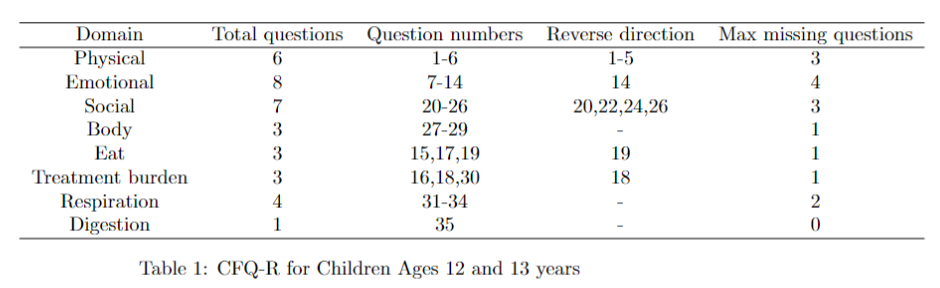
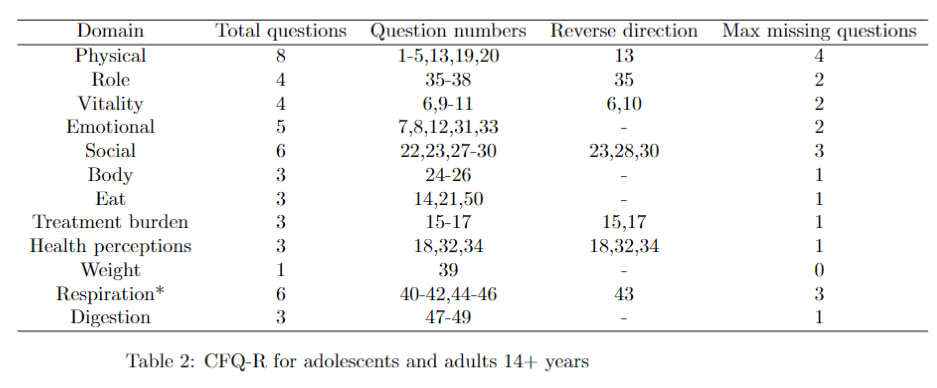
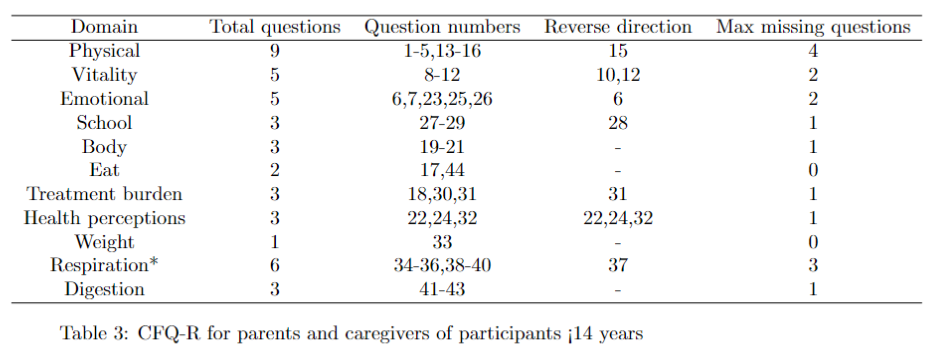

In [158]:
# CFQR Question domains
# cfqr ages12 and 13
cfqr1213_question_numbers = {}
cfqr1213_question_numbers["Physical"] = [1,2,3,4,5,6]
cfqr1213_question_numbers["Emotional"] = [7,8,9,10,11,12,13,14]
cfqr1213_question_numbers["Social"] = [20,21,22,23,24,25,26]
cfqr1213_question_numbers["Body"] = [27,28,29]
cfqr1213_question_numbers["Eat"] = [15,17,19]
cfqr1213_question_numbers["Treatment Burden"] = [16,18,30]
cfqr1213_question_numbers_respiration = [31,32,33,34]
cfqr1213_question_numbers_digestion = [35]

# cfqr adolescents and adults
cfqradol_physical = [1,2,3,4,5,13,19,20]
cfqradol_role = [35,36,37,38]
cfqradol_vitality = [6,9,10,11]
cfqradol_emotional = [7,8,12,31,33]
cfqradol_social = [22,23,27,28,29,30]
cfqradol_body = [24,25,26]
cfqradol_eat = [14,21,50]
cfqradol_treatmentburden = [15,16,17]
cfqradol_healthperceptions = [18,32,35]
cfqradol_weight = [39]
cfqradol_respiration = [40,41,42,44,45,46]
cfqradol_digestion = [47,48,49]

# cfqr parents and caregivers
cfqrparents_physical = [1,2,3,4,5,13,14,15,16]
cfqrparents_vitality = [8,9,10,11,12]
cfqrparents_emotional = [6,7,23,25,26]
cfqrparents_school = [27,28,29]
cfqrparents_body = [19,20,21]
cfqrparents_eat = [17,44]
cfqrparents_treatmentburden = [18,30,31]
cfqrparents_healthperceptions = [22,24,32]
cfqrparents_weight = [33]
cfqrparents_respiration = [34,35,36,38,39,40]
cfqrparents_digestion = [41,42,43]

In [159]:
# CFQR_12_13
mycursor.execute("""CREATE TABLE IF NOT EXISTS CFQR_1213 (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
physical DECIMAL (5,2),
emotional DECIMAL (5,2),
social DECIMAL (5,2),
body DECIMAL (5,2),
eat DECIMAL (5,2),
treatmentburden DECIMAL (5,2),
respiration DECIMAL (5,2),
digestion DECIMAL (5,2),
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

# CFQR Adolescent and adult
mycursor.execute("""CREATE TABLE IF NOT EXISTS CFQR_adol (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
physical DECIMAL (5,2),
role DECIMAL (5,2),
vitality DECIMAL (5,2),
emotional DECIMAL (5,2),
social DECIMAL (5,2),
body DECIMAL (5,2),
eat DECIMAL (5,2),
treatmentburden DECIMAL (5,2),
healthperceptions DECIMAL (5,2),
weight DECIMAL (5,2),
respiration DECIMAL (5,2),
digestion DECIMAL (5,2),
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

# CFQR parents and caregivers
mycursor.execute("""CREATE TABLE IF NOT EXISTS CFQR_parent (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,
physical DECIMAL (5,2),
vitality DECIMAL (5,2),
emotional DECIMAL (5,2),
school DECIMAL (5,2),
body DECIMAL (5,2),
eat DECIMAL (5,2),
treatmentburden DECIMAL (5,2),
healthperceptions DECIMAL (5,2),
weight DECIMAL (5,2),
respiration DECIMAL (5,2),
digestion DECIMAL (5,2),
updated_at TIMESTAMP,
PRIMARY KEY (study_id));""")

In [223]:
# Record all of the CFQR Questions

CFQR_adoladult_questions = {}
CFQR_adoladult_questions[1] = "Performing vigorous activities such as running or playing sports"
CFQR_adoladult_questions[2] = "Walking as fast as others"
CFQR_adoladult_questions[3] = "Carrying or lifting heavy things such as books, shopping, or school bags"
CFQR_adoladult_questions[4] = "Climbing one flight of stairs"
CFQR_adoladult_questions[5] = "Climbing stairs as fast as others"
CFQR_adoladult_questions[6] = "You felt well"
CFQR_adoladult_questions[7] = "You felt worried"
CFQR_adoladult_questions[8] = "You felt useless"
CFQR_adoladult_questions[9] = "You felt tired"
CFQR_adoladult_questions[10] = "You felt full of energy"
CFQR_adoladult_questions[11] = "You felt exhausted"
CFQR_adoladult_questions[12] = "You felt sad"
CFQR_adoladult_questions[13] = "To what extent do you have difficulty walking?"
CFQR_adoladult_questions[14] = "How do you feel about eating?"
CFQR_adoladult_questions[15] = "To what extent do your treatments make your daily life more difficult?"
CFQR_adoladult_questions[16] = "How much time do you currently spend each day on your treatments?"
CFQR_adoladult_questions[17] = "How difficult is it for you to do your treatments (including medications) each day?"
CFQR_adoladult_questions[18] = "How do you think your health is now?"
CFQR_adoladult_questions[19] = "I have trouble recovering after physical effort"
CFQR_adoladult_questions[20] = "I have to limit vigorous activities such as running or playing sports"
CFQR_adoladult_questions[21] = "I have to force myself to eat"
CFQR_adoladult_questions[22] = "I have to stay at home more than I want to"
CFQR_adoladult_questions[23] = "I feel comfortable discussing my illness with others"
CFQR_adoladult_questions[24] = "I think I am too thin"
CFQR_adoladult_questions[25] = "I think I look different from others my age"
CFQR_adoladult_questions[26] = "I feel bad about my physical appearance"
CFQR_adoladult_questions[27] = "People are afraid that I may be contagious"
CFQR_adoladult_questions[28] = "I get together with my friends a lot"
CFQR_adoladult_questions[29] = "I think my coughing bothers others"
CFQR_adoladult_questions[30] = "I feel comfortable going out at night"
CFQR_adoladult_questions[31] = "I often feel lonely"
CFQR_adoladult_questions[32] = "I feel healthy"
CFQR_adoladult_questions[33] = "It is difficult to make plans for the future (for example, going to college, getting married, getting promoted at work, etc.)"
CFQR_adoladult_questions[34] = "I lead a normal life"
CFQR_adoladult_questions[35] = "To what extent did you have trouble keeping up with your schoolwork, professional work, or other daily activities during the past two weeks?"
CFQR_adoladult_questions[36] = "How often were you absent from school, work, or unable to complete daily activities during the last two weeks because of your illness or treatments?"
CFQR_adoladult_questions[37] = "How often does CF get in the way of meeting your school, work, or personal goals?"
CFQR_adoladult_questions[38] = "How often does CF interfere with getting out of the house to run errands such as shopping or going to the bank?"
CFQR_adoladult_questions[39] = "Have you had trouble gaining weight?"
CFQR_adoladult_questions[40] = "Have you been congested?"
CFQR_adoladult_questions[41] = "Have you been coughing during the day?"
CFQR_adoladult_questions[42] = "Have you had to cough up mucus?"
CFQR_adoladult_questions[43] = "Has your mucus been mostly:"
CFQR_adoladult_questions[44] = "Have you been wheezing?"
CFQR_adoladult_questions[45] = "Have you had trouble breathing?"
CFQR_adoladult_questions[46] = "Have you woken up during the night because you were coughing?"
CFQR_adoladult_questions[47] = "Have you had problems with wind?"
CFQR_adoladult_questions[48] = "Have you had diarrhea?"
CFQR_adoladult_questions[49] = "Have you had abdominal pain?"
CFQR_adoladult_questions[50] = "Have you had eating problems?"

CFQR_1213_questions = {}
CFQR_1213_questions[1] = "You were able to walk as fast as others"
CFQR_1213_questions[2] = "You were able to climb stairs as fast as others"
CFQR_1213_questions[3] = "You were able to run, jump, and climb as you wanted"
CFQR_1213_questions[4] = "You were able to run as quickly and for as long as others"
CFQR_1213_questions[5] = "You were able to participate in sports that you enjoy (e.g., swimming, football, dancing or others)"
CFQR_1213_questions[6] = "You had difficulty carrying or lifting heavy things such as books, your school bag, or a backpack"
CFQR_1213_questions[7] = "You felt tired"
CFQR_1213_questions[8] = "You felt mad"
CFQR_1213_questions[9] = "You felt grouchy"
CFQR_1213_questions[10] = "You felt worried"
CFQR_1213_questions[11] = "You felt sad"
CFQR_1213_questions[12] = "You had trouble falling asleep"
CFQR_1213_questions[13] = "You had bad dreams or nightmares"
CFQR_1213_questions[14] = "You felt good about yourself"
CFQR_1213_questions[15] = "You had trouble eating"
CFQR_1213_questions[16] = "You had to stop fun activities to do your treatments"
CFQR_1213_questions[17] = "You were forced to eat"
CFQR_1213_questions[18] = "You were able to do all of your treatments"
CFQR_1213_questions[19] = "You enjoyed eating"
CFQR_1213_questions[20] = "You got together with friends a lot"
CFQR_1213_questions[21] = "You stayed at home more often than you wanted to"
CFQR_1213_questions[22] = "You felt comfortable sleeping away from home (at a friend of family member's house or elsewhere)"
CFQR_1213_questions[23] = "You felt left out"
CFQR_1213_questions[24] = "You often invited friends to your house"
CFQR_1213_questions[25] = "You were teased by other children"
CFQR_1213_questions[26] = "You felt comfortable discussion your illness with others (friends, teachers)"
CFQR_1213_questions[27] = "You thought you were too short"
CFQR_1213_questions[28] = "You thought you were too thin"
CFQR_1213_questions[29] = "You thought you were physically different from others your age"
CFQR_1213_questions[30] = "Doing your treatments bothered you"
CFQR_1213_questions[31] = "You coughed during the day"
CFQR_1213_questions[32] = "You woke up during the night because you were coughing"
CFQR_1213_questions[33] = "You had to cough up mucus"
CFQR_1213_questions[34] = "You had trouble breathing"
CFQR_1213_questions[35] = "Your stomach hurt"

CFQR_parent_questions = {}
CFQR_parent_questions[1] = "Performing vigorous activities such as running or playing sports"
CFQR_parent_questions[2] = "Walking as fast as others"
CFQR_parent_questions[3] = "Climbing stairs as fast as others"
CFQR_parent_questions[4] = "Carrying or lifting heavy objects such as books, school bag, or backpack"
CFQR_parent_questions[5] = "Climbing several flights of stairs"
CFQR_parent_questions[6] = "Seemed happy"
CFQR_parent_questions[7] = "Seemed worried"
CFQR_parent_questions[8] = "Seemed tired"
CFQR_parent_questions[9] = "Seemed short-tempered"
CFQR_parent_questions[10] = "Seemed well"
CFQR_parent_questions[11] = "Seemed grouchy"
CFQR_parent_questions[12] = "Seemed full of energy"
CFQR_parent_questions[13] = "Was absent or late for school or other activites because of his/her illness or treatments"
CFQR_parent_questions[14] = "The extent to which your child participated in sports and other physical activities, such as P.E. (physical education)"
CFQR_parent_questions[15] = "The extent to which your child has difficulty walking"
CFQR_parent_questions[16] = "My child has trouble recovering after physical effort"
CFQR_parent_questions[17] = "Mealtimes are a struggle"
CFQR_parent_questions[18] = "My child's treatments get in the way of his/her activities"
CFQR_parent_questions[19] = "My child feels small compared to other kids the same age "
CFQR_parent_questions[20] = "My child feels physically different from other kids the same age"
CFQR_parent_questions[21] = "My child thinks that he/she is too thin "
CFQR_parent_questions[22] = "My child feels healthy"
CFQR_parent_questions[23] = "My child tends to be withdrawn"
CFQR_parent_questions[24] = "My child leads a normal life"
CFQR_parent_questions[25] = "My child has less fun than usual"
CFQR_parent_questions[26] = "My child has trouble getting along with others"
CFQR_parent_questions[27] = "My child has trouble concentrating"
CFQR_parent_questions[28] = "My child is able to keep up with his/her school work or holiday activities"
CFQR_parent_questions[29] = "My child is not doing as well as usual in school or holiday activities"
CFQR_parent_questions[30] = "My child spends a lot of time on his/her treatments everyday"
CFQR_parent_questions[31] = "How difficult is it for your child to do his/her treatments (including medications) each day? "
CFQR_parent_questions[32] = "How do you think your childâ€™s health is now?"
CFQR_parent_questions[33] = "My child had trouble gaining weight"
CFQR_parent_questions[34] = "My child was congested"
CFQR_parent_questions[35] = "My child coughed during the day"
CFQR_parent_questions[36] = "My child had to cough up mucus"
CFQR_parent_questions[37] = "My child's mucus has been mostly:"
CFQR_parent_questions[38] = "My child wheezed"
CFQR_parent_questions[39] = "My child had trouble breathing"
CFQR_parent_questions[40] = "My child woke up during the night because he/she was coughing"
CFQR_parent_questions[41] = "My child had wind"
CFQR_parent_questions[42] = "My child had diarrhea"
CFQR_parent_questions[43] = "My child had abdominal pain"
CFQR_parent_questions[44] = "My child has had eating problems"

In [222]:
sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
cfqr_data = mycursor.fetchall()

# Rows = Domain
# Columns = Survey

Domains = ["Respiration", "Digestion", "Physical", "Emotional", "Body", "Eat", "Treatment Burden", "Role", "Vitality", "Social", "School", "Health Perceptions", "Weight"]

CFQR_results = {}
for domain in Domains:
    # Add a nested dictionary for each Domain type
    CFQR_results[domain] = {}
    
    CFQR_results[domain]["12-13"] = []
    CFQR_results[domain]["Parent/Caregiver"] = []
    CFQR_results[domain]["Adol/Adult"] = []
    
for a in range (0, len(cfqr_data)):
    
    study_id = cfqr_data[a][0]
    enrolment_date = cfqr_data[a][1]
    stratum = cfqr_data[a][2]

    # Compile a list of all the CFQR data that links with the study_ID
    cfqr_list = []

    sql_string = """SELECT *
    FROM cfqr_adolescent_adult
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    if len(temp_data) > 0:
        for b in range (0, len(temp_data)):
            cfqr_list.append(temp_data[b])

    sql_string = """SELECT *
    FROM cfqr_ages12_and13
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    if len(temp_data) > 0:
        for b in range (0, len(temp_data)):
            cfqr_list.append(temp_data[b])

    sql_string = """SELECT *
    FROM cfqr_parent_caregiver
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()

    if len(temp_data) > 0:
        for b in range (0, len(temp_data)):
            cfqr_list.append(temp_data[b])

    # Iterate through the cfqr_list to find the record which is closest to the date of enrolment
    temp_min = 60 # Determine which row is the closest to date of enrolment and within 30 days of enrolment
    temp_row = []
    for b in range (0, len(cfqr_list)):
        cfqr_date = cfqr_list[b][4].date()
        if (cfqr_date - enrolment_date).days < temp_min:
            temp_min = (cfqr_date - enrolment_date).days
            temp_row = cfqr_list[b][5:-4] # Only include the columns which refer to the answers to the survey question
                        
    if len(temp_row) != 0:
        if len(temp_row) == 50:
            CFQR_cat = "Adol/Adult"
        elif len(temp_row) == 44:
            CFQR_cat = "Parent/Caregiver"
        elif len(temp_row) == 35:
            CFQR_cat = "12-13"
        else:
            print("Data Length Error")
    else:
        CFQR_cat = None

    # Calculate the domains for the CFQ-R for children Ages 12 and 13 years
    # Scaled domain score = 100x(mean(domain question responses)-1) / 3
    # This code is really long and poorly written
    
    if CFQR_cat == "12-13":
        physical_list = []
        for b in range (0, len(cfqr1213_physical)):
            physical_list.append(temp_row[cfqr1213_physical[b]-1]) # take one because question 1 is indexed as 0
            physical = 100 * (statistics.mean(physical_list) - 1) / 3
            CFQR_results["Physical"][CFQR_cat].append(physical_list)
            
        emotional_list = []
        for b in range (0, len(cfqr1213_emotional)):
            emotional_list.append(temp_row[cfqr1213_emotional[b]-1])
            emotional = 100 * (statistics.mean(emotional_list) - 1) / 3
            CFQR_results["Emotional"][CFQR_cat].append(emotional_list)
            
        social_list = []
        for b in range (0, len(cfqr1213_social)):
            social_list.append(temp_row[cfqr1213_social[b]-1])
            social = 100 * (statistics.mean(social_list) - 1) / 3
            CFQR_results["Social"][CFQR_cat].append(social_list)             
            
        body_list = []
        for b in range (0, len(cfqr1213_body)):
            body_list.append(temp_row[cfqr1213_body[b]-1])
            body = 100 * (statistics.mean(body_list) - 1) / 3
            CFQR_results["Body"][CFQR_cat].append(body_list)
            
        eat_list = []
        for b in range (0, len(cfqr1213_eat)):
            eat_list.append(temp_row[cfqr1213_eat[b]-1])
            eat = 100 * (statistics.mean(eat_list) - 1) / 3
            CFQR_results["Eat"][CFQR_cat].append(eat_list)
            
        treatment_list = [] #treatment burden
        for b in range (0, len(cfqr1213_treatmentburden)):
            treatment_list.append(temp_row[cfqr1213_treatmentburden[b]-1])
            treatment = 100 * (statistics.mean(treatment_list) - 1) / 3
            CFQR_results["Treatment Burden"][CFQR_cat].append(treatment_list)
            
        respiration_list = []
        for b in range (0, len(cfqr1213_respiration)):
            respiration_list.append(temp_row[cfqr1213_respiration[b]-1])
            respiration = 100 * (statistics.mean(respiration_list) - 1) / 3
            CFQR_results["Respiration"][CFQR_cat].append(respiration_list)
            
        digestion_list = []
        for b in range (0, len(cfqr1213_digestion)):
            digestion_list.append(temp_row[cfqr1213_digestion[b]-1])
            digestion = 100 * (statistics.mean(digestion_list) - 1) / 3
            CFQR_results["Digestion"][CFQR_cat].append(digestion_list)
            
        sql_variables = [study_id, enrolment_date, stratum, physical, emotional, social, body, eat, treatment, respiration, digestion]
        #Write the MySQL insert string for this study_id
        sql_string = """INSERT IGNORE INTO CFQR_1213 (study_id, enrolment_date, stratum, physical, emotional, social, body, eat, treatmentburden, respiration, digestion, updated_at)VALUES ("""

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"
        mycursor.execute(sql_string)
        connection.commit()
        
    if CFQR_cat == "Adol/Adult":
        physical_list = []
        for b in range (0, len(cfqradol_physical)):
            physical_list.append(temp_row[cfqradol_physical[b]-1]) # take one because question 1 is indexed as 0
            physical = 100 * (statistics.mean(physical_list) - 1) / 3
            CFQR_results["Physical"][CFQR_cat].append(physical_list)
            
        role_list = []
        for b in range (0, len(cfqradol_role)):
            role_list.append(temp_row[cfqradol_role[b]-1])
            role = 100 * (statistics.mean(role_list) - 1) / 3
            CFQR_results["Role"][CFQR_cat].append(role_list)
        
        vitality_list = []
        for b in range (0, len(cfqradol_vitality)):
            vitality_list.append(temp_row[cfqradol_vitality[b]-1])
            vitality = 100 * (statistics.mean(vitality_list) - 1) / 3
            CFQR_results["Vitality"][CFQR_cat].append(vitality_list)
            
        emotional_list = []
        for b in range (0, len(cfqradol_emotional)):
            emotional_list.append(temp_row[cfqradol_emotional[b]-1])
            emotional = 100 * (statistics.mean(emotional_list) - 1) / 3
            CFQR_results["Emotional"][CFQR_cat].append(emotional_list)
            
        social_list = []
        for b in range (0, len(cfqradol_social)):
            social_list.append(temp_row[cfqradol_social[b]-1])
            social = 100 * (statistics.mean(social_list) - 1) / 3
            CFQR_results["Social"][CFQR_cat].append(social_list)
            
        body_list = []
        for b in range (0, len(cfqradol_body)):
            body_list.append(temp_row[cfqradol_body[b]-1])
            body = 100 * (statistics.mean(body_list) - 1) / 3
            CFQR_results["Body"][CFQR_cat].append(body_list)
            
        eat_list = []
        for b in range (0, len(cfqradol_eat)):
            eat_list.append(temp_row[cfqradol_eat[b]-1])
            eat = 100 * (statistics.mean(eat_list) - 1) / 3
            CFQR_results["Eat"][CFQR_cat].append(eat_list)
            
        treatment_list = [] #treatment burden
        for b in range (0, len(cfqradol_treatmentburden)):
            treatment_list.append(temp_row[cfqradol_treatmentburden[b]-1])
            treatment = 100 * (statistics.mean(treatment_list) - 1) / 3
            CFQR_results["Treatment Burden"][CFQR_cat].append(treatment_list)
            
        healthperceptions_list = []
        for b in range (0, len(cfqradol_healthperceptions)):
            healthperceptions_list.append(temp_row[cfqradol_healthperceptions[b]-1])
            healthperceptions = 100 * (statistics.mean(healthperceptions_list) - 1) / 3
            CFQR_results["Health Perceptions"][CFQR_cat].append(healthperceptions_list)
            
        weight_list = []
        for b in range (0, len(cfqradol_weight)):
            weight_list.append(temp_row[cfqradol_weight[b]-1])
            weight = 100 * (statistics.mean(weight_list) - 1) / 3
            CFQR_results["Weight"][CFQR_cat].append(weight_list)
            
        respiration_list = []
        for b in range (0, len(cfqradol_respiration)):
            respiration_list.append(temp_row[cfqradol_respiration[b]-1])
            respiration = 100 * (statistics.mean(respiration_list) - 1) / 3
            CFQR_results["Respiration"][CFQR_cat].append(respiration_list)
            
        digestion_list = []
        for b in range (0, len(cfqradol_digestion)):
            digestion_list.append(temp_row[cfqradol_digestion[b]-1])
            digestion = 100 * (statistics.mean(digestion_list) - 1) / 3
            CFQR_results["Digestion"][CFQR_cat].append(digestion_list)
            
        sql_variables = [study_id, enrolment_date, stratum, physical, role, vitality, emotional, social, body, eat, treatment, healthperceptions, weight, respiration, digestion]
        #Write the MySQL insert string for this study_id
        sql_string = """INSERT IGNORE INTO CFQR_adol (study_id, enrolment_date, stratum, physical, role, vitality, emotional, social, body, eat, treatmentburden, healthperceptions, weight, respiration, digestion, updated_at)VALUES ("""

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"
        mycursor.execute(sql_string)
        connection.commit()
        
    # CFQR parents and caregivers
    if CFQR_cat == "Parent/Caregiver":
        physical_list = []
        for b in range (0, len(cfqrparents_physical)):
            physical_list.append(temp_row[cfqrparents_physical[b]-1]) # take one because question 1 is indexed as 0
            physical = 100 * (statistics.mean(physical_list) - 1) / 3
            CFQR_results["Physical"][CFQR_cat].append(physical_list)
            
        vitality_list = []
        for b in range (0, len(cfqrparents_vitality)):
            vitality_list.append(temp_row[cfqrparents_vitality[b]-1])
            vitality = 100 * (statistics.mean(vitality_list) - 1) / 3
            CFQR_results["Vitality"][CFQR_cat].append(vitality_list)
            
        emotional_list = []
        for b in range (0, len(cfqrparents_emotional)):
            emotional_list.append(temp_row[cfqrparents_emotional[b]-1])
            emotional = 100 * (statistics.mean(emotional_list) - 1) / 3
            CFQR_results["Emotional"][CFQR_cat].append(emotional_list)
            
        school_list = []
        for b in range (0, len(cfqrparents_school)):
            school_list.append(temp_row[cfqrparents_school[b]-1])
            school = 100 * (statistics.mean(school_list) - 1) / 3
            CFQR_results["School"][CFQR_cat].append(school_list)
            
        body_list = []
        for b in range (0, len(cfqrparents_body)):
            body_list.append(temp_row[cfqrparents_body[b]-1])
            body = 100 * (statistics.mean(body_list) - 1) / 3
            CFQR_results["Body"][CFQR_cat].append(body_list)
            
        eat_list = []
        for b in range (0, len(cfqrparents_eat)):
            eat_list.append(temp_row[cfqrparents_eat[b]-1])
            eat = 100 * (statistics.mean(eat_list) - 1) / 3
            CFQR_results["Eat"][CFQR_cat].append(eat_list)
            
        treatment_list = [] #treatment burden
        for b in range (0, len(cfqrparents_treatmentburden)):
            treatment_list.append(temp_row[cfqrparents_treatmentburden[b]-1])
            treatment = 100 * (statistics.mean(treatment_list) - 1) / 3
            CFQR_results["Treatment Burden"][CFQR_cat].append(treatment_list)
            
        healthperceptions_list = []
        for b in range (0, len(cfqrparents_healthperceptions)):
            healthperceptions_list.append(temp_row[cfqrparents_healthperceptions[b]-1])
            healthperceptions = 100 * (statistics.mean(healthperceptions_list) - 1) / 3
            CFQR_results["Health Perceptions"][CFQR_cat].append(healthperceptions_list)
            
        weight_list = []
        for b in range (0, len(cfqrparents_weight)):
            weight_list.append(temp_row[cfqrparents_weight[b]-1])
            weight = 100 * (statistics.mean(weight_list) - 1) / 3
            CFQR_results["Weight"][CFQR_cat].append(weight_list)
            
        respiration_list = []
        for b in range (0, len(cfqrparents_respiration)):
            respiration_list.append(temp_row[cfqrparents_respiration[b]-1])
            respiration = 100 * (statistics.mean(respiration_list) - 1) / 3
            CFQR_results["Respiration"][CFQR_cat].append(respiration_list)
            
        digestion_list = []
        for b in range (0, len(cfqrparents_digestion)):
            digestion_list.append(temp_row[cfqrparents_digestion[b]-1])
            digestion = 100 * (statistics.mean(digestion_list) - 1) / 3
            CFQR_results["Digestion"][CFQR_cat].append(digestion_list)
            
        sql_variables = [study_id, enrolment_date, stratum, physical, vitality, emotional, school, body, eat, treatment, healthperceptions, weight, respiration, digestion]
        #Write the MySQL insert string for this study_id
        sql_string = """INSERT IGNORE INTO CFQR_parent (study_id, enrolment_date, stratum, physical, vitality, emotional, school, body, eat, treatmentburden, healthperceptions, weight, respiration, digestion, updated_at)VALUES ("""

        for b in range (0, len(sql_variables)):
            if sql_variables[b] == None:
                sql_string = sql_string + 'NULL,'
            else:
                sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
        sql_string = sql_string + "NOW())"
        mycursor.execute(sql_string)
        connection.commit()        
    

#### Heatmaps

NameError: name 'adol_respiration' is not defined

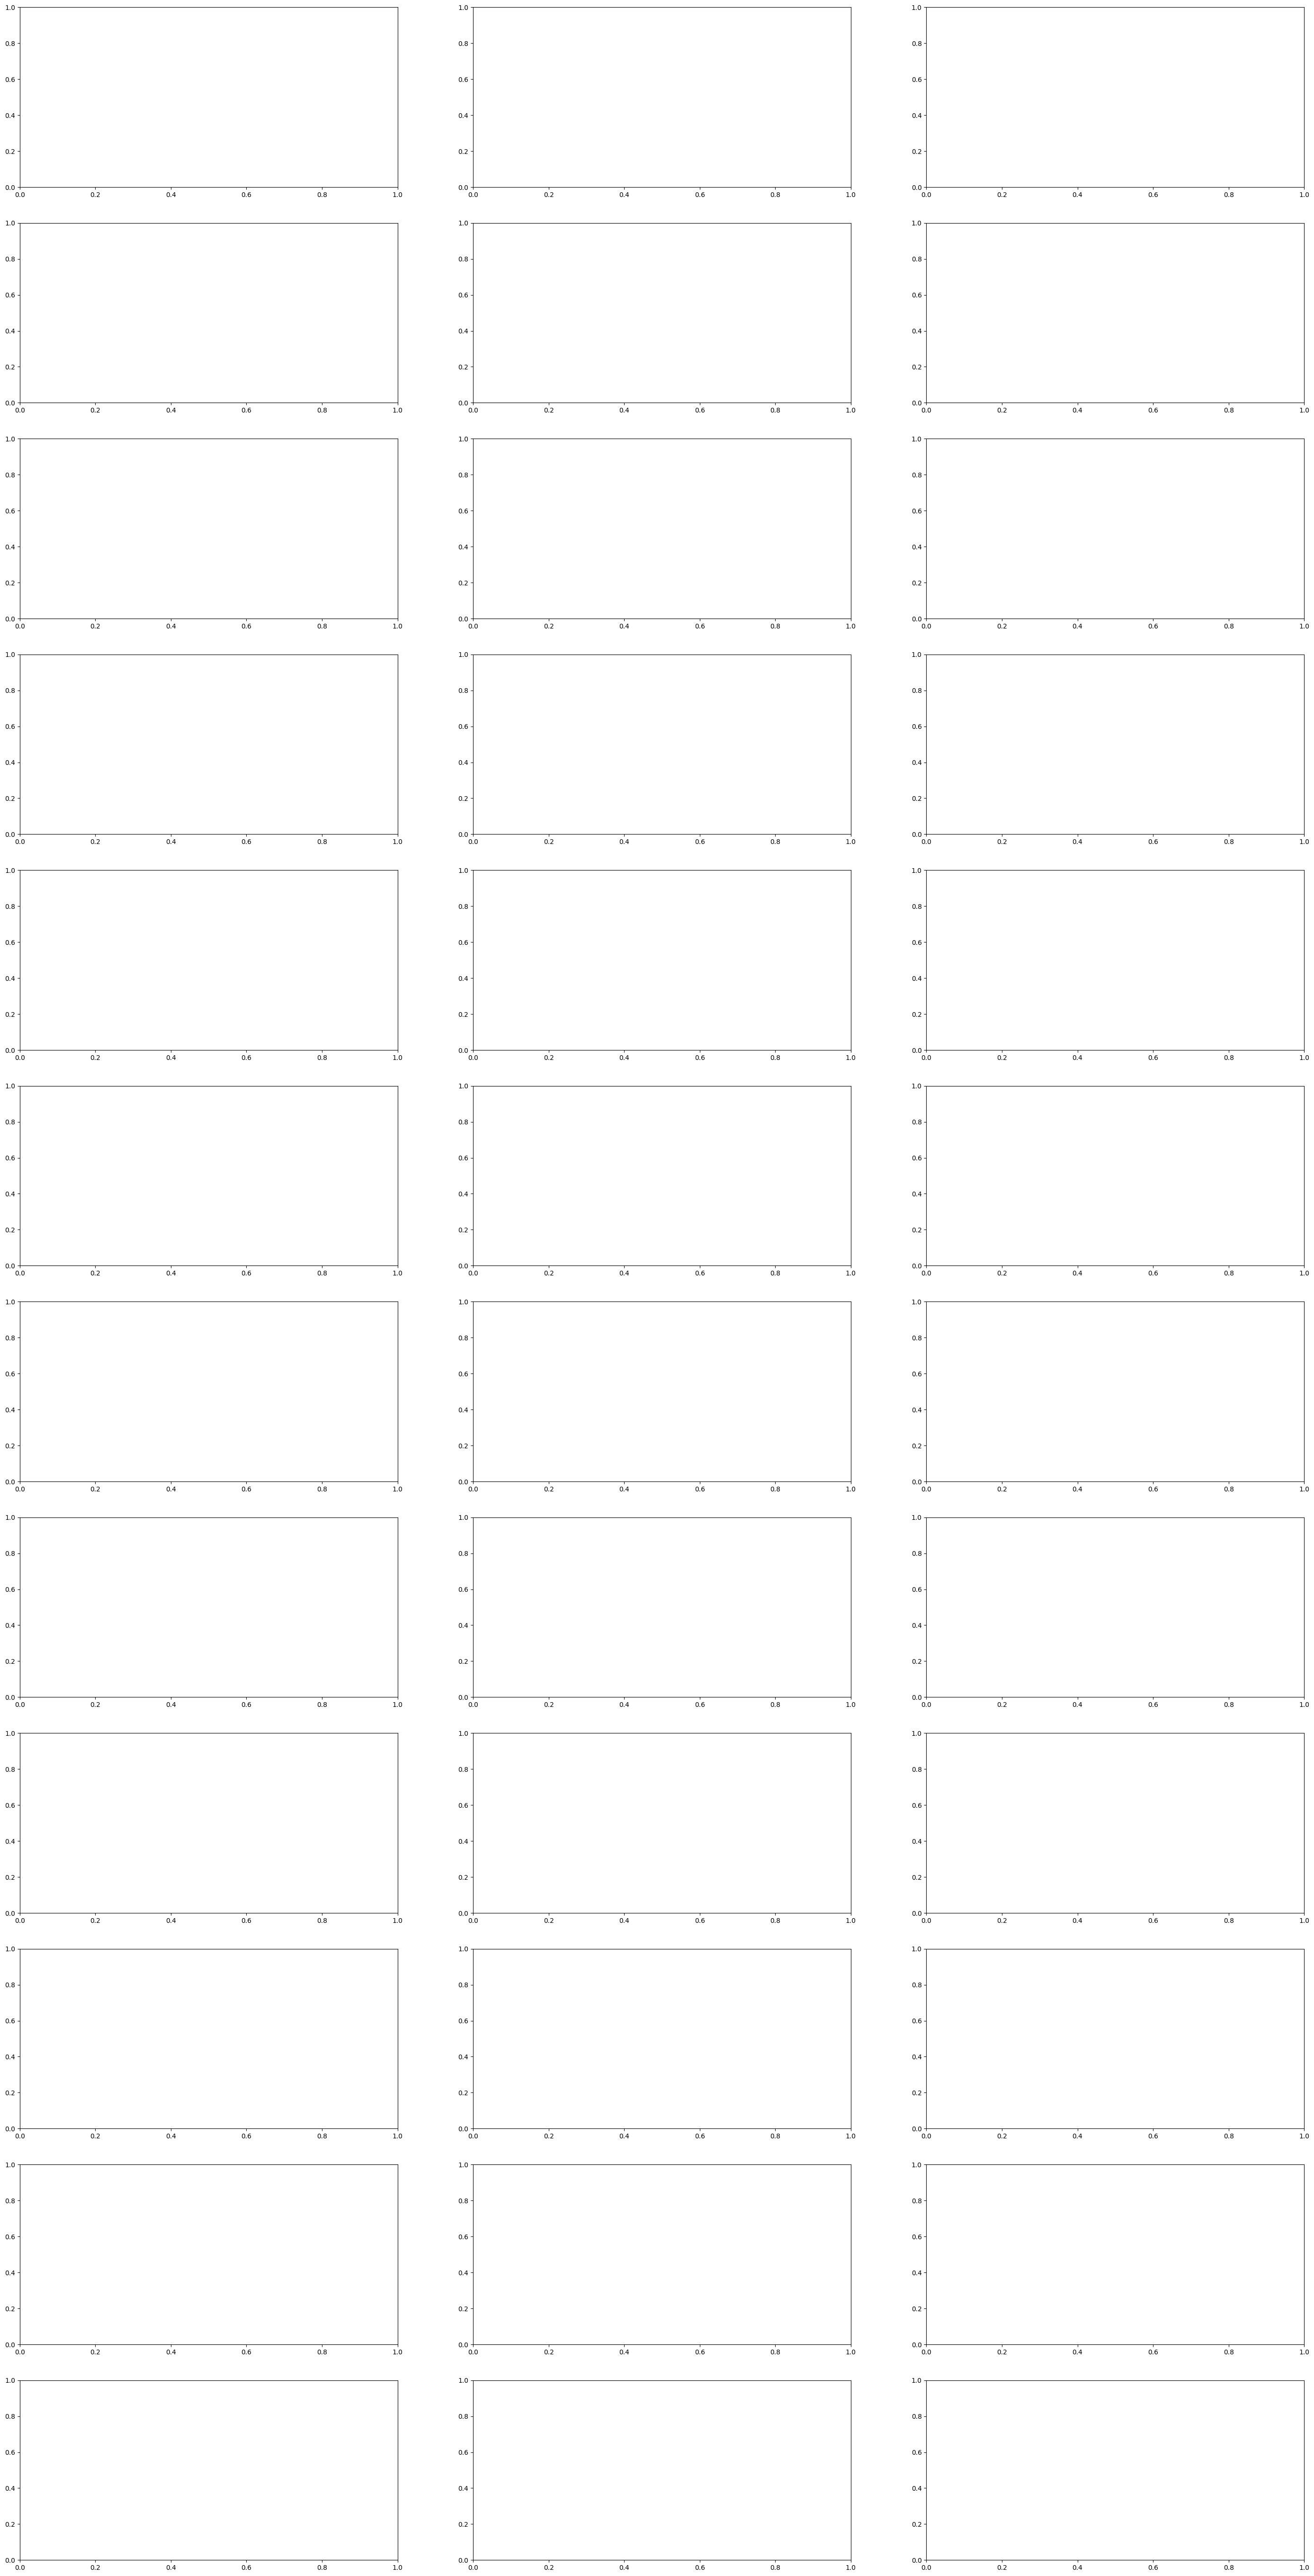

In [162]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(12,3, figsize=(35, 70))

# Respiration
for a in range (0, len(Domains)):
    

results = []
for a in range (0, len(adol_respiration[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(adol_respiration)):
    for b in range (0, len(adol_respiration[a])):
        results[b][adol_respiration[a][b]-1] = results[b][adol_respiration[a][b]-1] + 1

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(adol_respiration)) 
        
# setting the parameter values 
annot = True
  
y_axis_labels = ["Have you been congested?", "Have you been coughing during the day?", "Have you had to cough up mucus?", "Have you been wheezing?", "Have you had trouble breathing?", "Woke up at Night because you were coughing?"]
x_axis_labels = ["A great deal", "Somewhat", "A little", "Not at all"]

# plotting the heatmap 
ax[0,0].set_xticklabels(ax[0,0].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Blues', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[0, 0]) 

# Digestion

results = []
for a in range (0, len(adol_digestion[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(adol_digestion)):
    for b in range (0, len(adol_digestion[a])):
        results[b][adol_digestion[a][b]-1] = results[b][adol_digestion[a][b]-1] + 1
        
#Transpose the results
#results = np.array(results).T

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(adol_digestion)) 

# setting the parameter values 
annot = True
  
y_axis_labels = ["Have you had problems with wind?", "Have you had diarrhea?", "Have you had abdominal pain?"]
x_axis_labels = ["Always","Often","Sometimes","Never"]

# plotting the heatmap
ax[0, 1].set_xticklabels(ax[0, 1].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Blues', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[0, 1]) 
    
# displaying the plotted heatmap

# Physical

results = []
for a in range (0, len(adol_physical[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(adol_physical)):
    for b in range (0, len(adol_physical[a])):
        results[b][adol_physical[a][b]-1] = results[b][adol_physical[a][b]-1] + 1
        
#Transpose the results
#results = np.array(results).T

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(adol_physical)) 

# setting the parameter values 
annot = True
  
y_axis_labels = ["Performing vigorous activities such as running or playing sports", "Walking as fast as others", "Carrying or lifting heavy things such as books, shopping, or school bags","Climbing one flight of stairs","Climbing stairs as fast as others","To what extent do you have difficulty walking?","I have trouble recovering after physical effort","I have to limit vigorous activities such as running or playing sports"]
x_axis_labels = ["A lot of difficulty","Some difficulty","A little difficulty","No difficulty"]

# plotting the heatmap
ax[0, 2].set_xticklabels(ax[0, 2].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Blues', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[0, 2]) 
      
# CAREGIVER----------------------

results = []
for a in range (0, len(caregiver_respiration[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(caregiver_respiration)):
    for b in range (0, len(caregiver_respiration[a])):
        results[b][caregiver_respiration[a][b]-1] = results[b][caregiver_respiration[a][b]-1] + 1

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(caregiver_respiration)) 

# setting the parameter values 
annot = True
  
y_axis_labels = ["My child was congested","My child coughed during the day","My child had to cough up mucus","My child wheezed","My child had trouble breathing","My child woke up during the night because he/she was coughing"]
x_axis_labels = ["A great deal", "Somewhat", "A little", "Not at all"]

# plotting the heatmap 
ax[1, 0].set_xticklabels(ax[1, 0].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Greens', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[1, 0]) 
  

# Digestion

results = []
for a in range (0, len(caregiver_digestion[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(caregiver_digestion)):
    for b in range (0, len(caregiver_digestion[a])):
        results[b][caregiver_digestion[a][b]-1] = results[b][caregiver_digestion[a][b]-1] + 1

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(caregiver_digestion)) 

# setting the parameter values 
annot = True
  
y_axis_labels = ["My child had wind","My child had diarrhea","My child had abdominal pain"]
x_axis_labels = ["Always","Often","Sometimes","Never"]

# plotting the heatmap
ax[1, 1].set_xticklabels(ax[1, 1].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Greens', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[1, 1]) 

# Physical

results = []
for a in range (0, len(caregiver_physical[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(caregiver_physical)):
    for b in range (0, len(caregiver_physical[a])):
        results[b][caregiver_physical[a][b]-1] = results[b][caregiver_physical[a][b]-1] + 1
        
#Transpose the results
#results = np.array(results).T

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(caregiver_physical)) 
    

# setting the parameter values 
annot = True
  
y_axis_labels = ["Performing vigorous activities such as running or playing sports","Walking as fast as others","Climbing stairs as fast as others","Carrying or lifting heavy objects such as books, school bag, or backpack","Climbing several flights of stairs","Was absent or late for school or other activites because of his/her illness or treatments","The extent to which your child participated in sports and other physical activities","The extent to which your child has difficulty walking","My child has trouble recovering after physical effort"]
x_axis_labels = ["A lot of difficulty","Some difficulty","A little difficulty","No difficulty"]

# plotting the heatmap 
ax[1, 2].set_xticklabels(ax[1, 2].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Greens', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[1, 2]) 
    
# 12/13----------------------
    
# Respiration

results = []
for a in range (0, len(twelvethirteen_respiration[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(twelvethirteen_respiration)):
    for b in range (0, len(twelvethirteen_respiration[a])):
        results[b][twelvethirteen_respiration[a][b]-1] = results[b][twelvethirteen_respiration[a][b]-1] + 1

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(twelvethirteen_respiration)) 

# setting the parameter values 
annot = True
  
y_axis_labels = ["You coughed during the day","You woke up during the night because you were coughing","You had to cough up mucus","You had trouble breathing"]
x_axis_labels = ["A great deal", "Somewhat", "A little", "Not at all"]

# plotting the heatmap 
ax[2, 0].set_xticklabels(ax[2, 0].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Reds', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[2, 0]) 
  
plt.xticks(rotation=45)

# Digestion

results = []
for a in range (0, len(twelvethirteen_digestion[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(twelvethirteen_digestion)):
    for b in range (0, len(twelvethirteen_digestion[a])):
        results[b][twelvethirteen_digestion[a][b]-1] = results[b][twelvethirteen_digestion[a][b]-1] + 1
        
#Transpose the results
#results = np.array(results).T

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(twelvethirteen_digestion)) 
        
# setting the parameter values 
annot = True
  
y_axis_labels = ["Your stomach hurt"]
x_axis_labels = ["Always","Often","Sometimes","Never"]

# plotting the heatmap
ax[2, 1].set_xticklabels(ax[2, 1].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Reds', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[2, 1]) 
  
plt.xticks(rotation=45)

# Physical

results = []
for a in range (0, len(twelvethirteen_physical[0])):
    results.append([0, 0, 0, 0])

for a in range (0, len(twelvethirteen_physical)):
    for b in range (0, len(twelvethirteen_physical[a])):
        results[b][twelvethirteen_physical[a][b]-1] = results[b][twelvethirteen_physical[a][b]-1] + 1
        
#Transpose the results
#results = np.array(results).T

# Change to percentages
for a in range (0, len(results)):
    for b in range (0, len(results[a])):
        results[a][b] = round(results[a][b] * 100 / len(twelvethirteen_physical)) 

# setting the parameter values 
annot = True
  
y_axis_labels = ["You were able to walk as fast as others","You were able to climb stairs as fast as others","You were able to run, jump, and climb as you wanted","You were able to run as quickly and for as long as others","You were able to participate in sports that you enjoy (e.g., swimming, football, dancing or others)","You had difficulty carrying or lifting heavy things such as books, your school bag, or a backpack"]
x_axis_labels = ["Very True","Mostly True","Somewhat True","Not at all True"]

# plotting the heatmap
ax[2, 2].set_xticklabels(ax[2, 2].get_xticks(), rotation = 45)
hm = sn.heatmap(data=results, annot=annot, cmap='Reds', fmt='g', xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax[2, 2]) 
    
# displaying the plotted heatmap 
ax[0, 0].set_title("Respiration Domain")
ax[0, 0].set(ylabel="Adolescents / Adults")

ax[0, 1].set_title("Digestion Domain")
ax[1, 0].set(ylabel="Parents / Caregivers")

ax[0, 2].set_title("Physical Domain")
ax[2, 0].set(ylabel="12 / 13 year old")

fig.tight_layout()
plt.savefig('BEATCF_heatmaps.png')
plt.show() 

#### Total Heatmaps

##### Adult / Adolescent

In [224]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 
from statistics import mean

CFQR_stratum = ["HighLungfunction+NoPseudomonas", "HighLungfunction+Pseudomonas",'LowLungfunction+NoPseudomonas','LowLungfunction+Pseudomonas']
domains = ["Physical", "Role", "Vitality", "Emotional", "Social", "Body", "Eat", "Treatment Burden", "Health Perceptions", "Weight", "Repiration", "Digestion"]

# Calculate the averages for each domain, each stratum
results = []
CFQR_stratum_label = []
for stratum in CFQR_stratum:
    sql_string = """select * from cfqr_adol where stratum = '{}' and enrolment_date < "2023-07-01" and study_id not in ('010-0004', '010-0032')""".format(stratum)
    mycursor.execute(sql_string)
    data = mycursor.fetchall()
    
    label_string = stratum.split("+")[0] + "\n" + stratum.split("+")[1] + "\n(n={})".format(len(data)) 
    CFQR_stratum_label.append(label_string)
    #print(stratum, len(data))
    
    score_array = [[] for a in range (len(domains))] # There are 12 domains for adolescent / adult CFQR survey
    for a in range (0, len(data)):
        for b in range (0, len(domains)): 
            score_array[b].append(float(data[a][b+3]))
    
    temp = []
    for b in range (0, len(domains)):
        temp.append(round(mean(score_array[b])))
    results.append(temp)
    
results = np.array(results).T

plt.figure(figsize=(10, 8), dpi=80)
hm = sn.heatmap(data=results, annot=annot, cmap='Blues', xticklabels=CFQR_stratum_label, yticklabels=domains, fmt='g')
hm.set(xlabel='BEATCF Stratum', ylabel='CFQR Domain')
plt.xticks(rotation=45)
plt.title("Adolescent / Adult - CFQR Scores")
plt.show()

NameError: name 'annot' is not defined

<Figure size 800x640 with 0 Axes>

##### Caregiver / Parents

In [225]:
# Removed Low Lungfunction Strata

CFQR_stratum = ["HighLungfunction+NoPseudomonas", "HighLungfunction+Pseudomonas"]
CFQR_stratum_label = ["HighLungfunction\nNoPseudomonas", "HighLungfunction\nPseudomonas"]
domains = ["Physical", "Vitality", "Emotional", "School", "Body", "Eat", "Treatment Burden", "Health Perceptions", "Weight", "Repiration", "Digestion"]

# Calculate the averages for each domain, each stratum
results = []
CFQR_stratum_label = []
for stratum in CFQR_stratum:
    sql_string = """select * from cfqr_parent where stratum = '{}' and enrolment_date < "2023-07-01" and study_id not in ('010-0004', '010-0032')""".format(stratum)
    mycursor.execute(sql_string)
    data = mycursor.fetchall()
    
    label_string = stratum.split("+")[0] + "\n" + stratum.split("+")[1] + "\n(n={})".format(len(data)) 
    CFQR_stratum_label.append(label_string)
    
    score_array = [[] for a in range (len(domains))] # There are 12 domains for adolescent / adult CFQR survey
    for a in range (0, len(data)):
        for b in range (0, len(domains)): 
            score_array[b].append(float(data[a][b+3]))
    
    temp = []
    for b in range (0, len(domains)):
        temp.append(round(mean(score_array[b])))
    results.append(temp)
    
results = np.array(results).T

plt.figure(figsize=(6, 8), dpi=80)
hm = sn.heatmap(data=results, annot=annot, cmap='Blues', xticklabels=CFQR_stratum_label, yticklabels=domains, fmt='g')
hm.set(xlabel='BEATCF Stratum', ylabel='CFQR Domain')
plt.xticks(rotation=45)
plt.title("Parent / Caregiver - CFQR Scores")
plt.show()

NameError: name 'annot' is not defined

<Figure size 480x640 with 0 Axes>

#### Age Plots

##### Original Plots

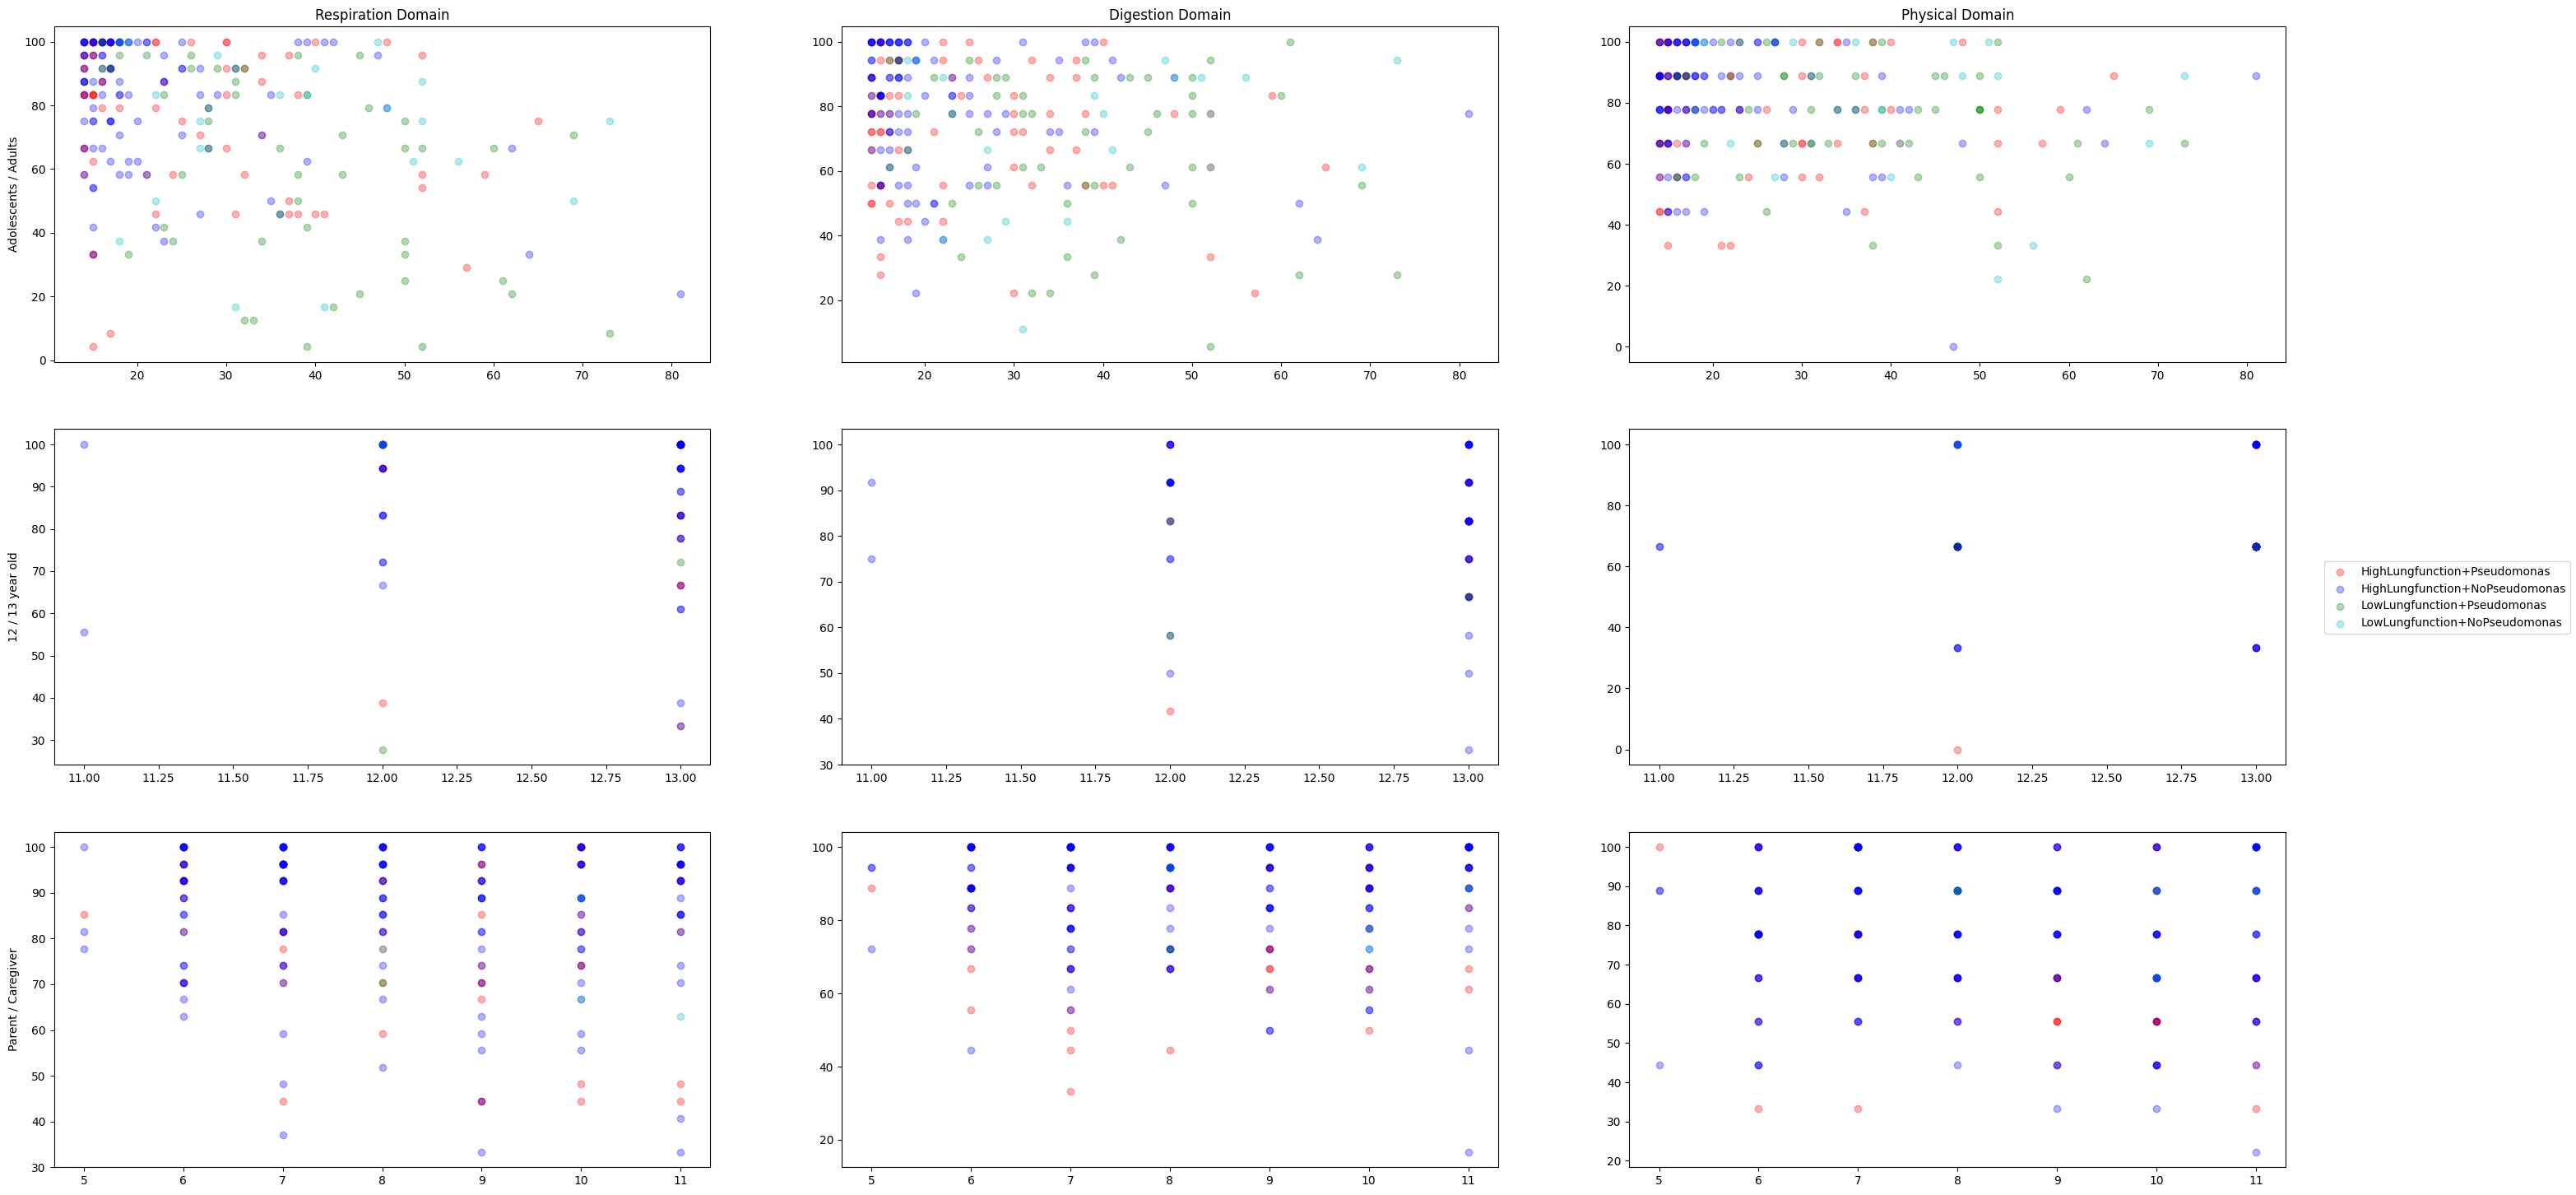

In [226]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3,3, figsize=(35, 18))

CFQR_domains = ["physical", "respiration", "digestion"]
CFQR_survey = ["cfqr_adol", "cfqr_1213", "cfqr_parent"]
CFQR_stratum = ["HighLungfunction+Pseudomonas", "HighLungfunction+NoPseudomonas",'LowLungfunction+Pseudomonas','LowLungfunction+NoPseudomonas']
colours = ['r', 'b', 'g', 'c']

for a in range (0, len(CFQR_survey)):
    for b in range (0, len(CFQR_domains)):
        for c in range (0, len(CFQR_stratum)):

            survey = CFQR_survey[a]
            domain = CFQR_domains[b]
            stratum = CFQR_stratum[c]
            
            sql_string = "select a.study_id, a.{}, b.age_int from {} a inner join beatcf_enrolment_paper b where a.study_id = b.study_id and b.stratum = '{}' and b.ppfev_365 != ''".format(domain, survey, stratum)
            mycursor.execute(sql_string)
            data = mycursor.fetchall()

            y_column = []
            age = []
            for d in range (0, len(data)):
                y_column.append(data[d][1])
                age.append(data[d][2])
                
            ax[a, b].scatter(age, y_column, color = colours[c], alpha=0.3, label = stratum)

# displaying the plotted heatmap 
ax[0, 0].set_title("Respiration Domain")
ax[0, 0].set(ylabel="Adolescents / Adults")

ax[0, 1].set_title("Digestion Domain")
ax[1, 0].set(ylabel="12 / 13 year old")

ax[0, 2].set_title("Physical Domain")
ax[2, 0].set(ylabel="Parent / Caregiver")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.savefig('BEATCF_CFQR vs Age.png')
plt.show()

##### Age Spread

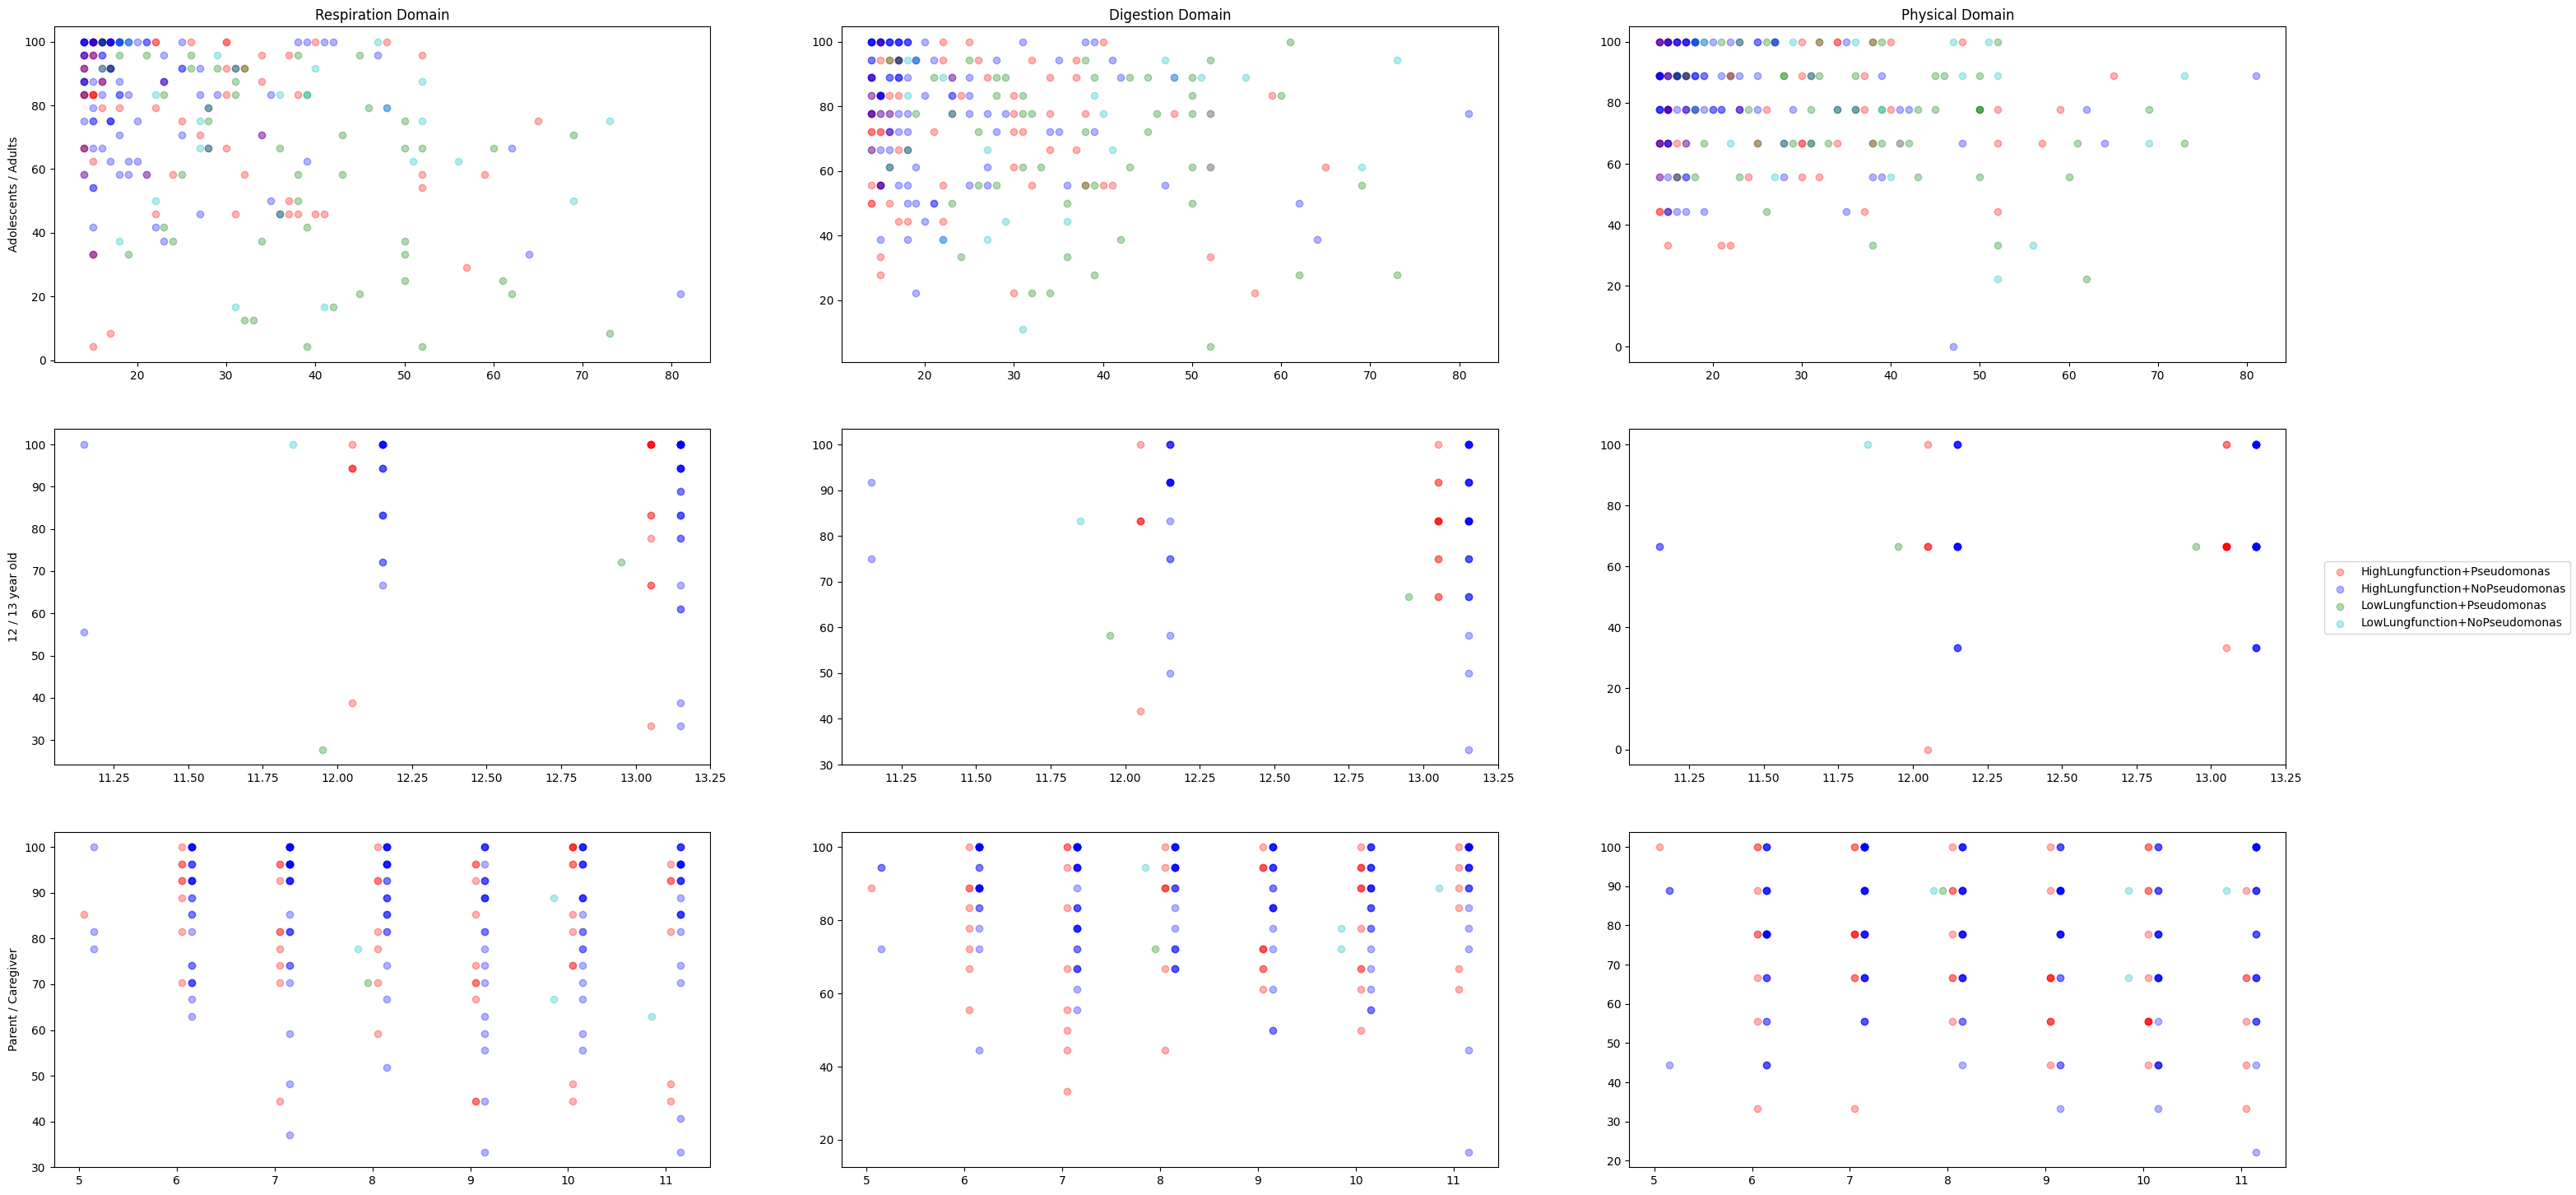

In [227]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3,3, figsize=(35, 18))

CFQR_domains = ["physical", "respiration", "digestion"]
CFQR_survey = ["cfqr_adol", "cfqr_1213", "cfqr_parent"]
CFQR_stratum = ["HighLungfunction+Pseudomonas", "HighLungfunction+NoPseudomonas",'LowLungfunction+Pseudomonas','LowLungfunction+NoPseudomonas']
colours = ['r', 'b', 'g', 'c']
age_spread = [0.05, 0.15, -0.05, -0.15]

for a in range (0, len(CFQR_survey)):
    for b in range (0, len(CFQR_domains)):
        for c in range (0, len(CFQR_stratum)):

            survey = CFQR_survey[a]
            domain = CFQR_domains[b]
            stratum = CFQR_stratum[c]
            
            sql_string = "select a.study_id, a.{}, b.age_int from {} a inner join beatcf_enrolment_paper b where a.study_id = b.study_id and b.stratum = '{}' and b.ppfev_365 != ''".format(domain, survey, stratum)
            mycursor.execute(sql_string)
            data = mycursor.fetchall()

            y_column = []
            age = []
            for d in range (0, len(data)):
                y_column.append(data[d][1])
                if a != 0:
                    age.append(data[d][2] + age_spread[c])
                else:
                    age.append(data[d][2])
                
            ax[a, b].scatter(age, y_column, color = colours[c], alpha=0.3, label = stratum)

# displaying the plotted heatmap 
ax[0, 0].set_title("Respiration Domain")
ax[0, 0].set(ylabel="Adolescents / Adults")

ax[0, 1].set_title("Digestion Domain")
ax[1, 0].set(ylabel="12 / 13 year old")

ax[0, 2].set_title("Physical Domain")
ax[2, 0].set(ylabel="Parent / Caregiver")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.savefig('BEATCF_CFQR vs Age.png')
plt.show()

#### FFEVplot

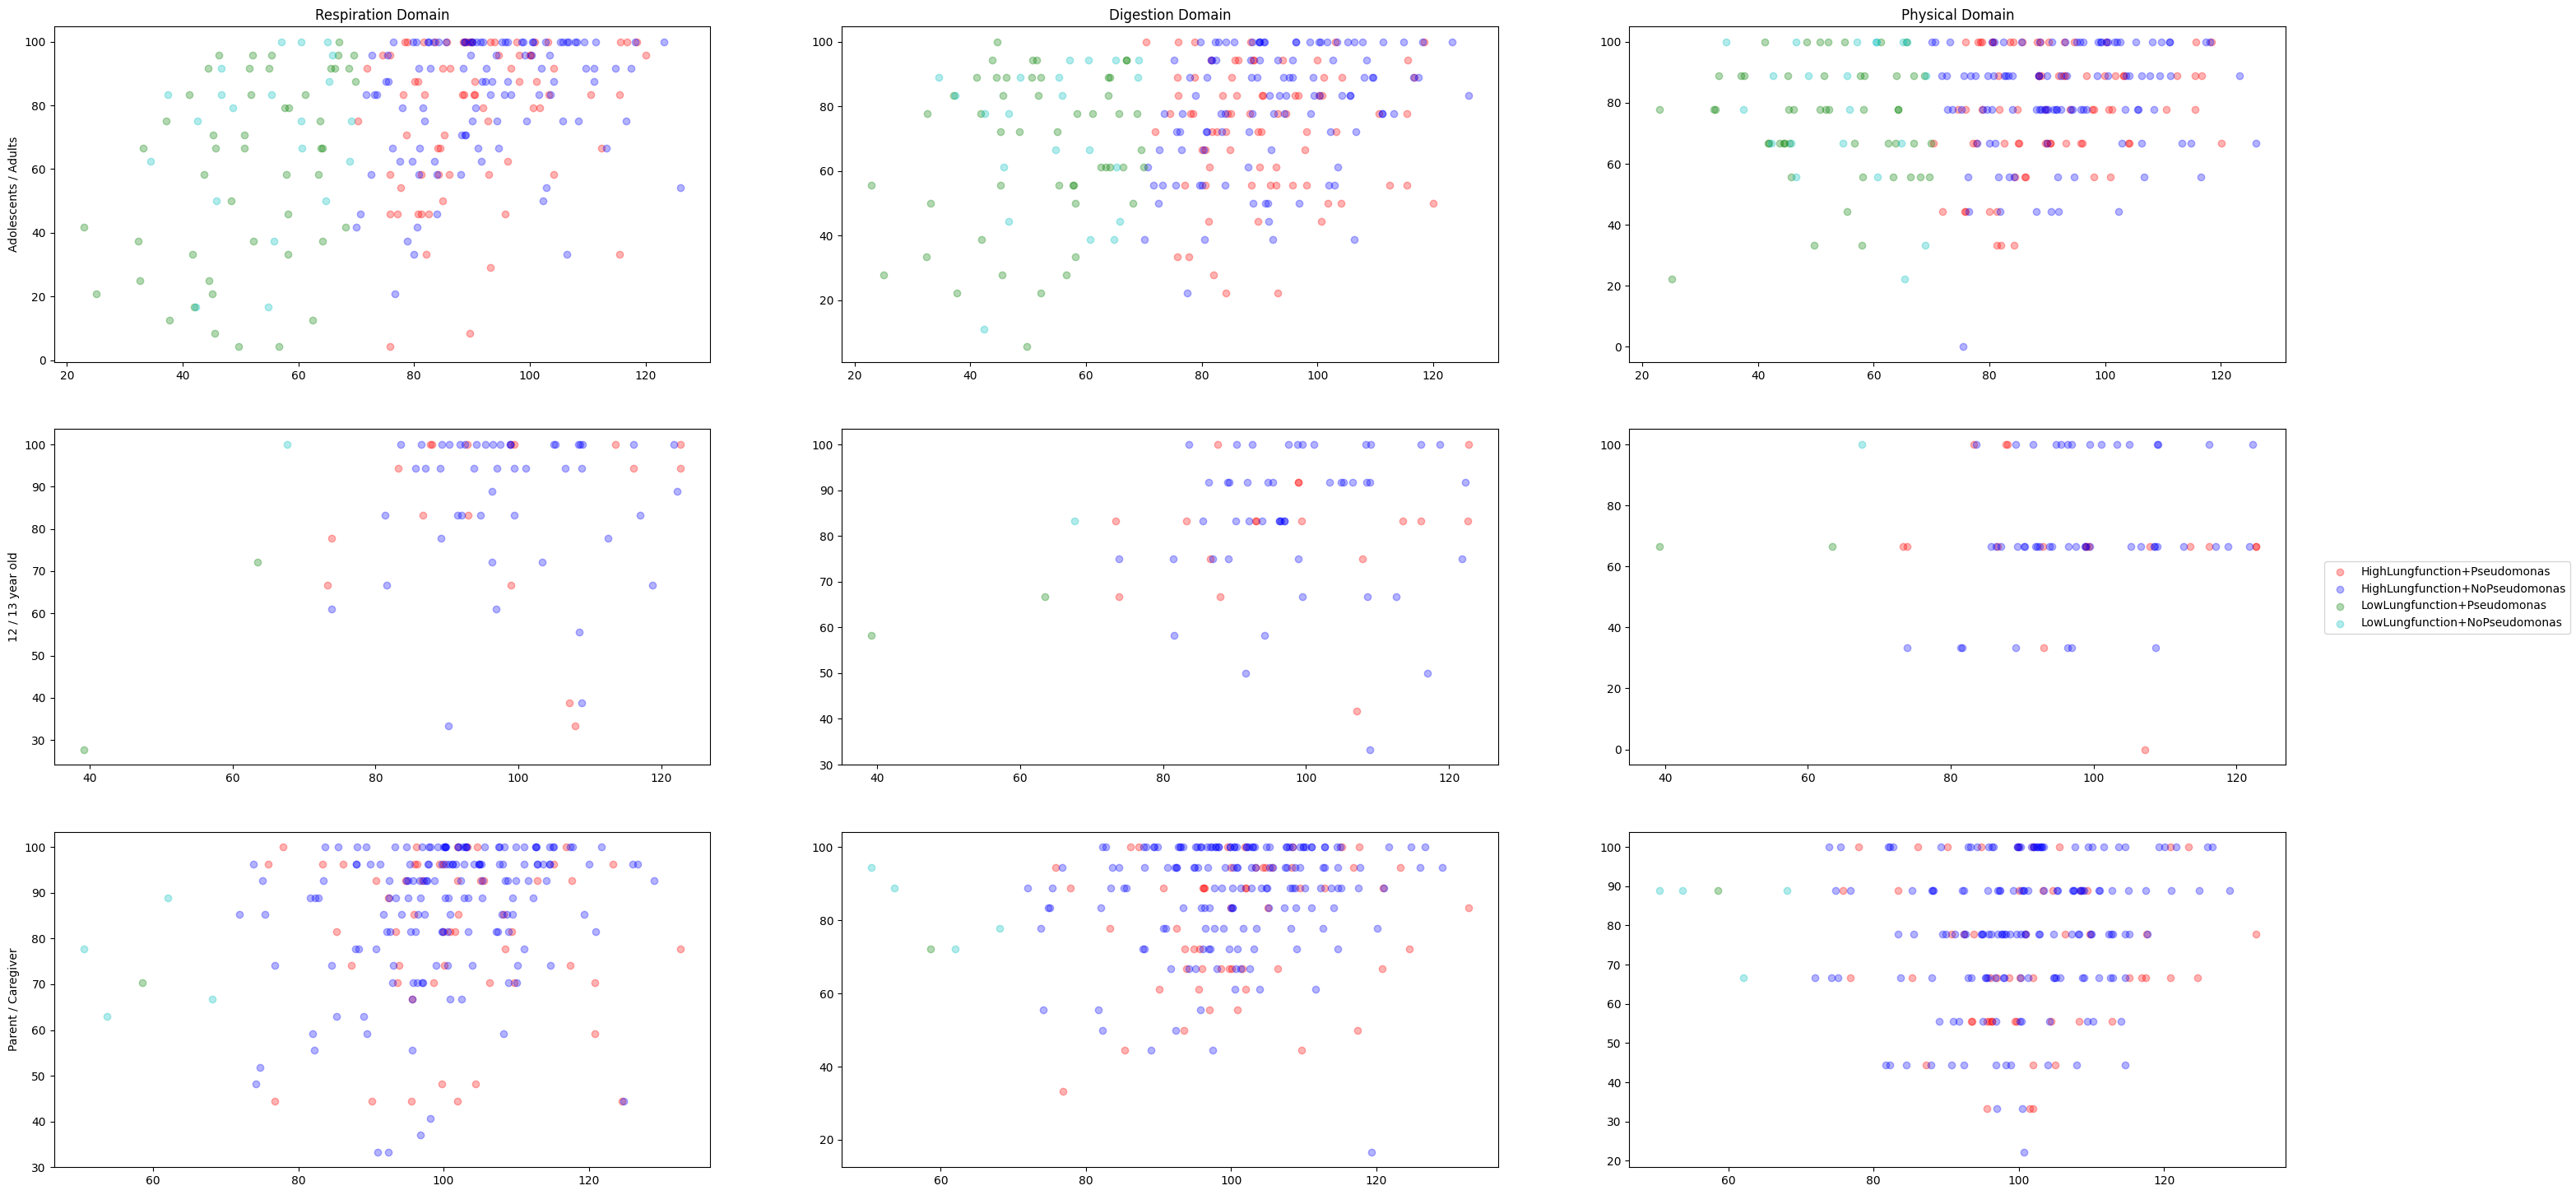

In [228]:
import warnings
warnings.filterwarnings('ignore')

# importing the modules 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(3,3, figsize=(35, 18))

CFQR_domains = ["physical", "respiration", "digestion"]
CFQR_survey = ["cfqr_adol", "cfqr_1213", "cfqr_parent"]
CFQR_stratum = ["HighLungfunction+Pseudomonas", "HighLungfunction+NoPseudomonas",'LowLungfunction+Pseudomonas','LowLungfunction+NoPseudomonas']
colours = ['r', 'b', 'g', 'c']

for a in range (0, len(CFQR_survey)):
    for b in range (0, len(CFQR_domains)):
        for c in range (0, len(CFQR_stratum)):

            survey = CFQR_survey[a]
            domain = CFQR_domains[b]
            stratum = CFQR_stratum[c]
            
            sql_string = "select a.study_id, a.{}, b.ppfev_365 from {} a inner join beatcf_enrolment_paper b where a.study_id = b.study_id and b.stratum = '{}' and b.ppfev_365 != ''".format(domain, survey, stratum)
            mycursor.execute(sql_string)
            data = mycursor.fetchall()

            y_column = []
            ppfev = []
            for d in range (0, len(data)):
                y_column.append(data[d][1])
                ppfev.append(data[d][2])
                
            ax[a, b].scatter(ppfev, y_column, color = colours[c], alpha=0.3, label = stratum)

# displaying the plotted heatmap 
ax[0, 0].set_title("Respiration Domain")
ax[0, 0].set(ylabel="Adolescents / Adults")

ax[0, 1].set_title("Digestion Domain")
ax[1, 0].set(ylabel="12 / 13 year old")

ax[0, 2].set_title("Physical Domain")
ax[2, 0].set(ylabel="Parent / Caregiver")

handles, labels = ax[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')
plt.savefig('BEATCF_CFQR vs ppFEV.png')
plt.show()

### Concomitant Medications

In [163]:
# Create a dictionary from predefined grouping from .csv file
conmed_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\BEATCF_ConcomitantMedications_19Feb2024.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        conmed_data.append(row)

In [164]:
conmed_group = {} # Links free text with a con med grouping category

for a in range (1, len(conmed_data)): # Discard the headings of the csv
    free_text = conmed_data[a][1]
    free_text = free_text.replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","") # Remove unrecognized characters
    conmed_group[free_text] = conmed_data[a][4]
    
conmed_group = dict(sorted(conmed_group.items())) # Sort the dictionary alphabetically 
    
final_grouping = []
for key in conmed_group:
    grouping = conmed_group[key]
    grouping = grouping.replace("Â\xa0", "")
    if grouping == "?" or grouping == "":
        grouping = "Unknown"
    if grouping not in final_grouping:
        final_grouping.append(grouping)
        
final_grouping.sort()

In [165]:
conmed_group_index = {} # Links cmt index with their medication name 

sql_string = """SELECT * FROM medication_name"""
mycursor.execute(sql_string)
temp_data = mycursor.fetchall()

for a in range (0, len(temp_data)):
    index = temp_data[a][0]
    medication_name = temp_data[a][1].replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","").replace("Â®", "") # Remove special characters
    medication_name = medication_name + "_index"
    medication_name = medication_name.lstrip(" ") # Remove the first character space from the medication names from the SQL database
    
    conmed_group_index[index] = medication_name

In [166]:
# Create Concomitant table
sql_string = "select * from medication_name"
mycursor.execute(sql_string)
medication_name = mycursor.fetchall()

sql_string = "CREATE TABLE IF NOT EXISTS conmeds_paper_grouped (study_id VARCHAR (8),enrolment_date DATE,stratum TEXT,"

for a in range (0, len(final_grouping)):
    sql_string = sql_string + "{} INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
               
sql_string = sql_string + "updated_at TIMESTAMP, PRIMARY KEY (study_id));"
    
mycursor.execute(sql_string)

In [167]:
# The concomitant medication is present if within the date range of enrolment to "+ 31 days" ~ date window
# If the concomitant is ongoing and
    # startdate is before enrolment date + date window
    # startdate is missing (There is never an end date when ongoing)
# If startdate and end date is all present
    # If startdate before enroldate + date window and enddate after enroldate
# If only startdate is present
    # If startdate is before enroldate + date window
# If only enddate is present
    # if enddate is after enroldate
    
datewindow = 30

sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
conmed_dict = {}
for a in range (0, len(conmeds_data)):
    study_id = conmeds_data[a][0]
    enrol_date = conmeds_data[a][1]
    stratum = conmeds_data[a][2]
    
    # Find their concomitant_medication
    sql_string = """SELECT study_id, cmtrt, cmtrtoth, cmtrtname, cmstdat, cmongo, cmendat, cmroute
    FROM concomitant_medication
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    #print(len(temp_data))
    
    #Reset Dictionary
    for a in range (0, len(final_grouping)):
        conmed_dict[final_grouping[a]] = 0
    
    if len(temp_data) != 0:
        # Check to see if the concomitant medication was active during enrolment date
        duplicate_list = [] # Check to see if there are any duplicates
        for b in range (0, len(temp_data)):
            flag = 0

            cmt_index = temp_data[b][1]
            cmt_oth = temp_data[b][2]
            cmt_name = temp_data[b][3]
            start_date = temp_data[b][4]
            end_date = temp_data[b][6]
            cmongo = temp_data[b][5]
            cmroute = temp_data[b][7]

            flag = 0
            if cmongo == 1: # If the medication is ongoing
                if start_date != None:
                    if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                        flag = 1
                else:
                    flag = 1
            elif start_date != None and end_date != None:
                if (start_date <= enrol_date + datetime.timedelta(days=datewindow)) and (enrol_date <= end_date):
                    flag = 1
            elif end_date == None:
                if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                    flag = 1
            elif start_date == None:
                if enrol_date <= end_date:
                    flag = 1
            elif end_date == None and start_date == None:
                print("Data Error")
                
            # Update the correct key in the conmed_dictionary
            if flag == 1:
                if cmt_index != 9998 and cmt_index != 9999:
                    medication_index_name = conmed_group_index[cmt_index]
                    group = conmed_group[medication_index_name]
                    conmed_dict[group] = 1
                else:
                    if cmt_oth in conmed_group:
                        group = conmed_group[cmt_oth]
                        group = group.replace("Â\xa0", "") # Remove Special character from cmt_oth
                    else:
                        # Manual handeling of some special characters
                        if cmt_oth == "EscitaloprÃ¡m":
                            group = "Other"
                        print(cmt_index, cmt_oth)
                    if group == "?" or group == "":
                        group = "Unknown"
                    # Remove Tobramycin or Other Antibiotics when route is IV (3)
                    if group == "Antibiotic - Tobramycin" or group == "Antibiotic - other":
                        if cmroute != 3:
                            conmed_dict[group] = 1
                    else:
                        conmed_dict[group] = 1
                    
    sql_variables = [study_id, enrol_date, stratum]
    for key in conmed_dict:
        sql_variables.append(conmed_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO conmeds_paper_grouped (study_id,enrolment_date,stratum,"
    
    for a in range (0, len(final_grouping)):
        sql_string = sql_string + "{},".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "updated_at)VALUES ("
    
    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"
    
    mycursor.execute(sql_string)
    connection.commit()
print("finished")

9999 frusemide
9999 isavuconazole
9999 tramadol
9999 panadol osteo
9999 EscitaloprÃ¡m
9999 testosterone
9999 denosumab
9999 Covid Vaccine
9999 Testosterone
9999 Panadol Osteo
9999 Isotretinoin
finished


In [168]:
# Sort the concomitant medications by Frequency

sql_string = """SELECT * FROM conmeds_paper_grouped WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

conmeds_name = ["ADHD_medication","Anti_eosinophilic_antibodies","Antibiotic___Amoxicillin","Antibiotic___Azithromycin","Antibiotic___Ciprofloxacin","Antibiotic___Cotrimoxazole_","Antibiotic___Flucloxacillin","Antibiotic___Tobramycin","Antibiotic___other","Anticonvulsant","Antidepressant","Antifungal","Antipsychotic","Corticosteroids___Inhaled","Corticosteroids___Nasal","Corticosteroids___Systemic","Corticosteroids___Topical","Dornase_Alfa","Elexacaftor_tezacaftor_ivacaftor__Trikafta_","Hypertonic_saline","Iron_supplement","Ivacaftor__Kalydeco_","Lumacaftor_ivacaftor__Orkambi_","Mannitol__Bronchitol_","Other","Pancreatic_enzyme_replacement","Proton_pump_inhibitor","Salbutamol__Ventolin_","Sodium_chloride__salt_","Tezacaftor_ivacaftor_and_ivacaftor__symdeko_","Unknown","Ursodeoxycholic_acid","Vitamin_mineral_supplements"]

frequency_list = []
for a in range (0, len(conmeds_name)):
    count = 0
    for b in range (0, len(conmeds_data)):
        count = count + conmeds_data[b][a+3]
    frequency_list.append([count, conmeds_name[a]])

#### Concomitant Medications 2

In [169]:
# Adding route to the concomintant medications that have been already classified by the concomitant medications.csv file.

In [213]:
# Create a dictionary from predefined grouping from .csv file
conmed_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\BEATCF_ConcomitantMedications_08Jan2024.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        conmed_data.append(row)

In [214]:
conmed_group = {} # Links free text with a con med grouping category

for a in range (1, len(conmed_data)): # Discard the headings of the csv
    free_text = conmed_data[a][1]
    free_text = free_text.replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","") # Remove unrecognized characters
    conmed_group[free_text] = conmed_data[a][4]
    
conmed_group = dict(sorted(conmed_group.items())) # Sort the dictionary alphabetically 
    
final_grouping = []
for key in conmed_group:
    grouping = conmed_group[key]
    grouping = grouping.replace("Â\xa0", "")
    if grouping == "?" or grouping == "":
        grouping = "Unknown"
    if grouping not in final_grouping:
        final_grouping.append(grouping)
        
final_grouping.sort()

In [215]:
conmed_group_index = {} # Links cmt index with their medication name 

sql_string = """SELECT * FROM medication_name"""
mycursor.execute(sql_string)
temp_data = mycursor.fetchall()

for a in range (0, len(temp_data)):
    index = temp_data[a][0]
    medication_name = temp_data[a][1].replace("Ãƒâ€šÃ‚Â®", "").replace("ÃƒÂ¡","").replace("Â®", "") # Remove special characters
    medication_name = medication_name + "_index"
    medication_name = medication_name.lstrip(" ") # Remove the first character space from the medication names from the SQL database
    
    conmed_group_index[index] = medication_name

In [216]:
# Create Concomitant table
sql_string = "select * from medication_name"
mycursor.execute(sql_string)
medication_name = mycursor.fetchall()

# Create a new table where the route of the medication is added to the final grouping of a product
sql_string = "CREATE TABLE IF NOT EXISTS conmeds_paper_grouped_route (study_id VARCHAR (8),enrolment_date DATE,stratum TEXT,"

for a in range (0, len(final_grouping)):
    sql_string = sql_string + "{}_1 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_2 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_3 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_4 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_5 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_6 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_7 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "{}_99 INT,".format(final_grouping[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))

sql_string = sql_string + "updated_at TIMESTAMP, PRIMARY KEY (study_id));"
    
mycursor.execute(sql_string)

In [217]:
#Insulin medication from C:\Users\EPan\Documents\BEAT-CF\Data\BEATCF_ConcomitantMedications_08Jan2024.csv
insulin_medication = ["(NovoRapid","Apidra Solostar","Fiasp","Fiasp Insulin","Flasp","Glargine","Humalog Insulin","Insulin","insulin","Insulin - Fiasp","Insulin - Levemir","Insulin aspart","Insulin Aspart","Insulin aspart (Fiasp)","Insulin Aspart (NovoRapid)","insulin detemir","Insulin detemir","Insulin Detemir","insulin detemir (Levemir)","Insulin Detemir (Levemir)","Insulin determir","Insulin glargine","Insulin Isophane","Insulin Lantus","Insulin NovoRapid","Insulin-Actrapid","Insulin-Levemir","Insulin-Levemir and Novorapid","Insulin-Novorapid","Januvia","Lantas Insulin","Lantus","Lantus (insulin)","Lantus insulin","Lantus Solostar","levemir","Levemir","Levemir (insulin)","Levemir 2 units","Levemir Flexpen","Levemir Insulin","Levermir","Levimir","Lingaglipton","Metformin XR","Novarapid","novo rapid","novomix","Novorapid","novorapid","NovoRapid","novorapid - via pump","Novorapid 1-7 units per meal","NovoRapid Flexpen","Novorapid Flexpen","Novorapid insulin","novorapid insulin","novorapid via pump","Optisulin","Optisulin Solostar","Ryzodeg","Semaglutide","Tandem T2 slim insulin pump with aspart insulin","Toujeo"]

In [218]:
# The concomitant medication is present if within the date range of enrolment to "+ 31 days" ~ date window
# If the concomitant is ongoing and
    # startdate is before enrolment date + date window
    # startdate is missing (There is never an end date when ongoing)
# If startdate and end date is all present
    # If startdate before enroldate + date window and enddate after enroldate
# If only startdate is present
    # If startdate is before enroldate + date window
# If only enddate is present
    # if enddate is after enroldate
    
datewindow = 30

#List of different routes
route_list = [1, 2, 3, 4, 5, 6, 7, 99]

# 1	 Inhalation
# 2	 Intramuscular
# 3	 Intravenous
# 4	 Oral (or gastrostomy)
# 5	 Subcutaneous
# 6	 Topical
# 7	 Other
# 99	 Not known

# Count the number of Insulin routes
insulin_dic = {}
for a in range (0, len(route_list)):
    insulin_dic[route_list[a]] = 0

sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
conmed_dict = {}
for a in range (0, len(conmeds_data)):
    study_id = conmeds_data[a][0]
    enrol_date = conmeds_data[a][1]
    stratum = conmeds_data[a][2]
    
    # Find their concomitant_medication
    sql_string = """SELECT study_id, cmtrt, cmtrtoth, cmtrtname, cmstdat, cmongo, cmendat, cmroute
    FROM concomitant_medication
    WHERE study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    #print(len(temp_data))
    
    #Reset Dictionary
    conmed_dict = {}
    for a in range (0, len(final_grouping)):
        for b in range (0, len(route_list)):
            conmed_dict[final_grouping[a] + "_" + str(route_list[b])] = 0
    
    if len(temp_data) != 0:
        # Check to see if the concomitant medication was active during enrolment date
        duplicate_list = [] # Check to see if there are any duplicates
        for b in range (0, len(temp_data)):
            flag = 0

            cmt_index = temp_data[b][1]
            cmt_oth = temp_data[b][2]
            cmt_name = temp_data[b][3]
            start_date = temp_data[b][4]
            end_date = temp_data[b][6]
            cmongo = temp_data[b][5]
            cmroute = temp_data[b][7]

            flag = 0
            if cmongo == 1: # If the medication is ongoing
                if start_date != None:
                    if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                        flag = 1
                else:
                    flag = 1
            elif start_date != None and end_date != None:
                if (start_date <= enrol_date + datetime.timedelta(days=datewindow)) and (enrol_date <= end_date):
                    flag = 1
            elif end_date == None:
                if start_date <= enrol_date + datetime.timedelta(days=datewindow):
                    flag = 1
            elif start_date == None:
                if enrol_date <= end_date:
                    flag = 1
            elif end_date == None and start_date == None:
                print("Data Error")
                
            # Update the correct key in the conmed_dictionary
            if flag == 1:
                if cmt_name == "metronidazole":
                    print(cmt_name, cmroute)
                if cmt_name in insulin_medication:
                    insulin_dic[cmroute] = insulin_dic[cmroute] + 1                
                if cmt_index != 9998 and cmt_index != 9999:
                    medication_index_name = conmed_group_index[cmt_index]
                    group = conmed_group[medication_index_name]
                    conmed_dict[group + "_" + str(cmroute)] = 1
                    # if group == "Corticosteroids - Inhaled" and cmroute != 1:
                    #     print(cmt_name, cmroute)
                else:
                    if cmt_oth in conmed_group:
                        group = conmed_group[cmt_oth]
                        group = group.replace("Â\xa0", "") # Remove Special character from cmt_oth
                    else:
                        # Manual handeling of some special characters
                        if cmt_oth == "EscitaloprÃ¡m":
                            group = "Other"
                        print(cmt_index, cmt_oth)
                    if group == "?" or group == "":
                        group = "Unknown"
                    conmed_dict[group + "_" + str(cmroute)] = 1
                    # if group == "Corticosteroids - Inhaled" and cmroute != 1:
                    #     print(cmt_name, cmroute)
                    
    sql_variables = [study_id, enrol_date, stratum]
    for key in conmed_dict:
        sql_variables.append(conmed_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO conmeds_paper_grouped_route (study_id,enrolment_date,stratum,"
    
    for key in conmed_dict:
        sql_string = sql_string + "{},".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_"))
    sql_string = sql_string + "updated_at)VALUES ("
    
    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"
    
    mycursor.execute(sql_string)
    connection.commit()
print("finished")

metronidazole 4
9999 frusemide
9999 isavuconazole
9999 tramadol
9999 panadol osteo
9999 EscitaloprÃ¡m
9999 testosterone
9999 denosumab
9999 Covid Vaccine
9999 Testosterone
9999 Panadol Osteo
9999 Isotretinoin
finished


In [176]:
conmeds_route_headings = ["Antibiotic___Amoxicillin_1","Antibiotic___Amoxicillin_2","Antibiotic___Amoxicillin_3","Antibiotic___Amoxicillin_4","Antibiotic___Amoxicillin_5","Antibiotic___Amoxicillin_6","Antibiotic___Amoxicillin_7","Antibiotic___Amoxicillin_99","Antibiotic___Azithromycin_1","Antibiotic___Azithromycin_2","Antibiotic___Azithromycin_3","Antibiotic___Azithromycin_4","Antibiotic___Azithromycin_5","Antibiotic___Azithromycin_6","Antibiotic___Azithromycin_7","Antibiotic___Azithromycin_99","Antibiotic___Ciprofloxacin_1","Antibiotic___Ciprofloxacin_2","Antibiotic___Ciprofloxacin_3","Antibiotic___Ciprofloxacin_4","Antibiotic___Ciprofloxacin_5","Antibiotic___Ciprofloxacin_6","Antibiotic___Ciprofloxacin_7","Antibiotic___Ciprofloxacin_99","Antibiotic___Cotrimoxazole__1","Antibiotic___Cotrimoxazole__2","Antibiotic___Cotrimoxazole__3","Antibiotic___Cotrimoxazole__4","Antibiotic___Cotrimoxazole__5","Antibiotic___Cotrimoxazole__6","Antibiotic___Cotrimoxazole__7","Antibiotic___Cotrimoxazole__99","Antibiotic___Flucloxacillin_1","Antibiotic___Flucloxacillin_2","Antibiotic___Flucloxacillin_3","Antibiotic___Flucloxacillin_4","Antibiotic___Flucloxacillin_5","Antibiotic___Flucloxacillin_6","Antibiotic___Flucloxacillin_7","Antibiotic___Flucloxacillin_99","Antibiotic___Tobramycin_1","Antibiotic___Tobramycin_2","Antibiotic___Tobramycin_3","Antibiotic___Tobramycin_4","Antibiotic___Tobramycin_5","Antibiotic___Tobramycin_6","Antibiotic___Tobramycin_7","Antibiotic___Tobramycin_99","Antibiotic___other_1","Antibiotic___other_2","Antibiotic___other_3","Antibiotic___other_4","Antibiotic___other_5","Antibiotic___other_6","Antibiotic___other_7","Antibiotic___other_99","Antifungal_1","Antifungal_2","Antifungal_3","Antifungal_4","Antifungal_5","Antifungal_6","Antifungal_7","Antifungal_99","Corticosteroids___Inhaled_1","Corticosteroids___Inhaled_2","Corticosteroids___Inhaled_3","Corticosteroids___Inhaled_4","Corticosteroids___Inhaled_5","Corticosteroids___Inhaled_6","Corticosteroids___Inhaled_7","Corticosteroids___Inhaled_99","Corticosteroids___Nasal_1","Corticosteroids___Nasal_2","Corticosteroids___Nasal_3","Corticosteroids___Nasal_4","Corticosteroids___Nasal_5","Corticosteroids___Nasal_6","Corticosteroids___Nasal_7","Corticosteroids___Nasal_99","Corticosteroids___Systemic_1","Corticosteroids___Systemic_2","Corticosteroids___Systemic_3","Corticosteroids___Systemic_4","Corticosteroids___Systemic_5","Corticosteroids___Systemic_6","Corticosteroids___Systemic_7","Corticosteroids___Systemic_99","Corticosteroids___Topical_1","Corticosteroids___Topical_2","Corticosteroids___Topical_3","Corticosteroids___Topical_4","Corticosteroids___Topical_5","Corticosteroids___Topical_6","Corticosteroids___Topical_7","Corticosteroids___Topical_99","Dornase_Alfa_1","Dornase_Alfa_2","Dornase_Alfa_3","Dornase_Alfa_4","Dornase_Alfa_5","Dornase_Alfa_6","Dornase_Alfa_7","Dornase_Alfa_99","Elexacaftor_tezacaftor_ivacaftor__Trikafta__1","Elexacaftor_tezacaftor_ivacaftor__Trikafta__2","Elexacaftor_tezacaftor_ivacaftor__Trikafta__3","Elexacaftor_tezacaftor_ivacaftor__Trikafta__4","Elexacaftor_tezacaftor_ivacaftor__Trikafta__5","Elexacaftor_tezacaftor_ivacaftor__Trikafta__6","Elexacaftor_tezacaftor_ivacaftor__Trikafta__7","Elexacaftor_tezacaftor_ivacaftor__Trikafta__99","Hypertonic_saline_1","Hypertonic_saline_2","Hypertonic_saline_3","Hypertonic_saline_4","Hypertonic_saline_5","Hypertonic_saline_6","Hypertonic_saline_7","Hypertonic_saline_99","Iron_supplement_1","Iron_supplement_2","Iron_supplement_3","Iron_supplement_4","Iron_supplement_5","Iron_supplement_6","Iron_supplement_7","Iron_supplement_99","Ivacaftor__Kalydeco__1","Ivacaftor__Kalydeco__2","Ivacaftor__Kalydeco__3","Ivacaftor__Kalydeco__4","Ivacaftor__Kalydeco__5","Ivacaftor__Kalydeco__6","Ivacaftor__Kalydeco__7","Ivacaftor__Kalydeco__99","Lumacaftor_ivacaftor__Orkambi__1","Lumacaftor_ivacaftor__Orkambi__2","Lumacaftor_ivacaftor__Orkambi__3","Lumacaftor_ivacaftor__Orkambi__4","Lumacaftor_ivacaftor__Orkambi__5","Lumacaftor_ivacaftor__Orkambi__6","Lumacaftor_ivacaftor__Orkambi__7","Lumacaftor_ivacaftor__Orkambi__99","Mannitol__Bronchitol__1","Mannitol__Bronchitol__2","Mannitol__Bronchitol__3","Mannitol__Bronchitol__4","Mannitol__Bronchitol__5","Mannitol__Bronchitol__6","Mannitol__Bronchitol__7","Mannitol__Bronchitol__99","Other_1","Other_2","Other_3","Other_4","Other_5","Other_6","Other_7","Other_99","Pancreatic_enzyme_replacement_1","Pancreatic_enzyme_replacement_2","Pancreatic_enzyme_replacement_3","Pancreatic_enzyme_replacement_4","Pancreatic_enzyme_replacement_5","Pancreatic_enzyme_replacement_6","Pancreatic_enzyme_replacement_7","Pancreatic_enzyme_replacement_99","Proton_pump_inhibitor_1","Proton_pump_inhibitor_2","Proton_pump_inhibitor_3","Proton_pump_inhibitor_4","Proton_pump_inhibitor_5","Proton_pump_inhibitor_6","Proton_pump_inhibitor_7","Proton_pump_inhibitor_99","Salbutamol__Ventolin__1","Salbutamol__Ventolin__2","Salbutamol__Ventolin__3","Salbutamol__Ventolin__4","Salbutamol__Ventolin__5","Salbutamol__Ventolin__6","Salbutamol__Ventolin__7","Salbutamol__Ventolin__99","Sodium_chloride__salt__1","Sodium_chloride__salt__2","Sodium_chloride__salt__3","Sodium_chloride__salt__4","Sodium_chloride__salt__5","Sodium_chloride__salt__6","Sodium_chloride__salt__7","Sodium_chloride__salt__99","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__1","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__2","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__3","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__4","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__5","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__6","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__7","Tezacaftor_ivacaftor_and_ivacaftor__symdeko__99","Unknown_1","Unknown_2","Unknown_3","Unknown_4","Unknown_5","Unknown_6","Unknown_7","Unknown_99","Ursodeoxycholic_acid_1","Ursodeoxycholic_acid_2","Ursodeoxycholic_acid_3","Ursodeoxycholic_acid_4","Ursodeoxycholic_acid_5","Ursodeoxycholic_acid_6","Ursodeoxycholic_acid_7","Ursodeoxycholic_acid_99","Vitamin_mineral_supplements_1","Vitamin_mineral_supplements_2","Vitamin_mineral_supplements_3","Vitamin_mineral_supplements_4","Vitamin_mineral_supplements_5","Vitamin_mineral_supplements_6","Vitamin_mineral_supplements_7","Vitamin_mineral_supplements_99"]

In [177]:
route_dictionary = {}
route_dictionary[1] = "Inhalation"
route_dictionary[2] = "Intramuscular"
route_dictionary[3] = "Intravenous"
route_dictionary[4] = "Oral (or gastrostomy)"
route_dictionary[5] = "Subcutaneous"
route_dictionary[6] = "Topical"
route_dictionary[7] = "Other"
route_dictionary[99] = "Not known"

In [178]:
sql_string = """SELECT *
FROM conmeds_paper_grouped_route WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
conmeds_data = mycursor.fetchall()

In [179]:
insulin_dic

{1: 0, 2: 3, 3: 0, 4: 4, 5: 116, 6: 0, 7: 3, 99: 0}

In [180]:
conmeds_route_headings[0].split("_")[-1]

'1'

In [181]:
Table = []
for a in range (0, len(conmeds_route_headings)):
    count = 0
    for b in range (0, len(conmeds_data)):
        count = count + conmeds_data[b][a + 3]
    temp_route = int(conmeds_route_headings[a].split("_")[-1])
    temp_name = conmeds_route_headings[a]
    temp_name = temp_name.replace("_" + str(temp_route), "")
    temp = [temp_name + " " + route_dictionary[temp_route], count]
    if count != 0:
        Table.append(temp)
    
# import module
from tabulate import tabulate

# create header
head = ["Concomitant Medication Name", "Total Frequency"]
 
# display table
print(tabulate(Table, headers=head, tablefmt="grid"))

+-------------------------------+-------------------+
| Concomitant Medication Name   | Total Frequency   |
+===============================+===================+
+-------------------------------+-------------------+


In [ ]:
select * from conmeds_paper_grouped_route where Antibiotic___Azithromycin_3 = 1
select * from conmeds_paper_grouped_route where Antibiotic___Tobramycin_3 = 1
select * from conmeds_paper_grouped_route where Antibiotic___Amoxicillin_3 = 1
select * from conmeds_paper_grouped_route where Antibiotic___Flucloxacillin_3 = 1
select * from conmeds_paper_grouped_route where Antibiotic___Cotrimoxazole_3 = 1
select * from conmeds_paper_grouped_route where Antibiotic___Ciprofloxacin_3 = 1

#### Antibiotic Contraindication

In [182]:
# Check to see which subjects have allergies to which antibiotics and the distribution of how many antibiotics they are allergic to

sql_string = """SELECT t1.study_id, t1.enrolment_date, t1.stratum, t2.abxreact
FROM beatcf_enrolment_paper t1 INNER JOIN baseline t2 ON t1.study_id = t2.study_id WHERE t1.enrolment_date < '2023-07-01' and t2.abxreact = 1"""
mycursor.execute(sql_string)
data = mycursor.fetchall()

In [183]:
# Dictionary with the counts of the most common antibiotic allergies
allergy_dic = {}

# Distribution of the number of antibiotics the subject is 
num_allergy = []
for a in range (0, len(data)):
    study_id = data[a][0]
    sql_string = """select t1.study_id, t2.antibiotic_name from antibiotic_contraindication t1 INNER JOIN antibiotic_name t2 ON t1.contraabx = t2.id where study_id = '{}'""".format(study_id)
    mycursor.execute(sql_string)
    temp_data = mycursor.fetchall()
    num_allergy.append(len(temp_data))
    
    if len(temp_data) != 0:
        for b in range (0, len(temp_data)):
            if temp_data[b][1] not in allergy_dic:
                allergy_dic[temp_data[b][1]] = 1
            else:
                allergy_dic[temp_data[b][1]] = allergy_dic[temp_data[b][1]] + 1

In [184]:
allergy_0 = 0
allergy_1 = 0
allergy_2_3 = 0
allergy_4_plus = 0

for a in range (0, len(num_allergy)):
    if num_allergy[a] == 0:
        allergy_0 = allergy_0 + 1
    elif num_allergy[a] == 1:
        allergy_1 = allergy_1 + 1
    elif num_allergy[a] > 1 and num_allergy[a] < 4:
        allergy_2_3 = allergy_2_3 + 1
    else:
        allergy_4_plus = allergy_4_plus + 1
        
print("Not Reported:\t{}".format(allergy_0))
print("1 drug:\t\t{}".format(allergy_1))
print("2-3 drugs:\t{}".format(allergy_2_3))
print("4+ drugs:\t{}".format(allergy_4_plus))

Not Reported:	21
1 drug:		92
2-3 drugs:	52
4+ drugs:	7


In [185]:
dict(sorted(allergy_dic.items(), key=lambda item: -item[1]))

{'Piperacillin tazobactam (Tazocin)': 46,
 'Cotrimoxazole (Trimethoprim and sulfamethoxazole)': 29,
 'Ceftazidime': 24,
 'Ciprofloxacin': 20,
 'Tobramycin': 15,
 'Vancomycin': 10,
 'Flucloxacillin': 9,
 'Cefepime': 9,
 'Ticarcillin clavulanate (Timentin)': 9,
 'Cefaclor': 8,
 'Meropenem': 8,
 'Amoxicillin clavulanate': 6,
 'Penicillin/benzylpenicillin': 6,
 'Ceftriaxone': 5,
 'Trimethoprim': 5,
 'Colistin': 4,
 'Amikacin': 4,
 'Cephalexin': 3,
 'Cefotaxime': 3,
 'Azithromycin': 3,
 'Tetracycline': 2,
 'Aztreonam': 2,
 'Clindamycin': 1,
 'Erythromycin': 1,
 'Gentamicin': 1,
 'Voriconazole': 1,
 'Clarithromycin': 1,
 'Doxycycline': 1,
 'Imipenem': 1,
 'Ceftazidime/avibactam': 1,
 'Tigecycline': 1}

### Microbiology

In [4]:
# Check the number of people who have microbiology records

sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper WHERE enrolment_date < '2023-07-01'"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

study_id_list = []
count = 0
nogrowth_count = 0
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1 and sample_date <= '{}'""".format(study_id, enrol_date)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    if len(sample_data) > 0:
        count = count + 1
    else:
        nogrowth_count = nogrowth_count + 1

print("number of micro samples with growth: {}\nnumber of micro samples without growth: {}".format(count, nogrowth_count))

number of micro samples with growth: 759
number of micro samples without growth: 117


In [16]:
# Read in Parveen's Microbiology_other file to classify other microbiology
micro_other_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology_other.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        micro_other_data.append(row)

micro_other_data_index = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology_other_index.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        micro_other_data_index.append(row)

In [17]:
# Group Freetext with their final groupings and org_type (Organism types: Bacteria / Virus / Fungi)
org_type = {}
genus_group = {}
final_group = {}
count = 0
for a in range (1, len(micro_other_data)): # Ignore the headers from the CSV File
    free_text = micro_other_data[a][0].lower().replace("â\xa0", " ") # Convert to lowercase and remove special characters from double spacing
    genus_grouping = micro_other_data[a][1]
    organism_type = micro_other_data[a][2]
    final_grouping = micro_other_data[a][3]
    
    if final_grouping != '': # If final grouping is not empty
        if final_grouping[0] == " ": # Remove if the first character is a space
            final_grouping = final_grouping.replace(final_grouping[0], "", 1)
    
    
    org_type[free_text] = organism_type
    final_group[genus_grouping] = final_grouping # Link the genus_grouping with final grouping
    
    if genus_grouping != '': # By pass headings and spacing
        genus_group[free_text] = genus_grouping
        
org_type_index = {}
for a in range (1, len(micro_other_data_index)): # Ignore the headers from CSV file
    if micro_other_data_index[a][0] != "":
        org_type_index[micro_other_data_index[a][0]] = micro_other_data_index[a][2]

In [5]:
# Read in Parveen's Microbiology_other file to classify other microbiology
bacteria_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_bacteria_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        bacteria_data.append(row)
        
# Create Bacteria Dictionary
bacteria_dic = {}
for a in range (1, len(bacteria_data)):
    bacteria_dic[bacteria_data[a][2]] = bacteria_data[a][4] #Assign freetext to final grouping
        
fungi_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_fungi_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        fungi_data.append(row)
        
fungi_dic = {}
for a in range (1, len(fungi_data)):
    fungi_dic[fungi_data[a][2]] = fungi_data[a][4] #Assign freetext to final grouping
        
virus_data = []
with open(r'C:\Users\EPan\Documents\BEAT-CF\Data\Microbiology\microbiology_virus_20Dec2023.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        virus_data.append(row)
        
virus_dic = {}
for a in range (1, len(virus_data)):
    virus_dic[virus_data[a][2]] = virus_data[a][4] #Assign freetext to final grouping

In [6]:
# Create a dictionary that connects the index with their organism name
sql_string = """select * FROM microbiology_organism_type"""
mycursor.execute(sql_string)
microtype_data = mycursor.fetchall()

microbiology_organism_type = {}
for a in range (0, len(microtype_data)):
    microbiology_name = microtype_data[a][1].lstrip(" ") # Remove the first character space from the microbiology names from the SQL database
    microbiology_name = microbiology_name + "_index"
    microbiology_organism_type[microtype_data[a][0]] = microbiology_name

#### Bacteria

In [8]:
microbiology_organism_type

{1: 'Pseudomonas_index',
 2: 'Staphylococcus_index',
 4: 'Haemophilius_index',
 5: 'Pneumococcus_index',
 6: 'Stenotrophomonas_index',
 7: 'Aspergillus_index',
 8: 'Acinetobacter_index',
 9: 'Burkholderia_index',
 10: 'Mycobacterium_index',
 11: 'Candida_index',
 12: 'Mixed oral flora/URTF_index',
 99: 'Other bacteria_index',
 101: 'Adenovirus_index',
 102: 'Bocavirus_index',
 103: 'Coronavirus (not SARS-CoV-2)_index',
 104: 'Enterovirus_index',
 105: 'Influenza (type not specified)_index',
 106: 'Influenza type A_index',
 107: 'COVID-19 (SARS-CoV-2)_index',
 108: 'Influenza type B_index',
 109: 'Metapneumovirus_index',
 110: 'Parainfluenza (type not specified)_index',
 111: 'Parainfluenza type 1_index',
 112: 'Parainfluenza type 2_index',
 113: 'Parainfluenza type 3_index',
 114: 'Parainfluenza type 4_index',
 115: 'Rhinovirus_index',
 116: 'RSV (Respiratory syncytial virus) (type not specified)_index',
 117: 'RSV (Respiratory syncytial virus) type A_index',
 118: 'RSV (Respiratory sy

In [20]:
# If bacteria is indexed final -> micro_organism_type
# If bacteria type == 99, final grouping -> organism_type_oth
# If bacteria type == 99 and organism_type_oth == None final grouping -> "Other Bacteria"

bacteria_final_list = [] # List of final groupings of bacteria

for key in bacteria_dic:
    if bacteria_dic[key] not in bacteria_final_list:
        bacteria_final_list.append(bacteria_dic[key])

# Remove 'Staphylococcus species', add 'Staphylococcus species (other)', 'Staphylococcus species (MRSA)', 'Staphylococcus species (MSSA)'
bacteria_final_list.remove("Staphylococcus species")

bacteria_final_list.append("Staphylococcus species (Unknown)") # MRSA == -1 or if classified from other
bacteria_final_list.append("Staphylococcus species (MRSA)") # MRSA == 1
bacteria_final_list.append("Staphylococcus species (MSSA)") # MRSA == 0

bacteria_final_list.sort(key = str.lower)

In [21]:
bacteria_final_list

['Achromobacter species',
 'Acinetobacterium species',
 'Bacteria Other',
 'Burkholderia',
 'Chryseobacterium species',
 'Enterobacter species',
 'Escherichia species',
 'Haemophilus species',
 'Klebsiella species',
 'Mixed organisms NOS',
 'Moraxella species',
 'Mycobacterium species',
 'Pneumococcus',
 'Pseudomonas species',
 'Serratia species',
 'Staphylococcus species (MRSA)',
 'Staphylococcus species (MSSA)',
 'Staphylococcus species (Unknown)',
 'Stenotrophomonas species',
 'Streptococccus pyogenes',
 'Streptococccus species']

In [22]:
sql_string = """CREATE TABLE IF NOT EXISTS microbiology_bacteria_final (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,"""

for a in range (0, len(bacteria_final_list)):
    sql_string = sql_string + "{} INT, ".format(bacteria_final_list[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_")) # Convert delimiters in trings suitable for sql column headings
    
sql_string = sql_string + """updated_at TIMESTAMP, PRIMARY KEY (study_id));"""

mycursor.execute(sql_string)

In [38]:
sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
micro_dict = {}
error_list = []

study_id_list = []
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1""".format(study_id)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    # Reset Dictionary for each study_id
    for b in range (0, len(bacteria_final_list)):
        micro_dict[bacteria_final_list[b]] = 0
    
    if len(sample_data) != 0: #If there were samples with growth detected from this study id check sample_date
        for b in range (0, len(sample_data)):
            sample_date = sample_data[b][2]
            sample_id = sample_data[b][1]
            
            # Iterate through the sample dates of the subject
            if sample_date <= enrol_date:
                
                if study_id == "002-0069":
                    print(sample_id)
                    
                # Find which microbiology were detected (mrsa_status is used to differentiate between methicillin resistant - MRSA vs methicillin susceptible - MSSA)
                sql_string = """SELECT study_id, organism_type, organism_type_oth, mrsa_status
                FROM microbiology_organism
                WHERE sample_id = '{}' """.format(sample_id)
                mycursor.execute(sql_string)
                microbiology_data = mycursor.fetchall()

                if len(microbiology_data) == 0:
                    print("Data Error: {}, {}".format(study_id, sample_id))

                for c in range (0, len(microbiology_data)):
                    study_id_check = microbiology_data[c][0]
                    organism_type = microbiology_data[c][1]
                    organism_type_oth = microbiology_data[c][2]
                    mrsa = microbiology_data[c][3]
                    
                    if organism_type_oth != None:
                        organism_type_oth = organism_type_oth.lower() # Convert Free text into lowercase

                    # check to see if the organism is a bacteria
                    if organism_type != 99 and organism_type != 199 and organism_type != 399: # If the organism_type is not indexed as other:
                        if org_type_index[str(organism_type)] == "Bacteria":
                            # Update micro_dict
                            temp_string = microbiology_organism_type[organism_type]
                            group = bacteria_dic[temp_string]
                            
                            if group == "Staphylococcus species": # Split the Staphylococcus species based on their MRSA Status
                                if mrsa == 1:
                                    group = "Staphylococcus species (MRSA)"
                                elif mrsa == 0:
                                    group = "Staphylococcus species (MSSA)"
                                elif mrsa == -1 or mrsa == None:
                                    group = "Staphylococcus species (Unknown)"                                    
                                else:
                                    print("Staphylococcus Error")
                                    print(study_id, sample_id, sample_date)
                            
                            micro_dict[group] = 1
                    else: # organism_type is other
                        if organism_type_oth == None and organism_type == 99: #
                            micro_dict["Bacteria Other"] = 1 #If classified as other bacteria, no description
                        else:
                            if organism_type_oth in org_type: # Check to see free-text has an org_type
                                if org_type[organism_type_oth] == "Bacteria": # If the indexed other is indexed correctly
                                    if organism_type_oth in genus_group:
                                        genus = genus_group[organism_type_oth]
                                        group = bacteria_dic[genus]

                                        if group == "Staphylococcus species": # If classified as Staphylococcus from "other" there is no MRSA status
                                            group = "Staphylococcus species (Unknown)"
                                            
                                        micro_dict[group] = 1
                                    else:
                                        print(organism_type_oth)
                            else:
                                print("Missing Grouping: {} - {}".format(organism_type_oth, organism_type))
                                print(study_id, sample_id, sample_date)
                                
                        
    # Import into mySQL 
    sql_variables = [study_id, enrol_date, stratum]

    for key in micro_dict:
        sql_variables.append(micro_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO microbiology_bacteria_final (study_id,enrolment_date,stratum,"
    
    # Add columns
    for b in range (0, len(bacteria_final_list)):
        sql_string = sql_string + "{},".format(bacteria_final_list[b].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_"))
        
    sql_string = sql_string + "updated_at)VALUES ("

    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"
    
    # mycursor.execute(sql_string)
    # connection.commit()
    
print("Finished")

Missing Grouping: chryseobacterium baumannii - 99
001-0163 74400 2023-11-15
33005
33007
33009
33011
33013
33015
33017
33019
33021
33023
43667
Data Error: 005-0008, 23963
Missing Grouping: syncephalastrum racemosum - 399
008-0058 75815 2022-05-16
Data Error: 009-0046, 51322
Data Error: 009-0050, 52641
Data Error: 011-0001, 63110
Data Error: 011-0006, 63227
Data Error: 011-0010, 41069
Finished


##### Bacteria Display

In [37]:
# Write to csv
import csv
print("Count\tPercentage\tFinal Grouping")

# # open the file in the write mode
# f = open('microbiology_bacteria_final.csv', 'w', newline='', encoding='utf-8')

# # create the csv writer
# writer = csv.writer(f)

# header = ["Count", "Percentage", "Genus", "Final Grouping"]
# writer.writerow(header)

for key in micro_dict:
    # Find their sample ids
    sql_string = """SELECT study_id
    FROM microbiology_bacteria_final
    WHERE {} = 1 and enrolment_date < '2023-07-01'""".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_"))
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()

    if key in final_group:
        tempgroup = final_group[key]
    else:
        tempgroup = ''
    print("{}\t{:.2f}%\t\t{}".format(len(sample_data), len(sample_data)*100/920, key))
    
    # temp_row = [len(sample_data), "{:.2f}%".format(len(sample_data)*100/920), key, tempgroup]
    # writer.writerow(temp_row)
    
# close the file
# f.close()

Count	Percentage	Final Grouping
25	2.72%		Achromobacter species
26	2.83%		Acinetobacterium species
96	10.43%		Bacteria Other
20	2.17%		Burkholderia
31	3.37%		Chryseobacterium species
32	3.48%		Enterobacter species
35	3.80%		Escherichia species
193	20.98%		Haemophilus species
34	3.70%		Klebsiella species
0	0.00%		Mixed organisms NOS
27	2.93%		Moraxella species
42	4.57%		Mycobacterium species
39	4.24%		Pneumococcus
305	33.15%		Pseudomonas species
23	2.50%		Serratia species
39	4.24%		Staphylococcus species (MRSA)
303	32.93%		Staphylococcus species (MSSA)
197	21.41%		Staphylococcus species (Unknown)
101	10.98%		Stenotrophomonas species
18	1.96%		Streptococccus pyogenes
14	1.52%		Streptococccus species


#### Virus

In [195]:
virus_final_list = [] # List of final groupings of bacteria

for key in virus_dic:
    if virus_dic[key] not in virus_final_list:
        virus_final_list.append(virus_dic[key])
                
virus_final_list.sort(key = str.lower)

In [196]:
sql_string = """CREATE TABLE IF NOT EXISTS microbiology_virus_final (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,"""

for a in range (0, len(virus_final_list)):
    sql_string = sql_string + "{} INT, ".format(virus_final_list[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_")) # Convert delimiters in trings suitable for sql column headings
    
sql_string = sql_string + """updated_at TIMESTAMP, PRIMARY KEY (study_id));"""

mycursor.execute(sql_string)

In [197]:
sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
micro_dict = {}

study_id_list = []
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1""".format(study_id)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    # Reset Dictionary for each study_id
    for b in range (0, len(virus_final_list)):
        micro_dict[virus_final_list[b]] = 0
    
    if len(sample_data) != 0: #If there were samples with growth detected from this study id check sample_date
        for b in range (0, len(sample_data)):
            sample_date = sample_data[b][2]
            sample_id = sample_data[b][1]
            
            # Iterate through the sample dates of the subject
            if sample_date <= enrol_date:
                    
                # Find which microbiology were detected
                sql_string = """SELECT study_id, organism_type, organism_type_oth
                FROM microbiology_organism
                WHERE sample_id = '{}' """.format(sample_id)
                mycursor.execute(sql_string)
                microbiology_data = mycursor.fetchall()

                if len(microbiology_data) == 0:
                    print("Data Error: {}, {}".format(study_id, sample_id))

                for c in range (0, len(microbiology_data)):
                    study_id_check = microbiology_data[c][0]
                    organism_type = microbiology_data[c][1]
                    organism_type_oth = microbiology_data[c][2]
                    if organism_type_oth != None:
                        organism_type_oth = organism_type_oth.lower() # Convert Free text into lowercase

                    # check to see if the organism is a Virus
                    if organism_type != 99 and organism_type != 199 and organism_type != 399: # If the organism_type is not indexed as other:
                        if org_type_index[str(organism_type)] == "Virus":
                            # Update micro_dict
                            temp_string = microbiology_organism_type[organism_type]
                            group = virus_dic[temp_string]
                            micro_dict[group] = 1
                    else: # organism_type is other
                        if organism_type_oth == None and organism_type == 199: #
                            micro_dict["Virus other"] = 1 #If classified as other, no description
                        else:
                            if organism_type_oth in org_type: # Check to see free-text has an org_type
                                if org_type[organism_type_oth] == "Virus": # If the indexed other is indexed correctly
                                    if organism_type_oth in genus_group:
                                        genus = genus_group[organism_type_oth]
                                        group = virus_dic[genus]
                                        micro_dict[group] = 1
                                    else:
                                        print(organism_type_oth)
                            else:
                                if organism_type_oth != None:
                                    print("Missing Grouping: {} - {}".format(organism_type_oth, organism_type))
                        
    # Import into mySQL 
    sql_variables = [study_id, enrol_date, stratum]

    for key in micro_dict:
        sql_variables.append(micro_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO microbiology_virus_final (study_id,enrolment_date,stratum,"

    # Add columns
    for b in range (0, len(virus_final_list)):
        sql_string = sql_string + "{},".format(virus_final_list[b].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_")) # Convert delimiters in trings suitable for sql column headings
        
    sql_string = sql_string + "updated_at)VALUES ("

    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"

    # print(len(micro_dict))
    # print(len(sql_variables))
    
    mycursor.execute(sql_string)
    connection.commit()
    
print("finished")

Missing Grouping: chryseobacterium baumannii - 99
Data Error: 005-0008, 23963
Missing Grouping: syncephalastrum racemosum - 399
Data Error: 009-0046, 51322
Data Error: 009-0050, 52641
Data Error: 011-0001, 63110
Data Error: 011-0006, 63227
Data Error: 011-0010, 41069
finished


##### Virus Summary

In [198]:
# Write to csv
import csv
print("Count\tPercentage\Final Grouping")

# open the file in the write mode
# f = open('microbiology_virus.csv', 'w', newline='', encoding='utf-8')

# create the csv writer
# writer = csv.writer(f)

# header = ["Count", "Percentage", "Genus", "Final Grouping"]
# writer.writerow(header)

for key in micro_dict:
    # Find their sample ids
    sql_string = """SELECT study_id
    FROM microbiology_virus_final
    WHERE {} = 1 and enrolment_date < '2023-07-01'""".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_"))
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()

    if key in final_group:
        tempgroup = final_group[key]
    else:
        tempgroup = ''
    print("{}\t{:.2f}%\t\t{}".format(len(sample_data), len(sample_data)*100/920, key))
    
#     temp_row = [len(sample_data), "{:.2f}%".format(len(sample_data)*100/920), key, tempgroup]
#     writer.writerow(temp_row)
    
# # close the file
# f.close()

Count	Percentage\Final Grouping
6	0.65%		Adenovirus
20	2.17%		COVID-19
8	0.87%		Enterovirus
5	0.54%		Influenza 
16	1.74%		PIV
39	4.24%		Rhinovirus
16	1.74%		RSV
3	0.33%		Virus other


#### Fungi

In [199]:
fungi_final_list = [] # List of final groupings of bacteria

for key in fungi_dic:
    if fungi_dic[key] not in fungi_final_list:
        fungi_final_list.append(fungi_dic[key])
                
fungi_final_list.sort(key = str.lower)

In [200]:
sql_string = """CREATE TABLE IF NOT EXISTS microbiology_fungi_final (
study_id VARCHAR (8),
enrolment_date DATE,
stratum TEXT,"""

for a in range (0, len(fungi_final_list)):
    sql_string = sql_string + "{} INT, ".format(fungi_final_list[a].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_")) # Convert delimiters in trings suitable for sql column headings
    
sql_string = sql_string + """updated_at TIMESTAMP, PRIMARY KEY (study_id));"""

mycursor.execute(sql_string)

In [201]:
fungi_dic

{'Aspergillus': 'Aspergillus',
 'Aspergillus_index': 'Aspergillus',
 'Candida not albicans': 'Candida species',
 'Candida_index': 'Candida species',
 'Actinomyces': 'Fungi/mould/yeast Other',
 'Alternaria': 'Fungi/mould/yeast Other',
 'Apiospermum': 'Fungi/mould/yeast Other',
 'Aureobasidium': 'Fungi/mould/yeast Other',
 'Basidiomycetes': 'Fungi/mould/yeast Other',
 'Beauveria': 'Fungi/mould/yeast Other',
 'Candida albicans': 'Fungi/mould/yeast Other',
 'Cunninghamella': 'Fungi/mould/yeast Other',
 'Curvularia': 'Fungi/mould/yeast Other',
 'Dematiaceous Mould (DEMA)': 'Fungi/mould/yeast Other',
 'Epicoccum': 'Fungi/mould/yeast Other',
 'Fusarium': 'Fungi/mould/yeast Other',
 'Hyphomycete': 'Fungi/mould/yeast Other',
 'Kluyveromyces': 'Fungi/mould/yeast Other',
 'Lomentospora prolificans': 'Fungi/mould/yeast Other',
 'Mesorhizobium': 'Fungi/mould/yeast Other',
 'Meyerozyma': 'Fungi/mould/yeast Other',
 'Mucor': 'Fungi/mould/yeast Other',
 'Pichia': 'Fungi/mould/yeast Other',
 'Quambalar

In [202]:
sql_string = """SELECT study_id, enrolment_date, stratum
FROM beatcf_enrolment_paper"""
mycursor.execute(sql_string)
micro_data = mycursor.fetchall()

# Concomitant_medication_paper
# Find the number of concurrent medications linked to each subject at date of enrolment
micro_dict = {}

study_id_list = []
for a in range (0, len(micro_data)):
    study_id = micro_data[a][0]
    enrol_date = micro_data[a][1]
    stratum = micro_data[a][2]
    
    # Find their sample ids
    sql_string = """SELECT study_id, id, sample_date
    FROM microbiology_sample
    WHERE study_id = '{}' and growth_detected = 1""".format(study_id)
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()
    
    # Reset Dictionary for each study_id
    for b in range (0, len(fungi_final_list)):
        micro_dict[fungi_final_list[b]] = 0
    
    if len(sample_data) != 0: #If there were samples with growth detected from this study id check sample_date
        for b in range (0, len(sample_data)):
            sample_date = sample_data[b][2]
            sample_id = sample_data[b][1]
            
            # Iterate through the sample dates of the subject
            if sample_date <= enrol_date:
                    
                # Find which microbiology were detected
                sql_string = """SELECT study_id, organism_type, organism_type_oth
                FROM microbiology_organism
                WHERE sample_id = '{}' """.format(sample_id)
                mycursor.execute(sql_string)
                microbiology_data = mycursor.fetchall()

                if len(microbiology_data) == 0:
                    print("Data Error: {}, {}".format(study_id, sample_id))

                for c in range (0, len(microbiology_data)):
                    study_id_check = microbiology_data[c][0]
                    organism_type = microbiology_data[c][1]
                    organism_type_oth = microbiology_data[c][2]
                    if organism_type_oth != None:
                        organism_type_oth = organism_type_oth.lower() # Convert Free text into lowercase
                    
                    # Handle Special character
                    if organism_type_oth == "ScopulariopsisÂ\xa0":
                        organism_type_oth = organism_type_oth.replace("Â\xa0", "")

                    # check to see if the organism is a virus
                    if organism_type != 99 and organism_type != 199 and organism_type != 399: # If the organism_type is not indexed as other:
                        if org_type_index[str(organism_type)] == "Fungi":
                            # Update micro_dict
                            temp_string = microbiology_organism_type[organism_type]
                            group = fungi_dic[temp_string]
                            micro_dict[group] = 1
                    else: # organism_type is other
                        if organism_type_oth == None and organism_type == 399: #
                            micro_dict["Fungi Other"] = 1 #If classified as other bacteria, no description
                        else:
                            if organism_type_oth in org_type: # Check to see free-text has an org_type
                                if org_type[organism_type_oth] == "Fungi": # If the indexed other is indexed correctly
                                    if organism_type_oth in genus_group:
                                        genus = genus_group[organism_type_oth]
                                        # Manual Handeling of Special Character
                                        if genus == 'ScopulariopsisÂ\xa0':
                                            genus = genus.replace("Â\xa0", "")
                                        
                                        group = fungi_dic[genus]
                                        micro_dict[group] = 1
                                    else:
                                        print(organism_type_oth)
                            else:
                                if organism_type_oth != None:
                                    print("Missing Grouping: {} - {}".format(organism_type_oth, organism_type))
                        
    # Import into mySQL 
    sql_variables = [study_id, enrol_date, stratum]

    for key in micro_dict:
        sql_variables.append(micro_dict[key])

    # Import into SQL
    sql_string = "INSERT IGNORE INTO microbiology_fungi_final (study_id,enrolment_date,stratum,"

    # Add columns
    for b in range (0, len(fungi_final_list)):
        sql_string = sql_string + "{},".format(fungi_final_list[b].replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/", "_")) # Convert delimiters in trings suitable for sql column headings
        
    sql_string = sql_string + "updated_at)VALUES ("

    for b in range (0, len(sql_variables)):
        if sql_variables[b] == None:
            sql_string = sql_string + 'NULL,'
        else:
            sql_string = sql_string + '"' + str(sql_variables[b]) + '",'
    sql_string = sql_string + "NOW())"

    mycursor.execute(sql_string)
    connection.commit()
    
print("finished")

Missing Grouping: chryseobacterium baumannii - 99
Data Error: 005-0008, 23963
Missing Grouping: syncephalastrum racemosum - 399
Data Error: 009-0046, 51322
Data Error: 009-0050, 52641
Data Error: 011-0001, 63110
Data Error: 011-0006, 63227
Data Error: 011-0010, 41069
finished


##### Fungi Summary

In [203]:
# Write to csv
import csv
print("Count\tPercentage\tFinal Grouping")

# # open the file in the write mode
# f = open('microbiology_fungi.csv', 'w', newline='', encoding='utf-8')

# # create the csv writer
# writer = csv.writer(f)

# header = ["Count", "Percentage", "Genus", "Final Grouping"]
# writer.writerow(header)

for key in micro_dict:
    # Find their sample ids
    sql_string = """SELECT study_id
    FROM microbiology_fungi_final
    WHERE {} = 1 and enrolment_date < '2023-07-01'""".format(key.replace(" ", "_").replace("-", "_").replace("(", "_").replace(")", "_").replace("/","_"))
    mycursor.execute(sql_string)
    sample_data = mycursor.fetchall()

    if key in final_group:
        tempgroup = final_group[key]
    else:
        tempgroup = ''
    print("{}\t{:.2f}%\t\t{}".format(len(sample_data), len(sample_data)*100/920, key))
    
#     temp_row = [len(sample_data), "{:.2f}%".format(len(sample_data)*100/920), key, tempgroup]
#     writer.writerow(temp_row)
    
# # close the file
# f.close()

Count	Percentage	Final Grouping
196	21.30%		Aspergillus
175	19.02%		Candida species
104	11.30%		Fungi/mould/yeast Other


#### Genotype Listings

In [204]:
# Collecting the data from beatcf_enrolment_paper and tabulating all of the different genotypes from the participants who are "Other" genotypes

sql_string = "select study_id from beatcf_enrolment_paper where genotype = 'Other'"
mycursor.execute(sql_string)
data = mycursor.fetchall()

homo_dic = {}
hetero_dic = {}
other_dic = {}
for a in range (0, len(data)):
    study_id = data[a][0]
    
    sql_string = "select study_id, genotype1, genospec1, genotype2, genospec2, genotype3, genospec3 from baseline where study_id = '{}'".format(study_id)
    mycursor.execute(sql_string)
    baseline_data = mycursor.fetchall()
    
    genotype1 = baseline_data[0][1]
    genospec1 = baseline_data[0][2]
    genotype2 = baseline_data[0][3]
    genospec2 = baseline_data[0][4]
    genotype3 = baseline_data[0][5]
    genospec3 = baseline_data[0][6]
    
    # Check to see if the subject is homozygous (None of the 995 Indexes are hompzygous)
    if genotype1 == genotype2 and genotype1 != 995:
        if genotype1 not in homo_dic:
            homo_dic[genotype1] = 0
        
        homo_dic[genotype1] = homo_dic[genotype1] + 1
    else:
        if genotype1 not in hetero_dic and genotype1 != None and genotype1 != 995:
            hetero_dic[genotype1] = 0
        if genotype2 not in hetero_dic and genotype2 != None and genotype2 != 995:
            hetero_dic[genotype2] = 0
        if genotype3 not in hetero_dic and genotype3 != None and genotype2 != 995:
            hetero_dic[genotype3] = 0
            
        if genotype1 != None and genotype1 != 995:
            hetero_dic[genotype1] = hetero_dic[genotype1] + 1
        if genotype2 != None and genotype2 != 995:
            hetero_dic[genotype2] = hetero_dic[genotype2] + 1
        if genotype3 != None and genotype3 != 995:
            hetero_dic[genotype3] = hetero_dic[genotype3] + 1
            
        if genotype1 == 995:
            if genospec1 not in other_dic:
                other_dic[genospec1] = 1
            else:
                other_dic[genospec1] = other_dic[genospec1] + 1
            
        if genotype2 == 995:
            if genospec2 not in other_dic:
                other_dic[genospec2] = 1
            else:
                other_dic[genospec2] = other_dic[genospec2] + 1

        if genotype3 == 995:
            if genospec3 not in other_dic:
                other_dic[genospec3] = 1
            else:
                other_dic[genospec3] = other_dic[genospec3] + 1

In [205]:
homo_dic = {k: v for k, v in sorted(homo_dic.items(), key=lambda item: -item[1])}
count = 0
for key in homo_dic:
    sql_string = "select * from genotype where id = '{}'".format(key)
    mycursor.execute(sql_string)
    genotype_data = mycursor.fetchall()
    count = count + homo_dic[key]
    
    print(homo_dic[key], '\t', key, '\t', genotype_data[0][1])
print(count)

3 	 3 	  G551D--- p.Gly551Asp --- c.1652G>A
2 	 163 	  3121-1G->A--- None--- c.2989-1G>A
2 	 4 	  Î1303Îš--- p.Î‘sn1303Lys --- c.3909C>G
1 	 235 	  S4X--- p.Ser4X  --- c.11C>A
1 	 32 	  5T;TG12--- None ---c.[1210-12[5];1210-34TG[12]]
1 	 5 	  W1282X--- p.Trp1282X --- c.3846G>A--- 
1 	 2 	  G542X ---p.Gly542X ---- c.1624G>T
1 	 11 	  621+1G->T--- None ---c.489+1G>T
1 	 44 	  R1158X--- p.Arg1158X  ---c.3472C>T
1 	 112 	  1525-1G->A--- None--- c.1393-1G>A
1 	 174 	  Y569D ---p.Tyr569Asp  ---c.1705T>G
1 	 9 	  R553X ---p.Arg553X --- c.1657C>T
16


In [206]:
hetero_dic = {k: v for k, v in sorted(hetero_dic.items(), key=lambda item: -item[1])}
count = 0
for key in hetero_dic:
    sql_string = "select * from genotype where id = '{}'".format(key)
    mycursor.execute(sql_string)
    genotype_data = mycursor.fetchall()
    count = count + hetero_dic[key]
    
    print(hetero_dic[key], '\t', key, '\t', genotype_data[0][1])

11 	 3 	  G551D--- p.Gly551Asp --- c.1652G>A
9 	 11 	  621+1G->T--- None ---c.489+1G>T
7 	 2 	  G542X ---p.Gly542X ---- c.1624G>T
5 	 6 	  R117H;5T--- p.Arg117His;None(5T) --- c.[350G>A;1210âˆ’12[5]]
4 	 10 	  1717-1G->A--- None --- c.1585-1G>A
4 	 4 	  Î1303Îš--- p.Î‘sn1303Lys --- c.3909C>G
3 	 20 	  1898+1G->A ---None--- c.1766+1G>A
3 	 9 	  R553X ---p.Arg553X --- c.1657C>T
3 	 17 	  G85E--- p.Gly85Glu ---- c.254G>A
3 	 32 	  5T;TG12--- None ---c.[1210-12[5];1210-34TG[12]]
3 	 26 	  Q493X ---p.Gln493X --- c.1477C>T
3 	 12 	  2789+5G->A--- None --- c.2657+5G>A
2 	 7 	  R117H;7T--- p.Arg117His;None(7T) --- c.[350G>A;1210âˆ’12[7]]
2 	 41 	  R1066C--- p.Arg1066Cys --- c.3196C>T
2 	 42 	  1078delT--- p.Phe316LeufsX12 --- c.948delT
2 	 19 	  I507del ---p.Ile507del --- c.1519_1521delATC
1 	 108 	  R709X--- p.Arg709X --- c.2125C>T
1 	 49 	  M1101K--- p.Met1101Lys --- c.3302T>A
1 	 60 	  G1244E ---p.Gly1244Glu  ---c.3731G>A
1 	 85 	  4016insT--- p.Ser1297PhefsX5 --- c.3884_3885insT
1 	 235 	

In [207]:
other_dic = {k: v for k, v in sorted(other_dic.items(), key=lambda item: -item[1])}
for key in other_dic:
    print(other_dic[key], '\t', key)

2 	 unknown
2 	 R117H/7T p.Arg117His c.350C>A
1 	 CFTRdele18 [c.(3367+1_3368-1)_(3369-1_3468+1)
1 	 R117H:5T-12TG
1 	 C.274C>A
1 	 G551D p.Gly551Asp c.1652G>C
1 	 c.1021_1022 dup TC
1 	 heterozygous deletion in chromosome region 7q31.2  - novel intragenic deletion involving at least exons 2 and 3 of CFTR
1 	 p.N1303K
1 	 c 3230T>C; p.(Leu1077Pro)
1 	 p.A455E
1 	 c.1538A>G
1 	 c.(54-5940)_(273+10250)del
1 	 c.3299A>C


#### Contraindications

In [237]:
# Select the list of participants who have enroled before the cutoff date (1-7-2023)

sql_string = "select * from beatcf_enrolment_paper A INNER JOIN baseline B ON A.study_id = B.study_id where A.enrolment_date < '2023-07-01' and B.abxreact = 1"
mycursor.execute(sql_string)
contraindications = mycursor.fetchall()

# Number of participants who have a contraindication indicated at baseline

In [ ]:
l